<a href="https://colab.research.google.com/github/NataliaBlueCloud/traffic-latency-simulator/blob/main/simulation_MM1_Tokyo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
system('git clone https://github.com/NataliaBlueCloud/traffic-latency-simulator.git')


In [ ]:
install.packages("igraph")
install.packages("simmer")
install.packages("SciViews")
install.packages("hrbrthemes")
install.packages("viridis")
install.packages("googledrive")
install.packages("readxl")
install.packages("openxlsx")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘ellipse’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘triebeard’, ‘urltools’, ‘httpcode’, ‘crul’, ‘fontBitstreamVera’, ‘fontLiberation’, ‘extrafontdb’, ‘Rttf2pt1’, ‘systemfonts’, ‘gfonts’, ‘fontquiver’, ‘extrafont’, ‘gdtools’


Warning message in install.packages("hrbrthemes"):
“installation of package ‘gdtools’ had non-zero exit status”
Warning message in install.packages("hrbrthemes"):
“installation of package ‘hrbrthemes’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘gridExtra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘l

In [ ]:
library(ggplot2)
library(igraph)
library(stringr)
library(simmer)
library(tidyverse)
library(readr)
library(SciViews)
library(dplyr)
library(viridis)
library(readxl)
library(openxlsx)

In [ ]:
source("/content/traffic-latency-simulator/func/igraph_function_base.R")
source("/content/traffic-latency-simulator/func/igraph_functions.R")
source("/content/traffic-latency-simulator/func/igraph_functions_techno_economic.R")
source("/content/traffic-latency-simulator/func/simmer_function_base.R")
source("/content/traffic-latency-simulator/func/general_function_base.R")

#Input data

The **average packet size** is taken from: Amsterdam Internet Exchange Ethernet Frame Size Distribution, statistics available online at https://stats.ams-ix.net/sflow/size.html, accessed on July 2023

Packet sizes in Bytes: 64-127, 128-511, 512 - 1023, 1024 - 1513, 1514, more than 1515.


With their probabilities: 0.332, 0.054, 0.033, 0.037, 0.346, 0.146, 0.052

In [ ]:
  PS_size=c((64+127)/2,(128+255)/2,(256+511)/2, (512+1023)/2, (1024+1513)/2, 1514, (1515+9100)/2)
  PS_weights=c(33.2/100, 5.4/100, 3.3/100, 3.7/100, 34.6/100, 14.6/100, 5.2/100)
  N = sum(PS_size*PS_weights)
  N

[1] 1019.035

Input excel file with topology information: links, nodes, traffic

In [ ]:
#Milano
file_name_v2 <- "/content/traffic-latency-simulator/input_files/Metro_topology_full_Tokyo.xlsx"

In [ ]:
nodes_info <- read_excel(file_name_v2, sheet = 1)
links_info <- read_excel(file_name_v2, sheet = 2)
traffic_file <- read_excel(file_name_v2, sheet = 3)

In [ ]:
print(links_info)
print(nodes_info)
print(traffic_file)

# A tibble: 86 × 4
   sourceID destinationID distanceKm capacityGbps
   <chr>    <chr>              <dbl>        <dbl>
 1 Tokyo_01 Tokyo_02             1          1346.
 2 Tokyo_01 Tokyo_03             1           928.
 3 Tokyo_01 Tokyo_04             0.8           0 
 4 Tokyo_01 Tokyo_05             0.8           0 
 5 Tokyo_01 Tokyo_06             0.8        1750.
 6 Tokyo_02 Tokyo_01             1          8856.
 7 Tokyo_02 Tokyo_03             1             0 
 8 Tokyo_02 Tokyo_08             1           917.
 9 Tokyo_03 Tokyo_01             1          7263.
10 Tokyo_03 Tokyo_02             1             0 
# … with 76 more rows
# A tibble: 23 × 11
   node_name node_code `Node Type`         `Central office ty…` `Reference Reg…`
   <chr>     <chr>     <chr>               <chr>                <chr>           
 1 Tokyo_01  HL2       Metro Core Backbone National CO          Tokyo_07        
 2 Tokyo_02  HL4       Metro Aggregation   Local CO             Tokyo_07        
 3 Tokyo_03  HL

Definition of national and regional Cental Offices (COs).


Prefix base - the common name for the nodes in the file.

In [ ]:
prefix_base <- "Tokyo_"
national_nodes <- c(01, 04, 05)
regional_nodes <- c(07, 16, 13)

#Functions

##Calculation e2e delays theoretically

In [ ]:
prop_queue_tr_delay_e2e <- function(g, traffic_file){
  ###################################################
  E(g)$Queue_Delay <- ifelse(E(g)$Traffic == 0, 0, E(g)$Ni/E(g)$Traffic) #MM1
  ###################################calc e2e delay as summing the delays of all links in the path
  latencyPropTransQueuing_theor_s <- rep(0, nrow(traffic_file))
  latencyPercentile99_theor_s <- rep(0, nrow(traffic_file))
  for (line in 1:nrow(traffic_file))
  {
    if(traffic_file$traffic_ps[line] != 0){
      vertex_sourse <- which(V(g)$name==traffic_file$sourceID[line])
      vertex_destination<- which(V(g)$name==traffic_file$destinationID[line])
      path <- shortest_paths(g, vertex_sourse, vertex_destination,
                             weights = NULL,
                             output = "both",
                             algorithm = c("automatic"))
      latencyPropTransQueuing_theor_s[line] = sum(E(g)[path[["epath"]][[1]]]$Queue_Delay) + sum(E(g)[path[["epath"]][[1]]]$Prop_Delay)
      latencyPercentile99_theor_s[line] <- func_bounds_hoeffding(sum(E(g)[path[["epath"]][[1]]]$Queue_Delay) + sum(E(g)[path[["epath"]][[1]]]$Prop_Delay), 0.99, E(g)[path[["epath"]][[1]]]$Queue_Delay, E(g)[path[["epath"]][[1]]]$Prop_Delay, 0.99)
    }
    else {
      latencyPropTransQueuing_theor_s[line] <- 0
      latencyPercentile99_theor_s[line] <- 0
    }
  }
  return(list(g, latencyPropTransQueuing_theor_s, latencyPercentile99_theor_s))
}

##Calculations delays and traffic values for given loads and capacities



**Arguments**:

*nodes_info, links_info, traffic_file* - input data from excel file;

*Capacity* - of the links Gbps;

*Load_local*, *Load_regional*,*Load_national* - difine the load in Loacal, Regional, and National COs;

*prefix_base* - the common name for the nodes in the file;

*national_nodes, regional_nodes* - difine nodes that are Regional or National CO (the rest are Local by default);

*N* - average packet size.


**Return values**:
*g* - the graph, with the edges (and attributes) added;
*data_av* - numeric vector of average delay of all traffic flows;
*data_99* - numeric vector of 99th hoeffdinf upper bound of all traffic flows;

In [ ]:
simulation_igraph <- function(nodes_info, links_info, traffic_file, Capacity = 10, calc_dist =  FALSE, distance = 5, Load_local = 0.3, Load_regional = 0.5, Load_national = 0.4, prefix_base, national_nodes, regional_nodes, N){

  traffic_file$traffic_ps <- traffic_file$trafficGbps*10^9/(8*N)
  g = graph.data.frame(links_info, directed = TRUE)
  E(g)$capacityGbps <- Capacity
  for (NCO in national_nodes){
    a <- (filter(traffic_file, traffic_file$destinationID == paste0(prefix_base,NCO)))
    size <- length(a$destinationID)
    E(g)$capacityGbps[incident(g, NCO, mode = c("in"))] <- Capacity*size
    }


  #######################

  E(g)$Capacity <- E(g)$capacityGbps*10^9/(8*N) #p/s

  ############distance put original distance(calc_dist = 1) or custom distance (calc_dist = 1) with paramentr "distance" in km
  if( calc_dist == TRUE ) {
    E(g)$Distance = E(g)$distanceKm * distance
  }
  else {
    E(g)$Distance <- E(g)$distanceKm
  }
  ####Load of the links
  #for Local CO
  E(g)$Load <- Load_local
  #national COs
  for (NCO in national_nodes){
    E(g)$Load[incident(g, NCO, mode = c("in"))] <- Load_national
  }
  #regional COs
  for (RCO in regional_nodes){
    E(g)$Load[incident(g, RCO, mode = c("in"))] <- Load_regional
  }

  E(g)$Traffic <- E(g)$Capacity * E(g)$Load
  E(g)$Ni = E(g)$Load/(1-E(g)$Load) # average number of packets in each system
  E(g)$Prop_Delay <- 5*10^(-6)*E(g)$Distance

  c(g, traffic_file$latencyPropTransQueuing_theor_s_mm1, traffic_file$latencyPercentile99_theor_s_mm1) := prop_queue_tr_delay_e2e(g, traffic_file)

  data_av <- traffic_file$latencyPropTransQueuing_theor_s_mm1

  data_99 <- traffic_file$latencyPercentile99_theor_s_mm1
  #removing the local traffic
  data_av <- data_av[data_av != 0]
  data_99 <- data_99[data_99 != 0]
  return(list(g, data_av, data_99))

}



#Igraph calculations


##Building the graph:


In [ ]:
g <- graph.data.frame(links_info, directed = TRUE, vertices = nodes_info)

##Calculations of the capacity in p/s



In [ ]:
E(g)$Distance <- E(g)$distanceKm
E(g)$Definition <- paste0(get.edgelist(g)[,1],"->",get.edgelist(g)[,2])
E(g)$Capacity <- E(g)$capacityGbps*10^9/(8*N)

##Plot graph

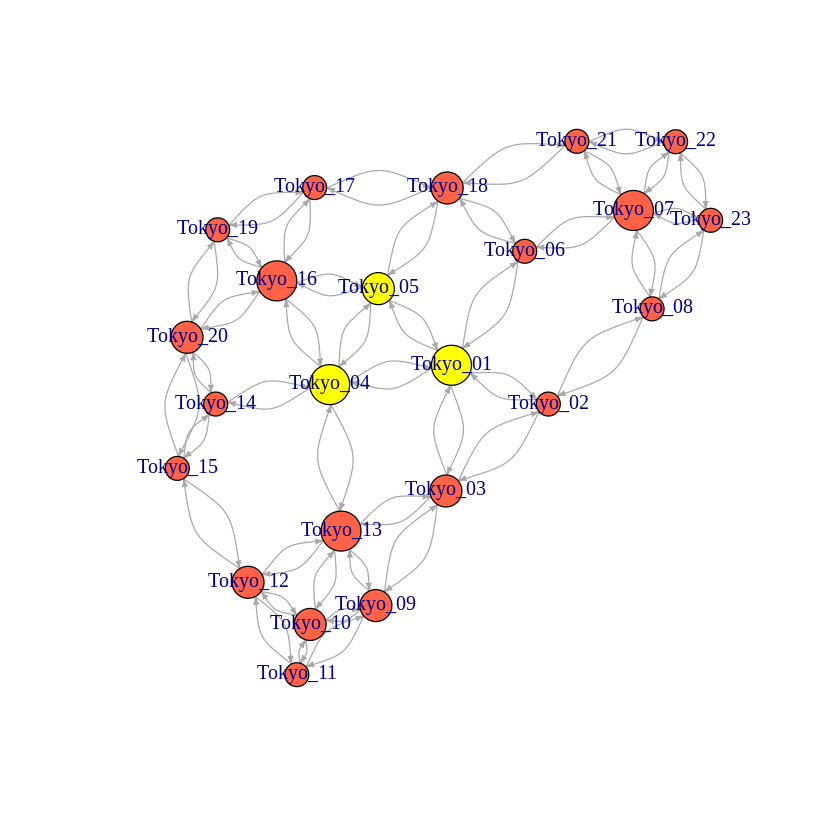

In [ ]:
#plot graph
V(g)$color <- "tomato"
V(g)$color[1] <- "yellow"
V(g)$color[4] <- "yellow"
V(g)$color[5] <- "yellow"

deg <- degree(g, mode="all")
V(g)$size <- deg*1.5
l <- layout.auto(g)
plot(g, edge.arrow.size=.3, vertex.label = V(g)$name, edge.curved=.5, layout=l)

## Total traffic calculatons


In [ ]:
traffic_file$traffic_ps <- traffic_file$trafficGbps*10^9/(8*N)
matrix_traffic <- matrix(0, nrow = length(V(g)), ncol = length(V(g)), dimnames = list(V(g), V(g)))
for (line in 1:nrow(traffic_file))
{

  vertex_sourse <- which(V(g)$name==traffic_file$sourceID[line])
  vertex_destination<- which(V(g)$name==traffic_file$destinationID[line])

  matrix_traffic[vertex_sourse, vertex_destination] <- matrix_traffic[vertex_sourse, vertex_destination] + traffic_file$traffic_ps[line]
}
g <- calc_full_traffic_for_matrix(g, matrix_traffic, N)
print("Total traffic for each link:")
print(paste("Link ",E(g)$Definition,"=",E(g)$Traffic))


[1] "Total traffic for each link:"
 [1] "Link  Tokyo_01->Tokyo_02 = 79834230.4238814"
 [2] "Link  Tokyo_01->Tokyo_03 = 54287389.5401041"
 [3] "Link  Tokyo_01->Tokyo_04 = 0"               
 [4] "Link  Tokyo_01->Tokyo_05 = 0"               
 [5] "Link  Tokyo_01->Tokyo_06 = 105745018.571492"
 [6] "Link  Tokyo_02->Tokyo_01 = 604245560.751103"
 [7] "Link  Tokyo_02->Tokyo_03 = 0"               
 [8] "Link  Tokyo_02->Tokyo_08 = 48980530.6000285"
 [9] "Link  Tokyo_03->Tokyo_01 = 488586505.860937"
[10] "Link  Tokyo_03->Tokyo_02 = 0"               
[11] "Link  Tokyo_03->Tokyo_09 = 42720073.4027781"
[12] "Link  Tokyo_03->Tokyo_13 = 0"               
[13] "Link  Tokyo_04->Tokyo_01 = 0"               
[14] "Link  Tokyo_04->Tokyo_05 = 0"               
[15] "Link  Tokyo_04->Tokyo_13 = 80974034.2579009"
[16] "Link  Tokyo_04->Tokyo_14 = 90064251.9638678"
[17] "Link  Tokyo_04->Tokyo_16 = 96062328.5755641"
[18] "Link  Tokyo_05->Tokyo_01 = 0"               
[19] "Link  Tokyo_05->Tokyo_04 = 0"            

## Calculations of the load, average number of packets, queueing and propagation delays:

In [ ]:
E(g)$Load <- ifelse(E(g)$Traffic !=0, E(g)$Traffic/E(g)$Capacity, 0)

In [ ]:
########################load and delays calc
E(g)$Ni = E(g)$Load/(1-E(g)$Load) # average number of packets in each system
#E(g)$Queue_Delay = E(g)$Ni/E(g)$Traffic
E(g)$Queue_Delay <- ifelse(E(g)$Traffic == 0, 0, E(g)$Ni/E(g)$Traffic)
E(g)$Prop_Delay <- 5*10^(-6)*E(g)$Distance

In [ ]:
#av load except zero
load <- dplyr::filter(data_frame(E(g)$Load), data_frame(E(g)$Load) != 0)
prop_delay <- dplyr::filter(data_frame(E(g)$Prop_Delay), data_frame(E(g)$Load) != 0)
capacity <- dplyr::filter(data_frame(E(g)$Capacity), data_frame(E(g)$Load) != 0)
traffic <- dplyr::filter(data_frame(E(g)$Traffic), data_frame(E(g)$Load) != 0)
sourceID = dplyr::filter(data_frame(ends(g, E(g))[,1]), data_frame(E(g)$Load) != 0)
destination = dplyr::filter(data_frame(ends(g, E(g))[,2]), data_frame(E(g)$Load) != 0)
df <- data.frame(sourceID = sourceID$`ends(g, E(g))[, 1]`, destinationID = destination$`ends(g, E(g))[, 2]`,
traffic_ps = traffic$`E(g)$Traffic`, capacity_ps = capacity$`E(g)$Capacity`, load = load$`E(g)$Load`, prop_delay_s = prop_delay$`E(g)$Prop_Delay`)
#safe log file
links_info_df <- df[order(df$load, decreasing = TRUE),]



#Output table with links information: traffic, load, propagation delay

In [ ]:
links_info_df

sourceID destinationID traffic_ps capacity_ps load      prop_delay_s
31 Tokyo_16 Tokyo_17        25955929   39476037  0.6575110 2e-06       
17 Tokyo_08 Tokyo_23        12695835   19863720  0.6391469 5e-06       
36 Tokyo_19 Tokyo_16       398293729  631270562  0.6309398 2e-06       
33 Tokyo_17 Tokyo_16       233603360  374818527  0.6232439 2e-06       
37 Tokyo_20 Tokyo_14       341644914  551042097  0.6199978 3e-06       
25 Tokyo_13 Tokyo_12         7625965   12464415  0.6118189 4e-06       
20 Tokyo_10 Tokyo_13       348754582  588141071  0.5929778 4e-06       
30 Tokyo_16 Tokyo_04       864560957 1543583821  0.5600998 3e-06       
4  Tokyo_02 Tokyo_01       604245561 1086357385  0.5562125 5e-06       
6  Tokyo_03 Tokyo_01       488586506  890977033  0.5483716 5e-06       
40 Tokyo_23 Tokyo_07       114262513  208710413  0.5474692 5e-06       
39 Tokyo_22 Tokyo_07       396846404  728750500  0.5445573 4e-06       
29 Tokyo_15 Tokyo_14       114262513  213949598  0.5340628 3e-06       
8  Tokyo_04 Tokyo_13        80974034  159611404  0.5073199 4e-06       
32 Tokyo_16 Tokyo_19        44254859   88807974  0.4983208 2e-06       
3  Tokyo_01 Tokyo_06       105745019  214710133  0.4925013 4e-06       
23 Tokyo_13 Tokyo_04       728766308 1480814458  0.4921388 4e-06       
15 Tokyo_07 Tokyo_22        44094045   90150066  0.4891183 4e-06       
7  Tokyo_03 Tokyo_09        42720073   87430957  0.4886150 5e-06       
27 Tokyo_14 Tokyo_15        12695835   25992171  0.4884484 3e-06       
19 Tokyo_09 Tokyo_11        36676856   75869251  0.4834219 5e-06       
1  Tokyo_01 Tokyo_02        79834230  165147444  0.4834118 5e-06       
21 Tokyo_11 Tokyo_09       330091704  691357318  0.4774546 5e-06       
2  Tokyo_01 Tokyo_03        54287390  113880872  0.4767033 5e-06       
26 Tokyo_14 Tokyo_04       810578268 1702777664  0.4760329 3e-06       
13 Tokyo_06 Tokyo_07        66066303  139109649  0.4749225 4e-06       
38 Tokyo_21 Tokyo_18       104105845  225214107  0.4622528 3e-06       
16 Tokyo_08 Tokyo_02       326562262  707209678  0.4617616 5e-06       
28 Tokyo_14 Tokyo_20        37960546   82315290  0.4611603 3e-06       
18 Tokyo_09 Tokyo_03       384480661  833781710  0.4611287 5e-06       
9  Tokyo_04 Tokyo_14        90064252  197599713  0.4557914 3e-06       
34 Tokyo_18 Tokyo_05       500926857 1113211205  0.4499837 3e-06       
10 Tokyo_04 Tokyo_16        96062329  214044149  0.4487968 3e-06       
24 Tokyo_13 Tokyo_10        38750509   88062874  0.4400323 4e-06       
5  Tokyo_02 Tokyo_08        48980531  112529308  0.4352691 5e-06       
14 Tokyo_07 Tokyo_06       708859239 1667311091  0.4251512 4e-06       
12 Tokyo_06 Tokyo_01      1065967680 2525132270  0.4221433 4e-06       
22 Tokyo_12 Tokyo_13        68633683  167467676  0.4098324 4e-06       
11 Tokyo_05 Tokyo_18        55658540  136337502  0.4082409 3e-06       
35 Tokyo_18 Tokyo_21        11567316   28617873  0.4041990 3e-06

#Simmer simultion

Including queuing, transmission, propagation delay

In [ ]:
simulation_simmer <- function(g, traffic_file){
  E(g)$Queue_Delay_sim <- 0
  E(g)$Queue_Delay_theor_hoeff99 <- 0
  E(g)$Queue_Delay_sim_99p <- 0

  #####################################simmer
  queue_delay_tr_flow <- c()
  prop_delay_tr_flow <- c()
  delay_tr_flow <- c()
  delay_tr_flow_p_99 <- c()
  exp_delay_igraph <- c()
  delay_tr_flow_hoeffd_p_99_100 <- c()
  digits = 10
  print("start simulation in simmer")
  for (line in 1:nrow(traffic_file))
  {
    print(line)
    #env <- simmer("SuperDuperSim") #creating the simmer environment

    if(traffic_file$sourceID[line] != traffic_file$destinationID[line] && traffic_file$traffic_ps[line] != 0)
    {
      env <- simmer()
      lambda_simmer <- traffic_file$traffic_ps[line]
      set.seed(42)
      env <- simmer_resources(g, env) # add resources for all nodes of igraph (func is in the file simmer_fictions)
      env <- simmer_crosstrajectory_simulation(env, g, traffic_file$sourceID[line], traffic_file$destinationID[line], lambda_simmer) #creating cross trajectories with theirs generator  (func is in the file simmer_fictions)



      c(env, traffic_traj_name, delay_queue, delay_prop) := simmer_simulation(env, traffic_file$sourceID[line], traffic_file$destinationID[line], g, traffic_val=lambda_simmer, log_info = "") #creation main trajectory with its generator


      env %>% #env execution
        reset() %>%
        run(10000/lambda_simmer) %>% #1000 packets of the main lambda trajectory
        now()


      #########################delay results processing
      all_arrivals_res <- data.frame(env %>%
                                       get_mon_arrivals(per_resource = TRUE) %>%
                                       transform(waiting_time_in_queue = round(end_time - start_time - activity_time)) %>%
                                       transform(spending_time = end_time - start_time))


      ############################plots for each node (only with queuing delay)
      ##########computing the bounds and parameters (mean, variance, and etc)
      path <- shortest_paths(g, traffic_file$sourceID[line], traffic_file$destinationID[line] ,weights = NULL, output = "both", algorithm = c("automatic"))
      path_size <- length(path[["vpath"]][[1]])
      n=1
      for (node in path[["vpath"]][[1]][-path_size])
      {
        traffic <- dplyr::filter(all_arrivals_res, paste0("node_", node) == all_arrivals_res$resource)
        if (length(traffic$spending_time) != 0)
        {
          print(node)
          delay_nodes <- mean(traffic$spending_time)
          p_99_result <- unname(quantile(traffic$spending_time, probs = 0.99))
          ####################
          print(paste("Node - ", node, ":"))
          bounds_function_node(delay_queue[node], traffic$spending_time, digits, info = paste("Node - ", node, ";","For the traffic flow:from",traffic_file$sourceID[line],"to", traffic_file$destinationID[line]))#plot the results for each node
          E(g)[get.edge.ids(g, c(path[["vpath"]][[1]][n],path[["vpath"]][[1]][n+1]), multi=TRUE)]$Queue_Delay_sim <- delay_nodes
          E(g)[get.edge.ids(g, c(path[["vpath"]][[1]][n],path[["vpath"]][[1]][n+1]), multi=TRUE)]$Queue_Delay_sim_99p <- p_99_result
          E(g)[get.edge.ids(g, c(path[["vpath"]][[1]][n],path[["vpath"]][[1]][n+1]), multi=TRUE)]$Queue_Delay_theor_hoeff99 <- func_bounds_hoeffding(delay_queue[node], 0.99,delay_queue[node], 0, 0.99)

          print(E(g)[get.edge.ids(g, c(path[["vpath"]][[1]][n],path[["vpath"]][[1]][n+1]), multi=TRUE)])
          n=n+1

        }

      }

      ###########################plots for each traffic flow (prop + queuing delays)
      #########################delay results processing
      all_arrivals_res <- data.frame(env %>%
                                       get_mon_arrivals(per_resource = FALSE) %>%
                                       transform(waiting_time_in_queue = round(end_time - start_time - activity_time)) %>%
                                       transform(spending_time = end_time - start_time))
      traffic <- dplyr::filter(all_arrivals_res, grepl(traffic_traj_name , all_arrivals_res$name))
      exp_delay = sum(delay_prop,delay_queue)
      exp_delay_igraph <- append(exp_delay_igraph,exp_delay)

      bounds_function_1w_path(sum(delay_prop), sum(delay_queue), traffic$spending_time, digits, info = paste("For the traffic flow:from",traffic_file$sourceID[line],"to", traffic_file$destinationID[line]))#plot the results for tr flow
      queue_delay_tr_flow <- append(queue_delay_tr_flow, sum(delay_queue))
      prop_delay_tr_flow <- append(prop_delay_tr_flow, sum(delay_prop))
      delay_tr_flow <- append(delay_tr_flow, mean(traffic$spending_time))
      delay_tr_flow_p_99 <- append(delay_tr_flow_p_99, unname(quantile(traffic$spending_time, probs = 0.99)))
      hoeff <- func_bounds_hoeffding(sum(delay_queue, delay_prop), 0.99, delay_queue, delay_prop, 0.99)
      delay_tr_flow_hoeffd_p_99_100 <- append(delay_tr_flow_hoeffd_p_99_100, hoeff)

    } else{
      print("no info of traffic")
      exp_delay_igraph <- append(exp_delay_igraph,0)
      queue_delay_tr_flow <- append(queue_delay_tr_flow, 0)
      prop_delay_tr_flow <- append(prop_delay_tr_flow, NaN)
      delay_tr_flow <- append(delay_tr_flow, 0)
      delay_tr_flow_p_99 <- append(delay_tr_flow_p_99, 0)
      delay_tr_flow_hoeffd_p_99_100 <- append(delay_tr_flow_hoeffd_p_99_100, 0)
      print(delay_tr_flow)
    }
  }


  df <- data_frame(exp_delay_igraph, delay_tr_flow, delay_tr_flow_p_99, delay_tr_flow_hoeffd_p_99_100)

  return(list(delay_tr_flow, exp_delay_igraph, delay_tr_flow_p_99, delay_tr_flow_hoeffd_p_99_100, g))
}



##Simulation of all traffic flows, comparision of experimental with theretical

[1] "start simulation in simmer"
[1] 1
[1] "no info of traffic"
[1] 0
[1] 2
[1] "node_2"
[1] 1086357385
[1] 0.5562125
[1] 326562262
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_02->Tokyo_01
[1] "traffic_Tokyo_02_Tokyo_01_"
[1] 2
[1] "Node -  2 :"
[1] "variance= 4.83755499146366e-18"
[1] "sigma2= 2.19944424604573e-09"
[1] "igraph E(T) = 2.07420757853372e-09"
[1] "simmer E(T) = 2.16256856584355e-09"
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_02->Tokyo_01
[1] "variance= 5.053909552112e-18"
[1] "sigma2= 2.24809020106223e-09"
[1] "igraph E(T) = 5.00207420757853e-06"
[1] "simmer E(T) = 5.00218516897505e-06"


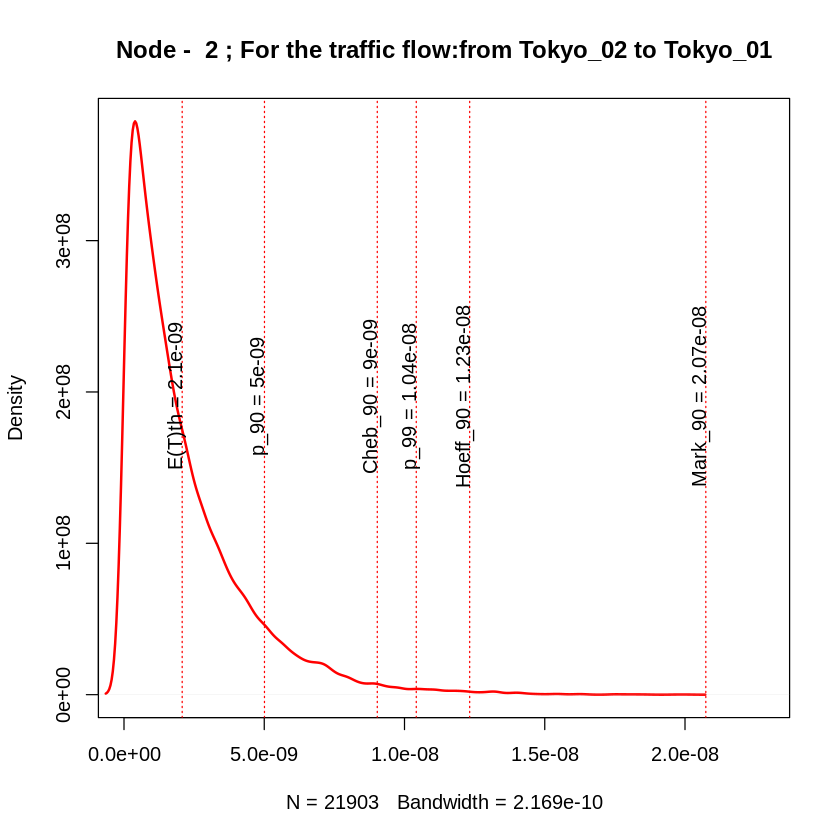

[1] 3
[1] "node_3"
[1] 890977033
[1] 0.5483716
[1] 384480661
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_03->Tokyo_01
[1] "traffic_Tokyo_03_Tokyo_01_"
[1] 3
[1] "Node -  3 :"
[1] "variance= 6.52288910996214e-18"
[1] "sigma2= 2.55399473569586e-09"
[1] "igraph E(T) = 2.4851479663032e-09"
[1] "simmer E(T) = 2.49282916599817e-09"


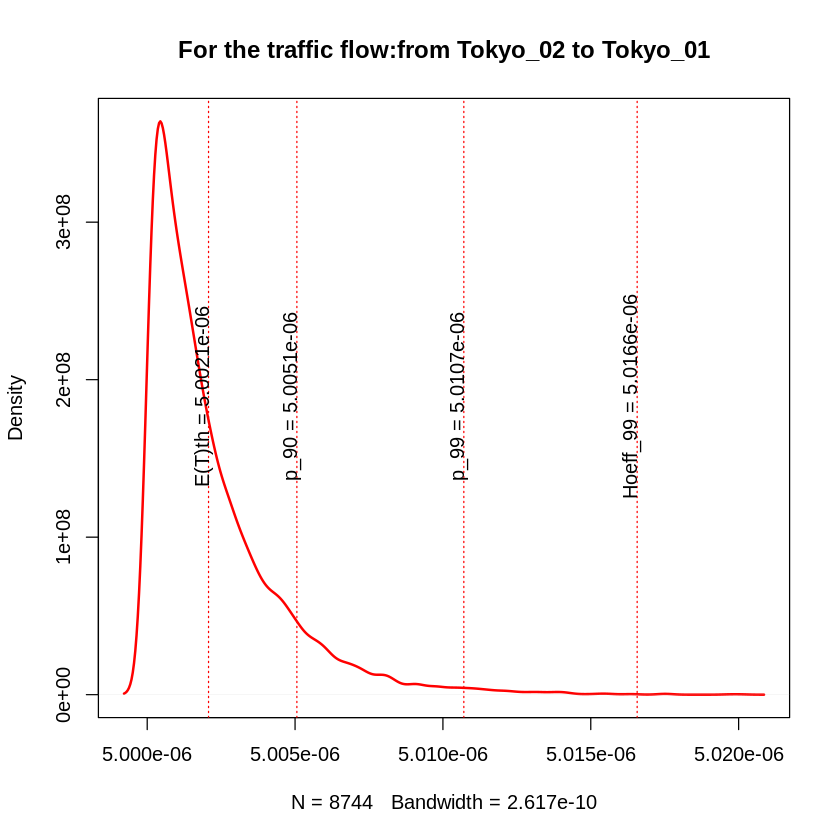

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_03->Tokyo_01
[1] "variance= 6.45284251406347e-18"
[1] "sigma2= 2.54024457760734e-09"
[1] "igraph E(T) = 5.0024851479663e-06"
[1] "simmer E(T) = 5.00250463924242e-06"


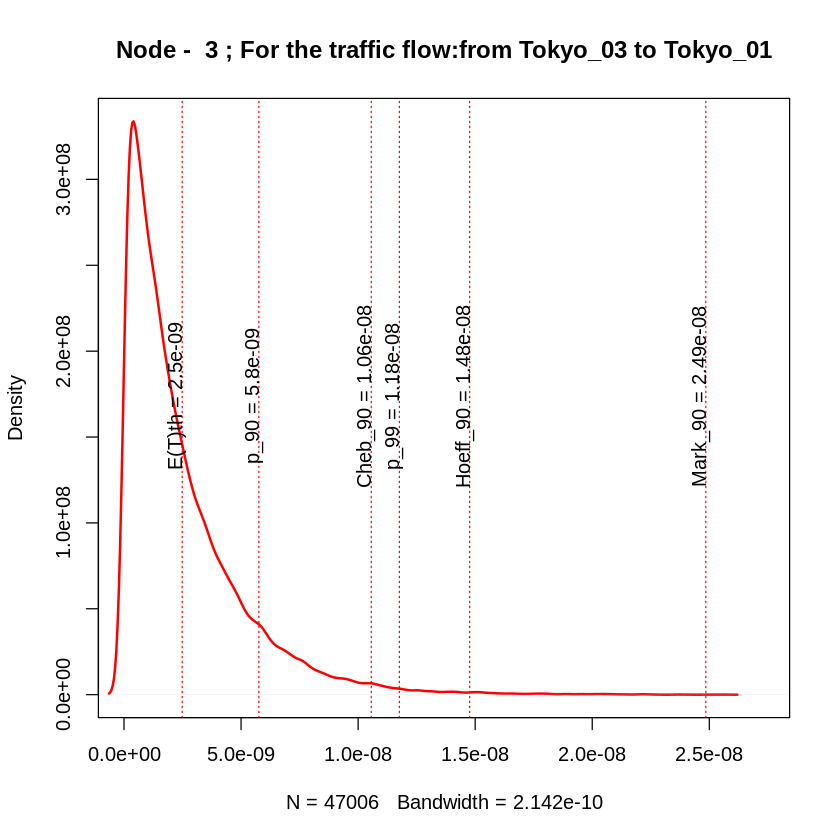

[1] 4
[1] "no info of traffic"
[1] 0.000000e+00 5.002185e-06 5.002505e-06 0.000000e+00
[1] 5
[1] "no info of traffic"
[1] 0.000000e+00 5.002185e-06 5.002505e-06 0.000000e+00 0.000000e+00
[1] 6
[1] "node_6"
[1] 2525132270
[1] 0.4221433
[1] 708859239
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_06->Tokyo_01
[1] "traffic_Tokyo_06_Tokyo_01_"
[1] 6
[1] "Node -  6 :"
[1] "variance= 4.99053072673416e-19"
[1] "sigma2= 7.06436885130877e-10"
[1] "igraph E(T) = 6.85323648411598e-10"
[1] "simmer E(T) = 6.9572289505277e-10"


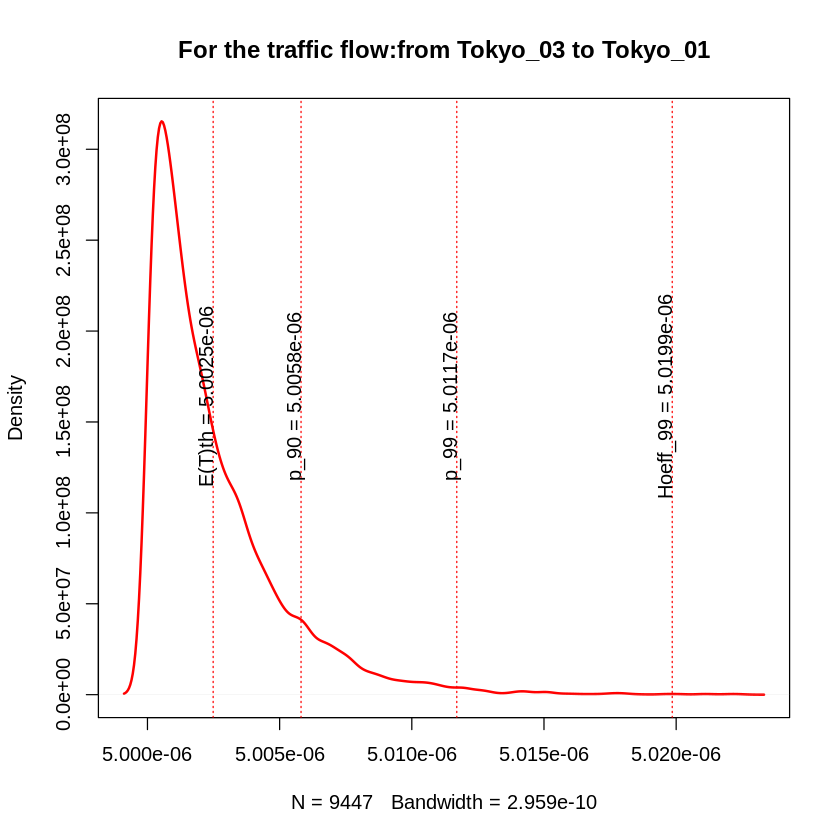

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_06->Tokyo_01
[1] "variance= 5.06586693011954e-19"
[1] "sigma2= 7.11749037942415e-10"
[1] "igraph E(T) = 4.00068532364841e-06"
[1] "simmer E(T) = 4.00069705269323e-06"


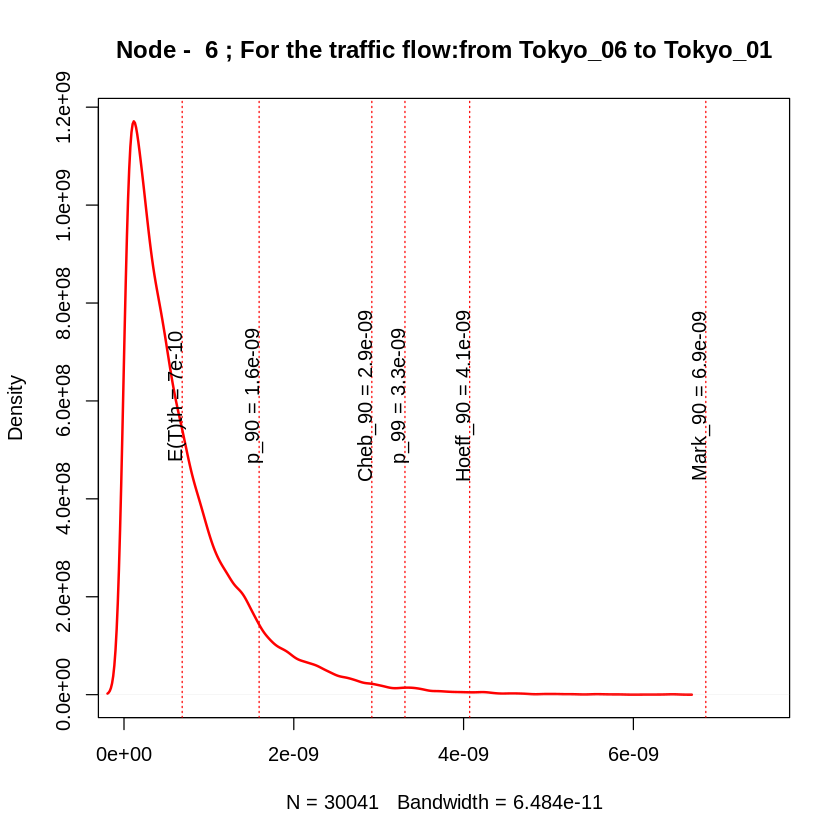

[1] 7
[1] "node_7"
[1] 1667311091
[1] 0.4251512
[1] 511108917
[1] "node_6"
[1] 2525132270
[1] 0.4221433
[1] 868217358
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_07->Tokyo_06
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_06->Tokyo_01
[1] "traffic_Tokyo_07_Tokyo_01_"
[1] 7
[1] "Node -  7 :"
[1] "variance= 1.12967686064973e-18"
[1] "sigma2= 1.06286257844075e-09"
[1] "igraph E(T) = 1.04334922898788e-09"
[1] "simmer E(T) = 1.05915537500319e-09"


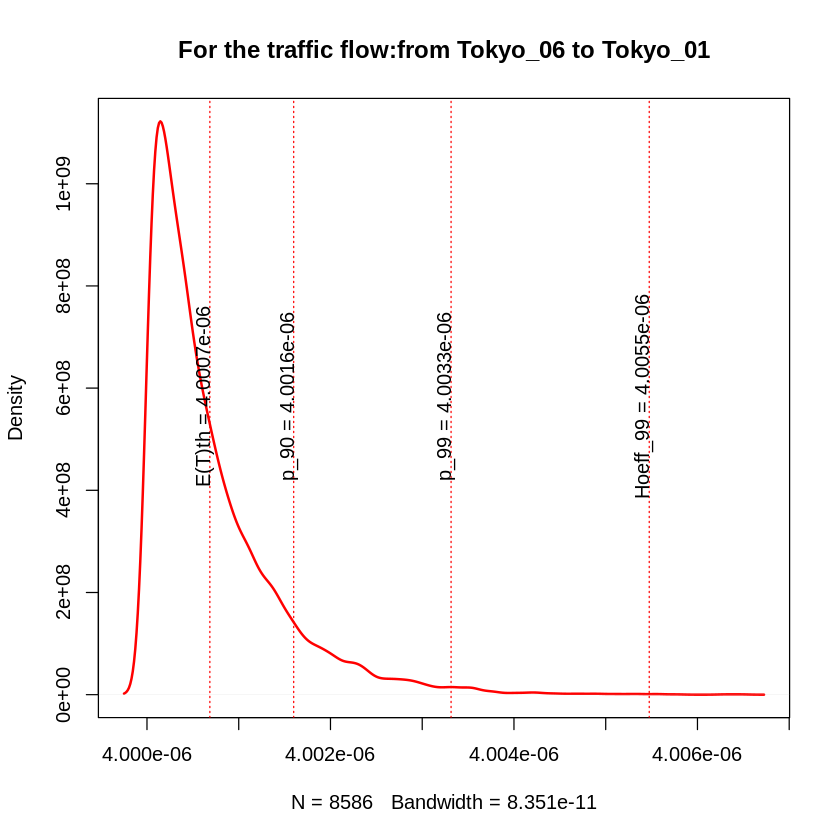

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_07->Tokyo_06
[1] 6
[1] "Node -  6 :"
[1] "variance= 4.64303941174456e-19"
[1] "sigma2= 6.81398518617744e-10"
[1] "igraph E(T) = 6.85323648411598e-10"
[1] "simmer E(T) = 6.87050744990274e-10"


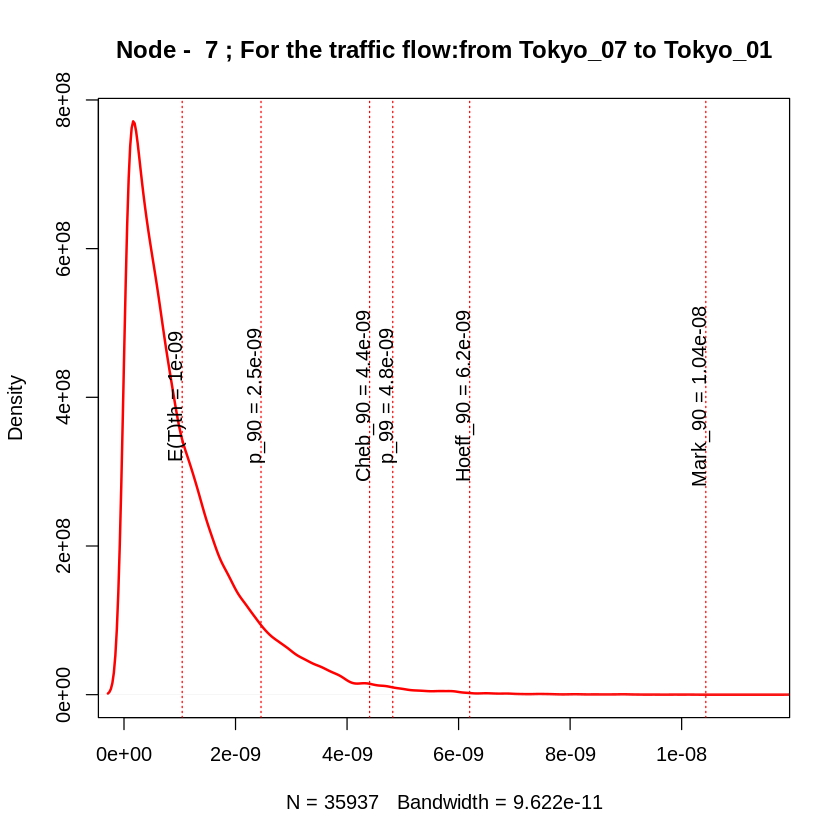

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_06->Tokyo_01
[1] "variance= 1.49722104196384e-18"
[1] "sigma2= 1.22360984057985e-09"
[1] "igraph E(T) = 8.0017286728774e-06"
[1] "simmer E(T) = 8.0017185278807e-06"


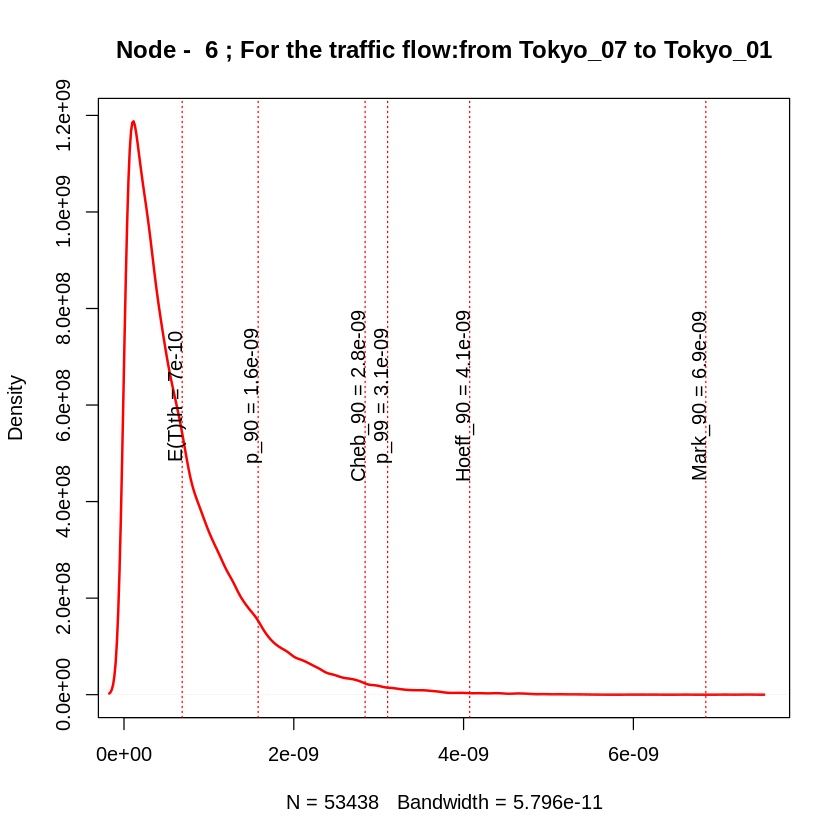

[1] 8
[1] "node_2"
[1] 1086357385
[1] 0.5562125
[1] 277683298
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_08->Tokyo_02
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_02->Tokyo_01
[1] "traffic_Tokyo_08_Tokyo_01_"
[1] 8
[1] "Node -  8 :"
[1] "variance= 7.41572502335851e-18"
[1] "sigma2= 2.7231828846698e-09"
[1] "igraph E(T) = 2.62710308807949e-09"
[1] "simmer E(T) = 2.7222991491855e-09"


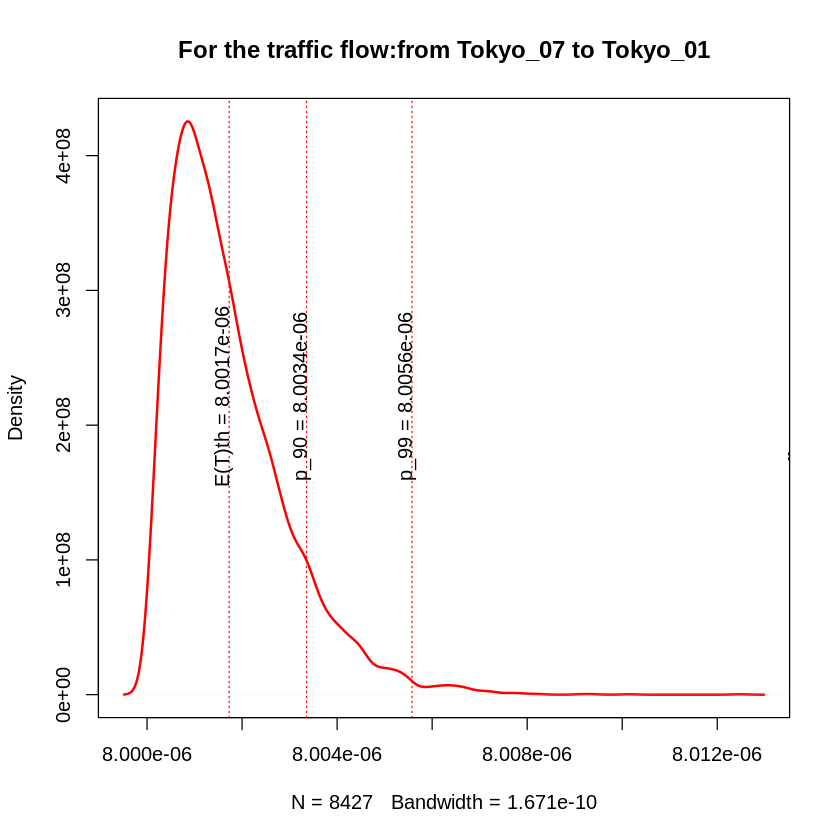

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_08->Tokyo_02
[1] 2
[1] "Node -  2 :"
[1] "variance= 3.63064004773055e-18"
[1] "sigma2= 1.90542384989024e-09"
[1] "igraph E(T) = 2.07420757853372e-09"
[1] "simmer E(T) = 1.92923270913673e-09"


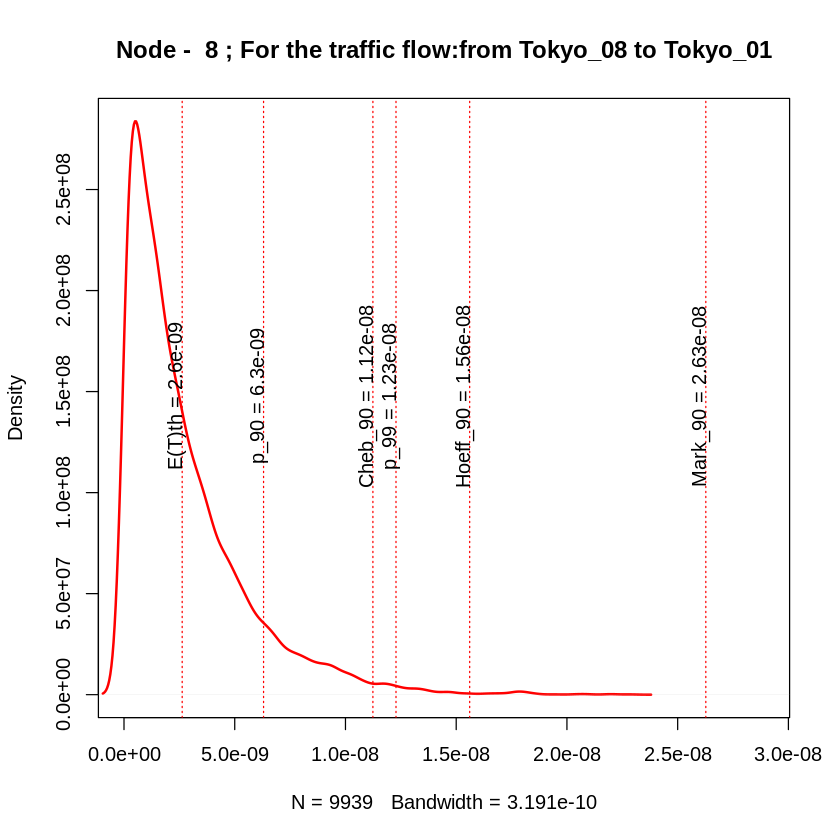

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_02->Tokyo_01
[1] "variance= 1.10117095939071e-17"
[1] "sigma2= 3.31838960851602e-09"
[1] "igraph E(T) = 1.00047013106666e-05"
[1] "simmer E(T) = 1.00047073672414e-05"


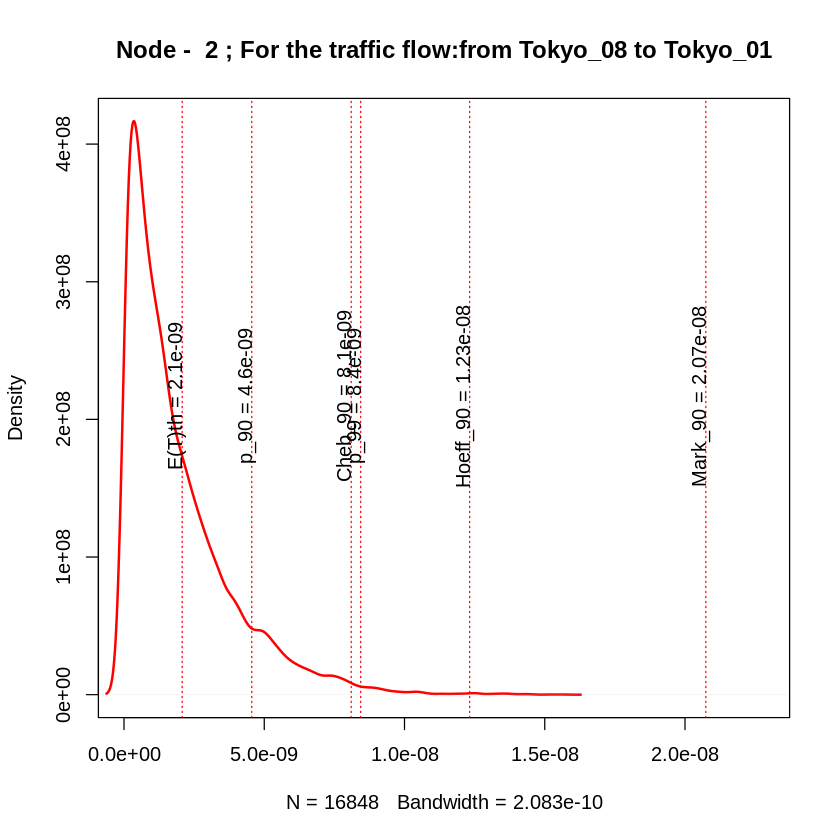

[1] 9
[1] "node_9"
[1] 833781710
[1] 0.4611287
[1] 330091704
[1] "node_3"
[1] 890977033
[1] 0.5483716
[1] 434197550
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_09->Tokyo_03
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_03->Tokyo_01
[1] "traffic_Tokyo_09_Tokyo_01_"
[1] 9
[1] "Node -  9 :"
[1] "variance= 4.98374057919708e-18"
[1] "sigma2= 2.23242929993249e-09"
[1] "igraph E(T) = 2.22567919971813e-09"
[1] "simmer E(T) = 2.22673053065493e-09"


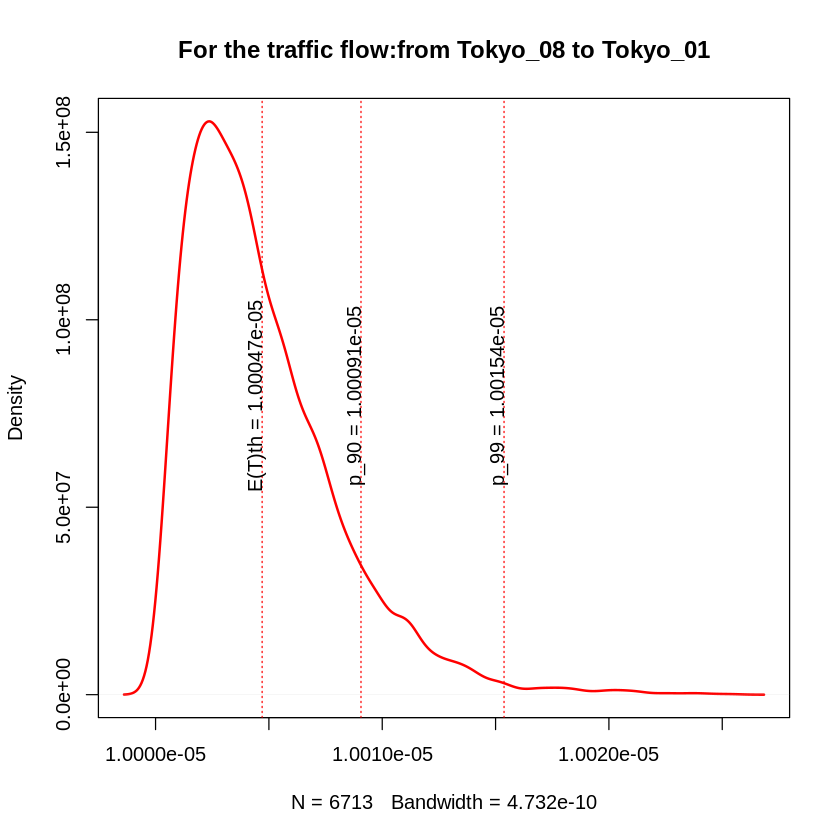

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_09->Tokyo_03
[1] 3
[1] "Node -  3 :"
[1] "variance= 6.29886715716417e-18"
[1] "sigma2= 2.50975440176209e-09"
[1] "igraph E(T) = 2.4851479663032e-09"
[1] "simmer E(T) = 2.50722214652543e-09"


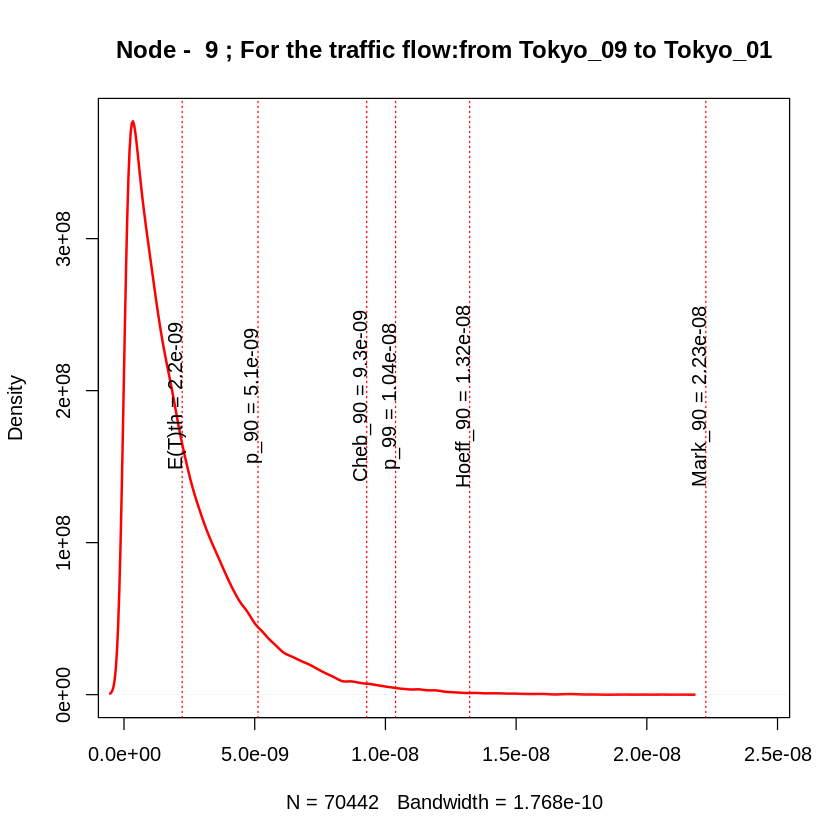

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_03->Tokyo_01
[1] "variance= 1.13701115767166e-17"
[1] "sigma2= 3.3719596048465e-09"
[1] "igraph E(T) = 1.0004710827166e-05"
[1] "simmer E(T) = 1.0004783263321e-05"


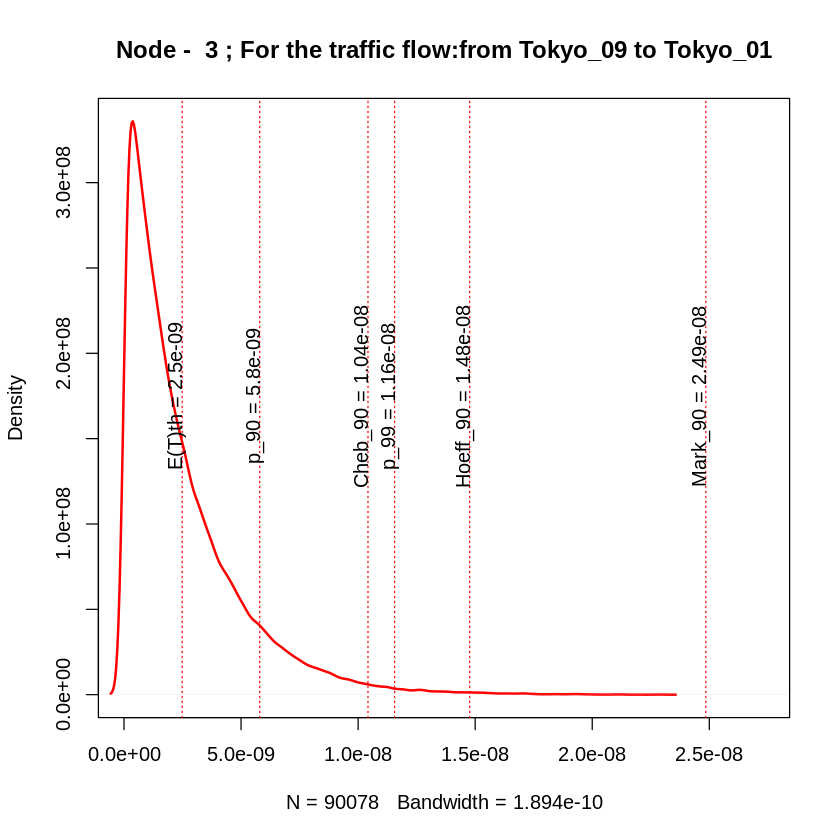

[1] 10
[1] "node_13"
[1] 1480814458
[1] 0.4921388
[1] 380011727
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_10->Tokyo_13
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_13->Tokyo_04
[1] "traffic_Tokyo_10_Tokyo_04_"
[1] 10
[1] "Node -  10 :"
[1] "variance= 1.85083392451277e-17"
[1] "sigma2= 4.30213194185484e-09"
[1] "igraph E(T) = 4.17734518883248e-09"
[1] "simmer E(T) = 4.31182381905812e-09"


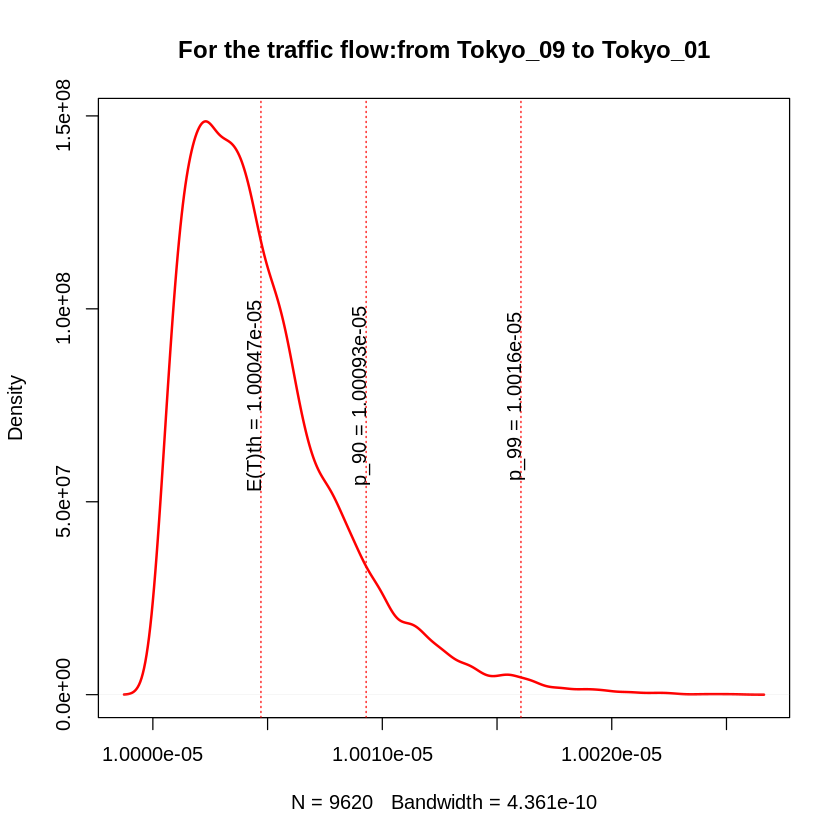

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_10->Tokyo_13
[1] 13
[1] "Node -  13 :"
[1] "variance= 1.59396946785623e-18"
[1] "sigma2= 1.2625250365265e-09"
[1] "igraph E(T) = 1.32970209501376e-09"
[1] "simmer E(T) = 1.27065144061556e-09"


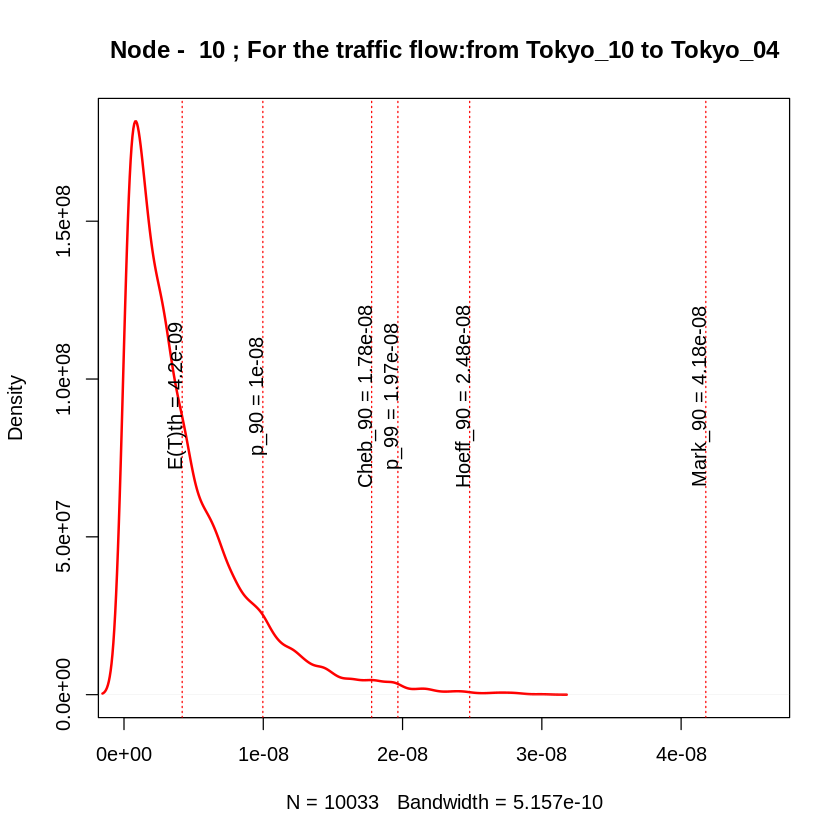

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_13->Tokyo_04
[1] "variance= 2.1391575209567e-17"
[1] "sigma2= 4.62510272421781e-09"
[1] "igraph E(T) = 8.00550704728385e-06"
[1] "simmer E(T) = 8.00585739890143e-06"


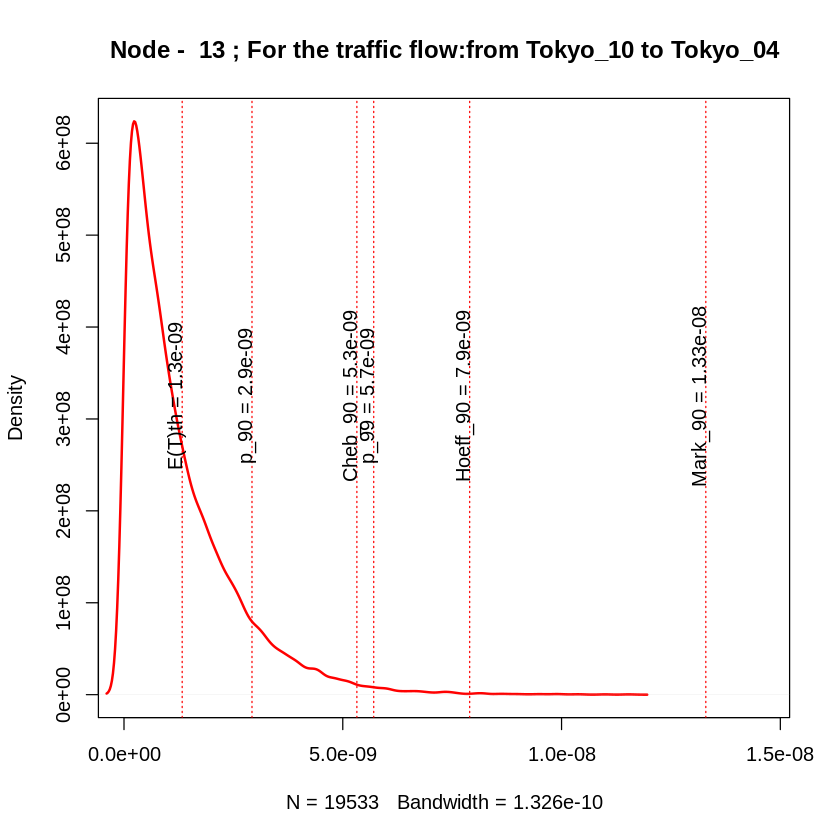

[1] 11
[1] "node_9"
[1] 833781710
[1] 0.4611287
[1] 54388956
[1] "node_3"
[1] 890977033
[1] 0.5483716
[1] 158494801
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_11->Tokyo_09
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_09->Tokyo_03
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_03->Tokyo_01
[1] "traffic_Tokyo_11_Tokyo_01_"
[1] 11
[1] "Node -  11 :"
[1] "variance= 7.85111557621029e-18"
[1] "sigma2= 2.80198422126362e-09"
[1] "igraph E(T) = 2.76804645222458e-09"
[1] "simmer E(T) = 2.83617691985685e-09"


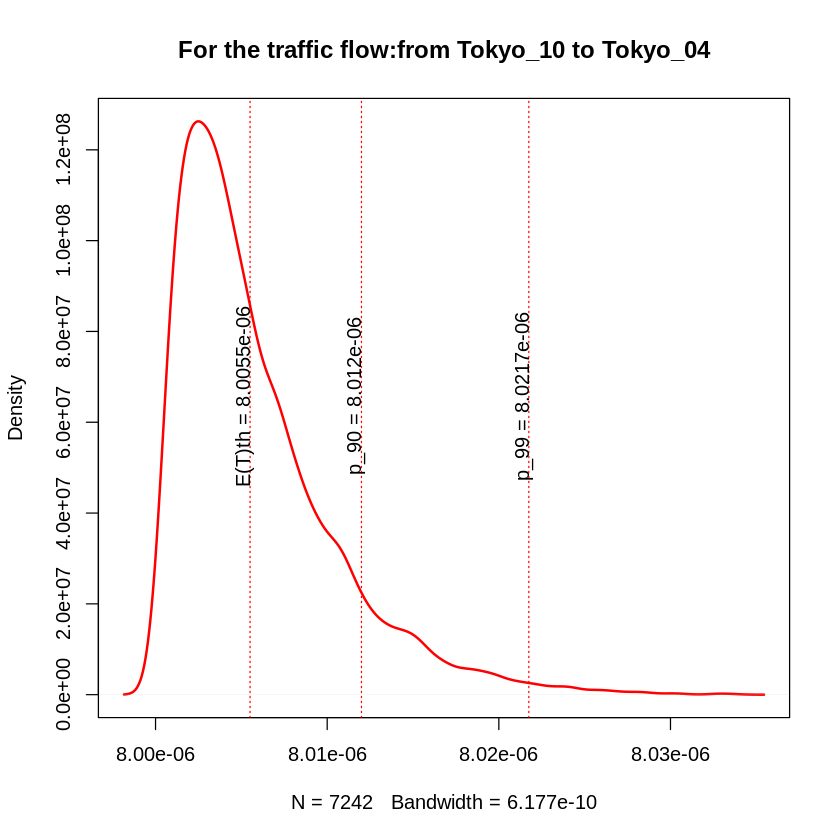

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_11->Tokyo_09
[1] 9
[1] "Node -  9 :"
[1] "variance= 4.76009058585056e-18"
[1] "sigma2= 2.18176318280664e-09"
[1] "igraph E(T) = 2.22567919971813e-09"
[1] "simmer E(T) = 2.14904341585845e-09"


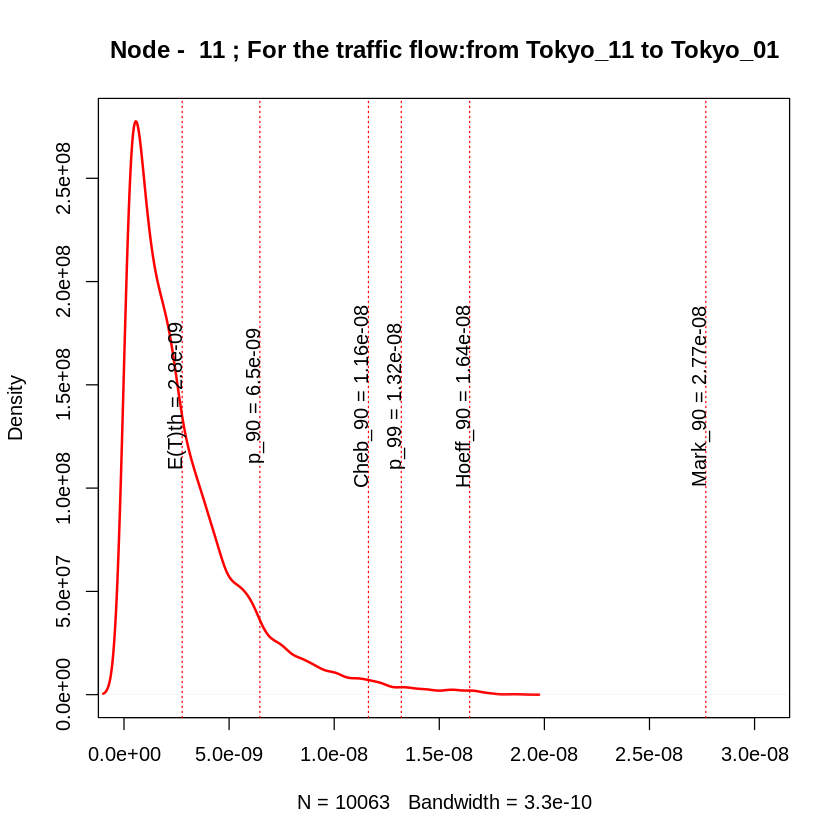

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_09->Tokyo_03
[1] 3
[1] "Node -  3 :"
[1] "variance= 5.48459524041647e-18"
[1] "sigma2= 2.34192127118237e-09"
[1] "igraph E(T) = 2.4851479663032e-09"
[1] "simmer E(T) = 2.29250582272003e-09"


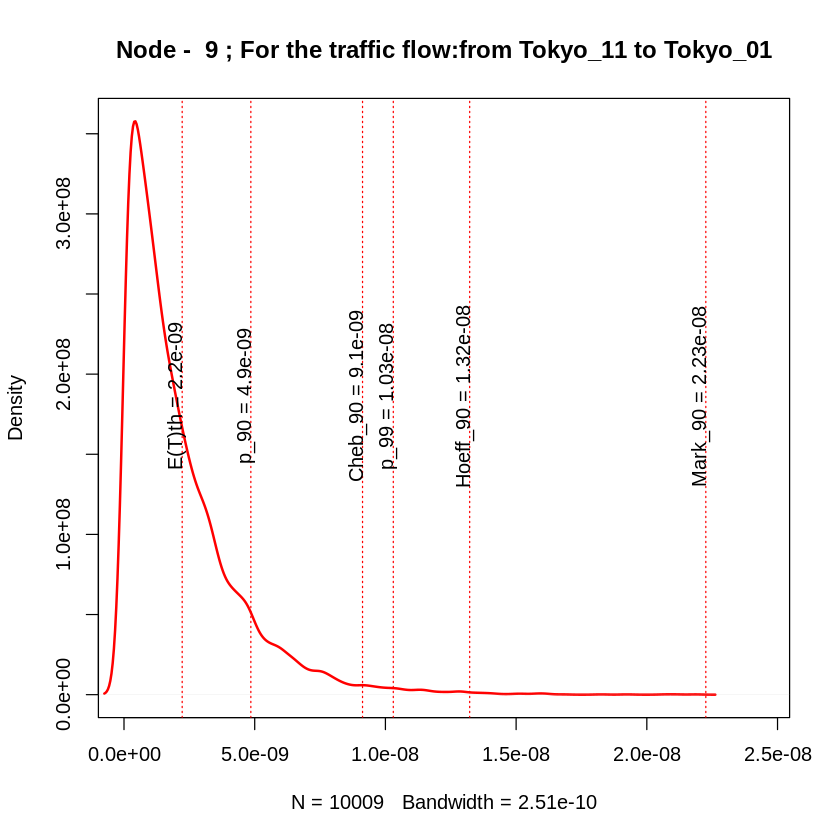

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_03->Tokyo_01
[1] "variance= 1.85127944004467e-17"
[1] "sigma2= 4.30264969529785e-09"
[1] "igraph E(T) = 1.50074788736182e-05"
[1] "simmer E(T) = 1.50074496027459e-05"


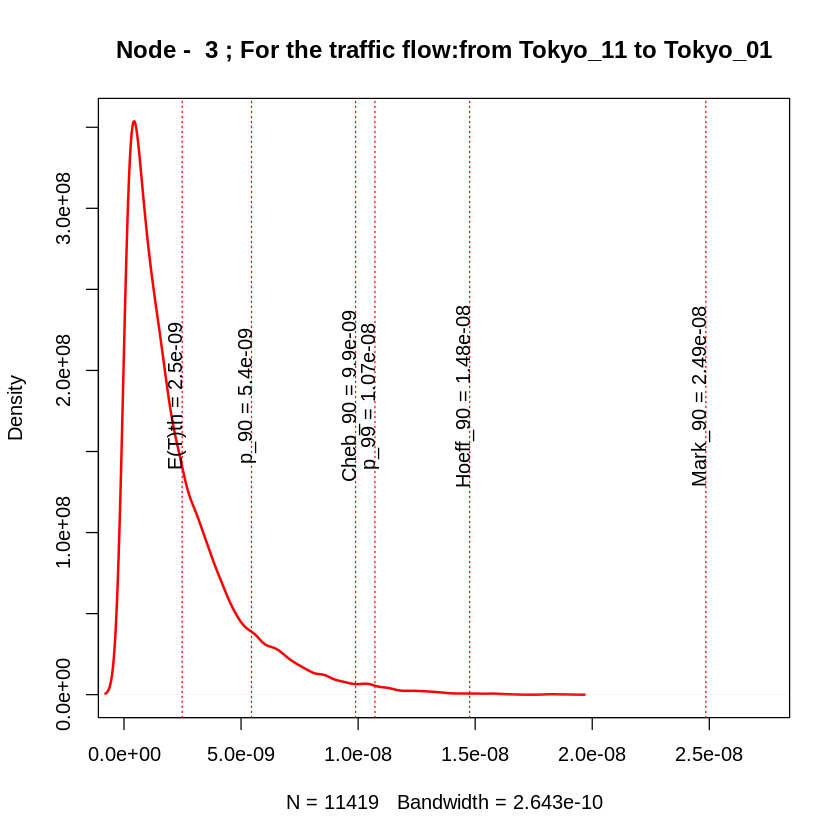

[1] 12
[1] "node_13"
[1] 1480814458
[1] 0.4921388
[1] 660132625
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_12->Tokyo_13
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_13->Tokyo_04
[1] "traffic_Tokyo_12_Tokyo_04_"
[1] 12
[1] "Node -  12 :"
[1] "variance= 1.10663750662144e-16"
[1] "sigma2= 1.05196839620848e-08"
[1] "igraph E(T) = 1.01179763380594e-08"
[1] "simmer E(T) = 1.03898399777599e-08"


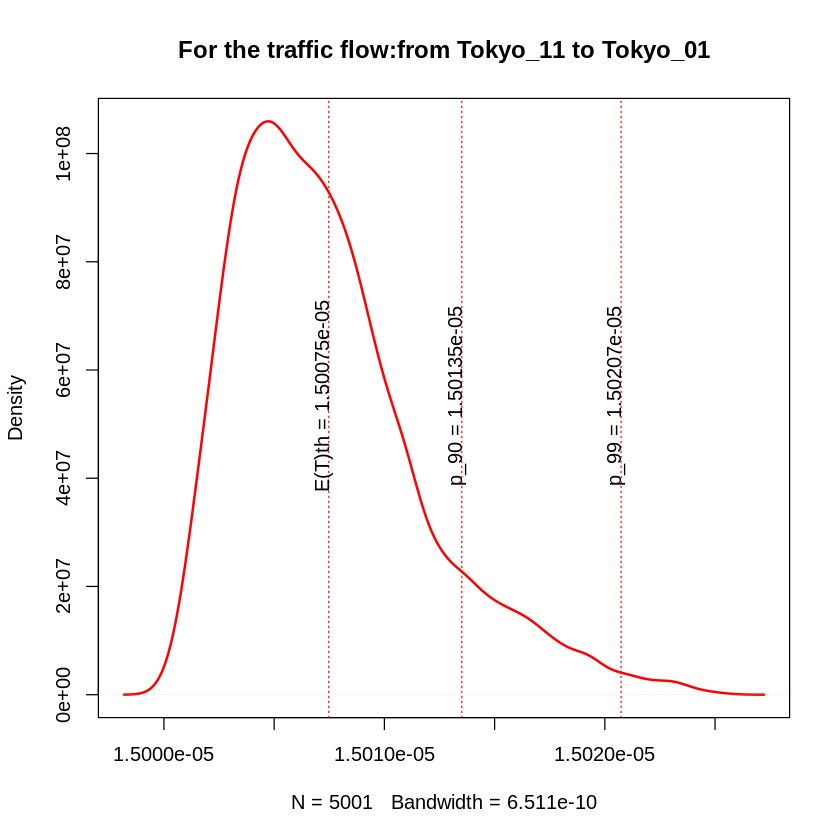

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_12->Tokyo_13
[1] 13
[1] "Node -  13 :"
[1] "variance= 1.89394064015453e-18"
[1] "sigma2= 1.37620515918032e-09"
[1] "igraph E(T) = 1.32970209501376e-09"
[1] "simmer E(T) = 1.35456837881425e-09"


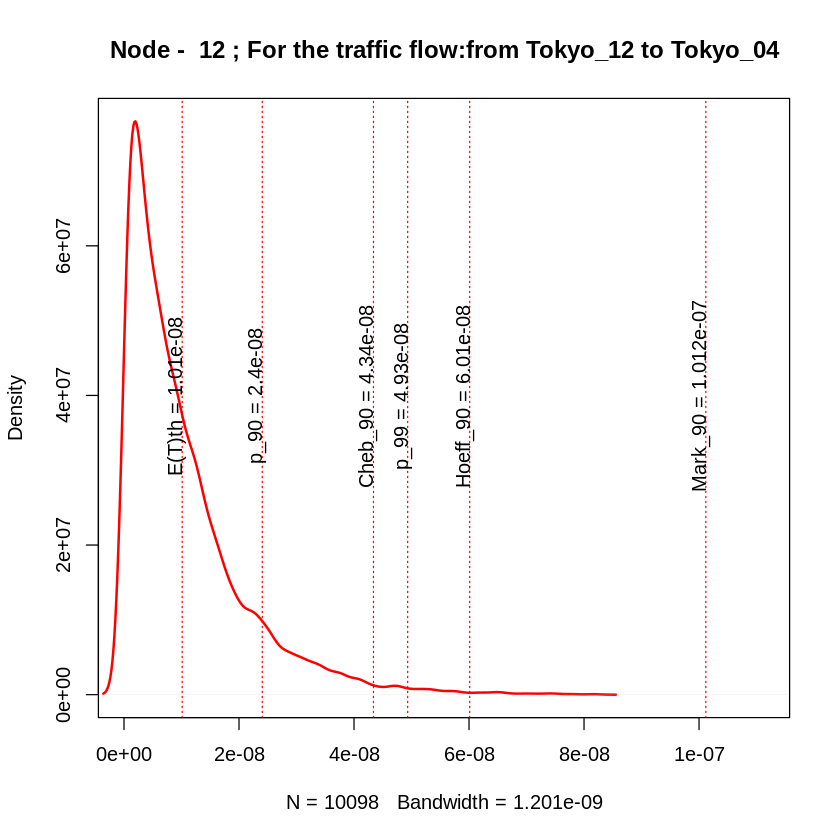

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_13->Tokyo_04
[1] "variance= 1.12664352159589e-16"
[1] "sigma2= 1.06143465253207e-08"
[1] "igraph E(T) = 8.01144767843307e-06"
[1] "simmer E(T) = 8.01172800625624e-06"


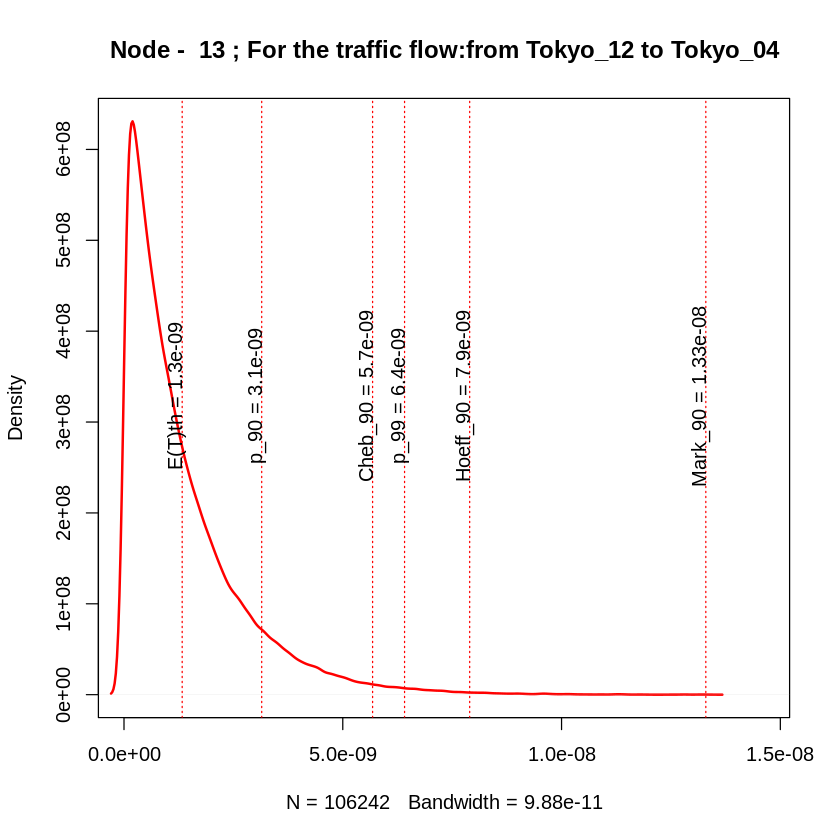

[1] 13
[1] "node_13"
[1] 1480814458
[1] 0.4921388
[1] 417388264
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_13->Tokyo_04
[1] "traffic_Tokyo_13_Tokyo_04_"
[1] 13
[1] "Node -  13 :"
[1] "variance= 1.77528017965571e-18"
[1] "sigma2= 1.33239640484944e-09"
[1] "igraph E(T) = 1.32970209501376e-09"
[1] "simmer E(T) = 1.3338876721505e-09"


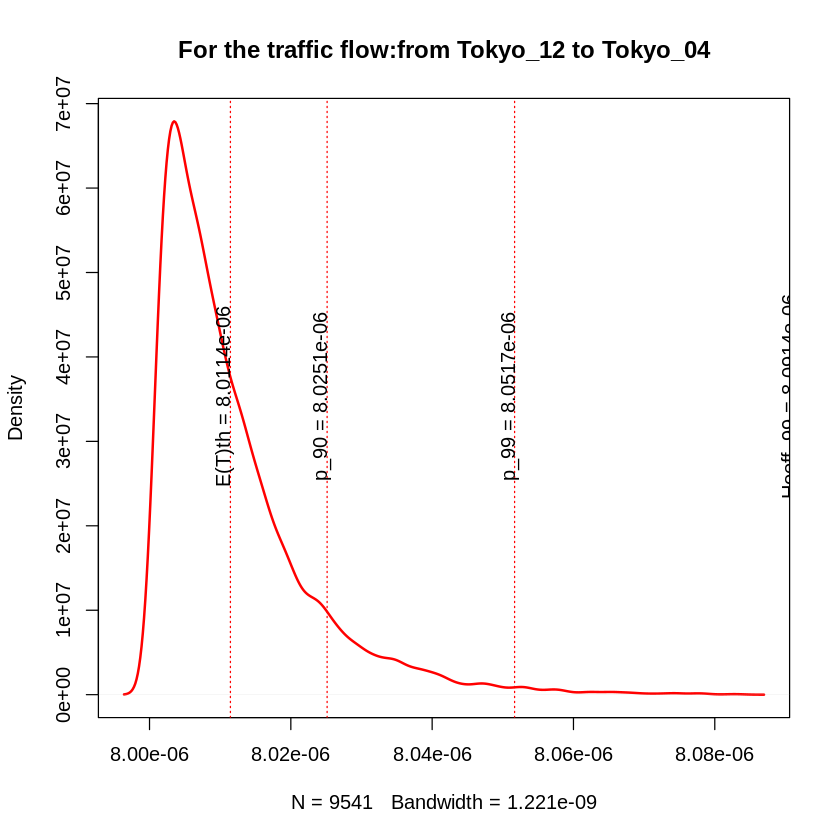

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_13->Tokyo_04
[1] "variance= 1.74998780175296e-18"
[1] "sigma2= 1.32287104502025e-09"
[1] "igraph E(T) = 4.00132970209501e-06"
[1] "simmer E(T) = 4.00132847610173e-06"


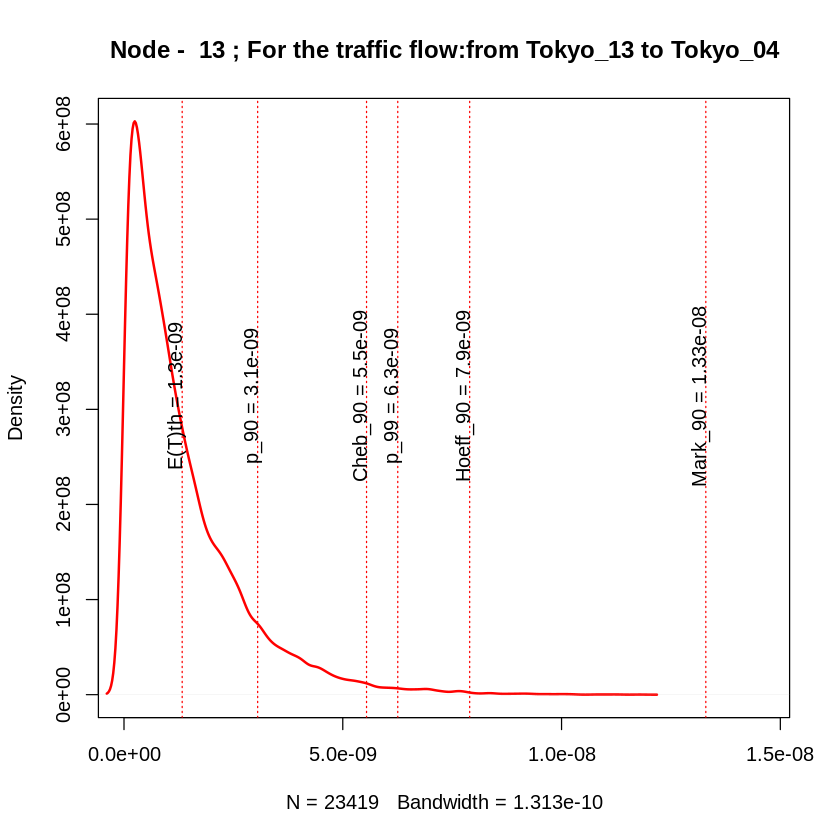

[1] 14
[1] "node_14"
[1] 1702777664
[1] 0.4760329
[1] 455907427
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_14->Tokyo_04
[1] "traffic_Tokyo_14_Tokyo_04_"
[1] 14
[1] "Node -  14 :"
[1] "variance= 1.42929840748218e-18"
[1] "sigma2= 1.19553268775144e-09"
[1] "igraph E(T) = 1.12082568595555e-09"
[1] "simmer E(T) = 1.15187705921899e-09"


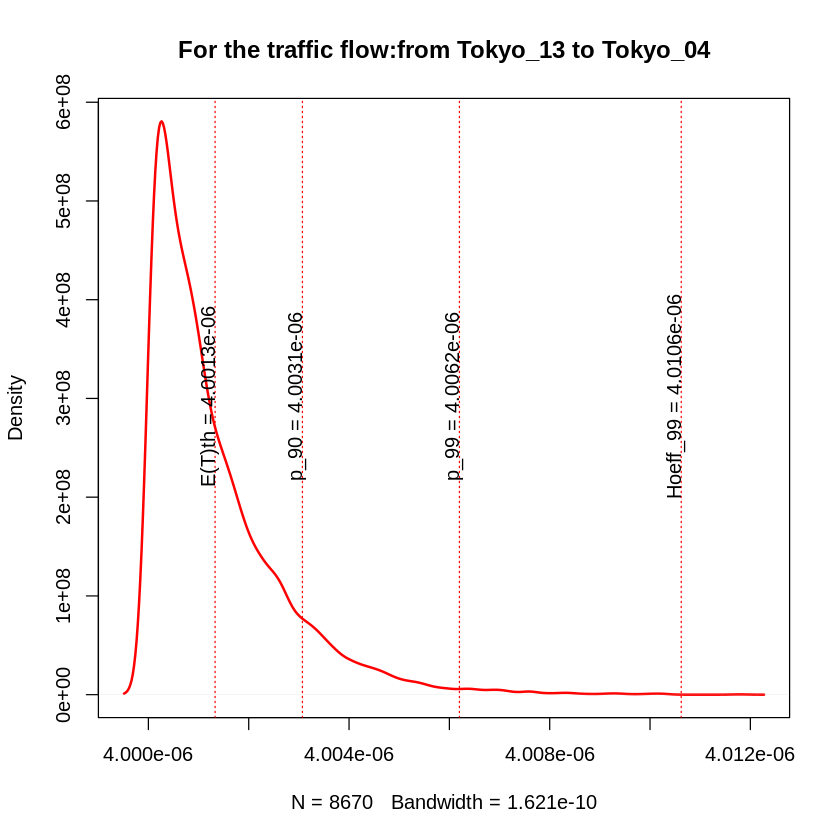

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_14->Tokyo_04
[1] "variance= 1.49035155866838e-18"
[1] "sigma2= 1.22079955712163e-09"
[1] "igraph E(T) = 3.00112082568596e-06"
[1] "simmer E(T) = 3.00116642509122e-06"


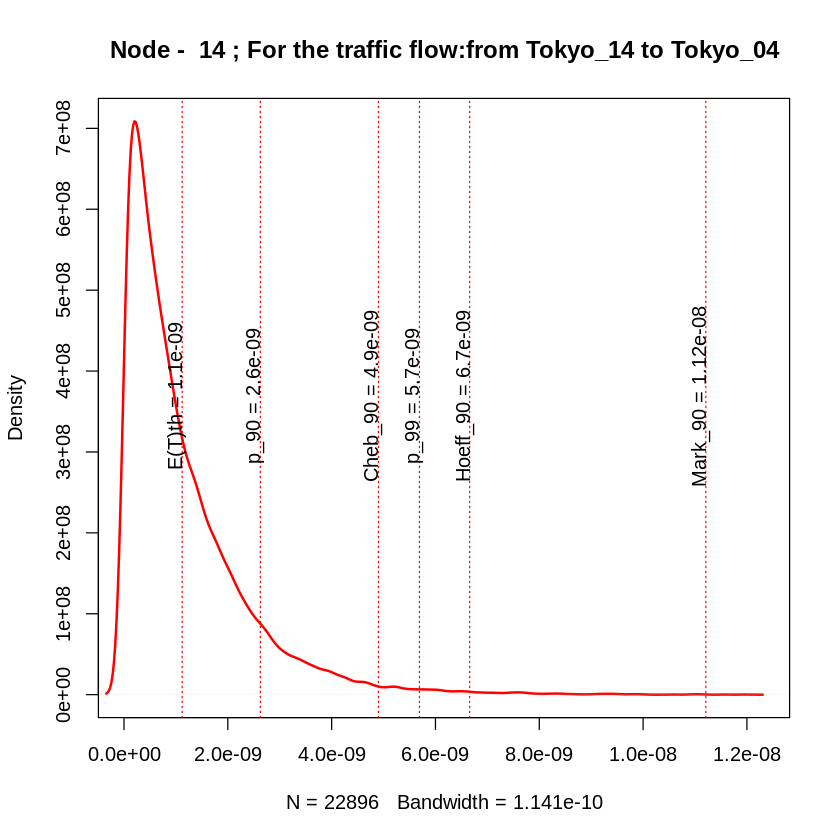

[1] 15
[1] "node_14"
[1] 1702777664
[1] 0.4760329
[1] 696315755
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_15->Tokyo_14
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_14->Tokyo_04
[1] "traffic_Tokyo_15_Tokyo_04_"
[1] 15
[1] "Node -  15 :"
[1] "variance= 1.02476366279869e-16"
[1] "sigma2= 1.01230611121275e-08"
[1] "igraph E(T) = 1.00313896951546e-08"
[1] "simmer E(T) = 1.00874231779302e-08"


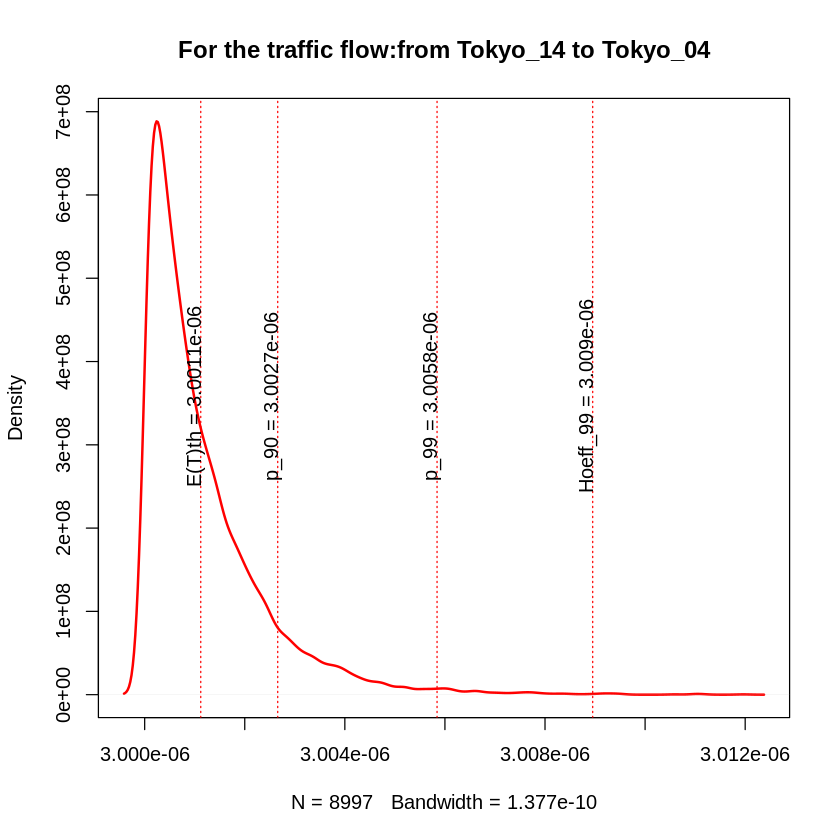

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_15->Tokyo_14
[1] 14
[1] "Node -  14 :"
[1] "variance= 1.29801320314014e-18"
[1] "sigma2= 1.13930382389428e-09"
[1] "igraph E(T) = 1.12082568595555e-09"
[1] "simmer E(T) = 1.12890490342391e-09"


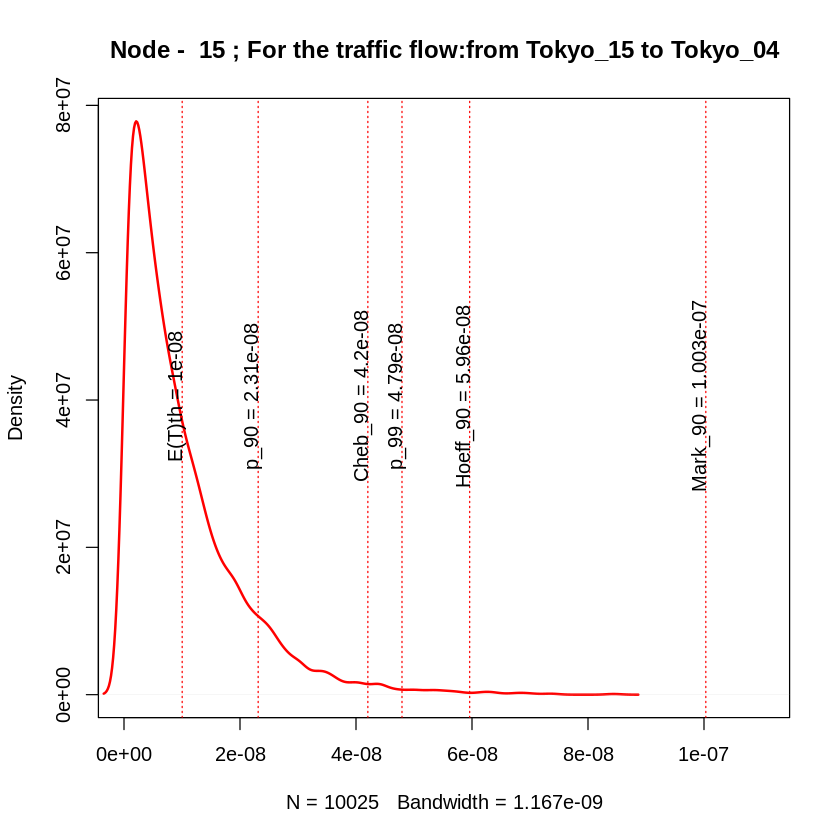

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_14->Tokyo_04
[1] "variance= 1.06491105622872e-16"
[1] "sigma2= 1.03194527772975e-08"
[1] "igraph E(T) = 6.01115221538111e-06"
[1] "simmer E(T) = 6.01135026972902e-06"


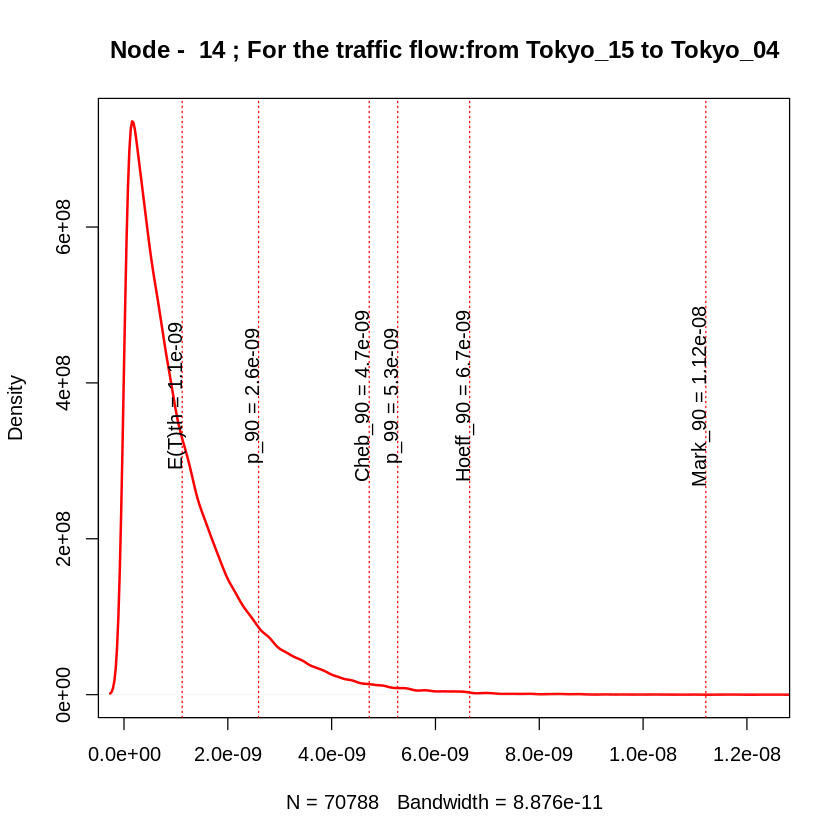

[1] 16
[1] "node_16"
[1] 1543583821
[1] 0.5600998
[1] 631897089
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_16->Tokyo_04
[1] "traffic_Tokyo_16_Tokyo_04_"
[1] 16
[1] "Node -  16 :"
[1] "variance= 2.18418869261341e-18"
[1] "sigma2= 1.47790009561317e-09"
[1] "igraph E(T) = 1.472704459217e-09"
[1] "simmer E(T) = 1.48279733068473e-09"


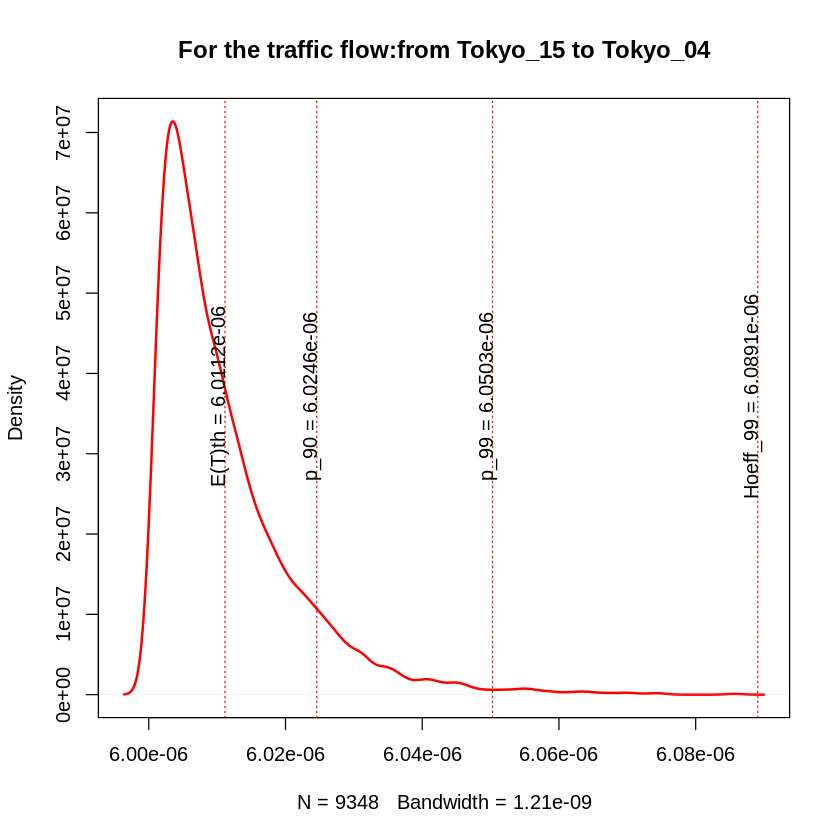

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_16->Tokyo_04
[1] "variance= 2.20773691148533e-18"
[1] "sigma2= 1.48584552073401e-09"
[1] "igraph E(T) = 3.00147270445922e-06"
[1] "simmer E(T) = 3.00149388505142e-06"


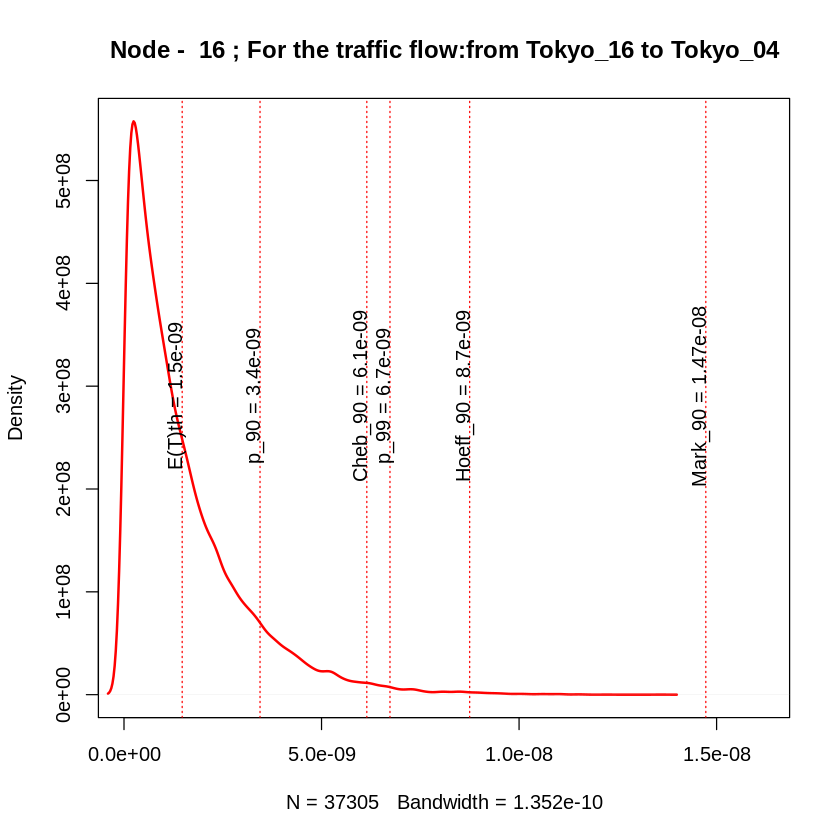

[1] 17
[1] "node_16"
[1] 1543583821
[1] 0.5600998
[1] 630957597
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_17->Tokyo_16
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_16->Tokyo_04
[1] "traffic_Tokyo_17_Tokyo_04_"
[1] 17
[1] "Node -  17 :"
[1] "variance= 4.05170944637299e-17"
[1] "sigma2= 6.36530395690024e-09"
[1] "igraph E(T) = 7.08139234172504e-09"
[1] "simmer E(T) = 6.52907360280217e-09"


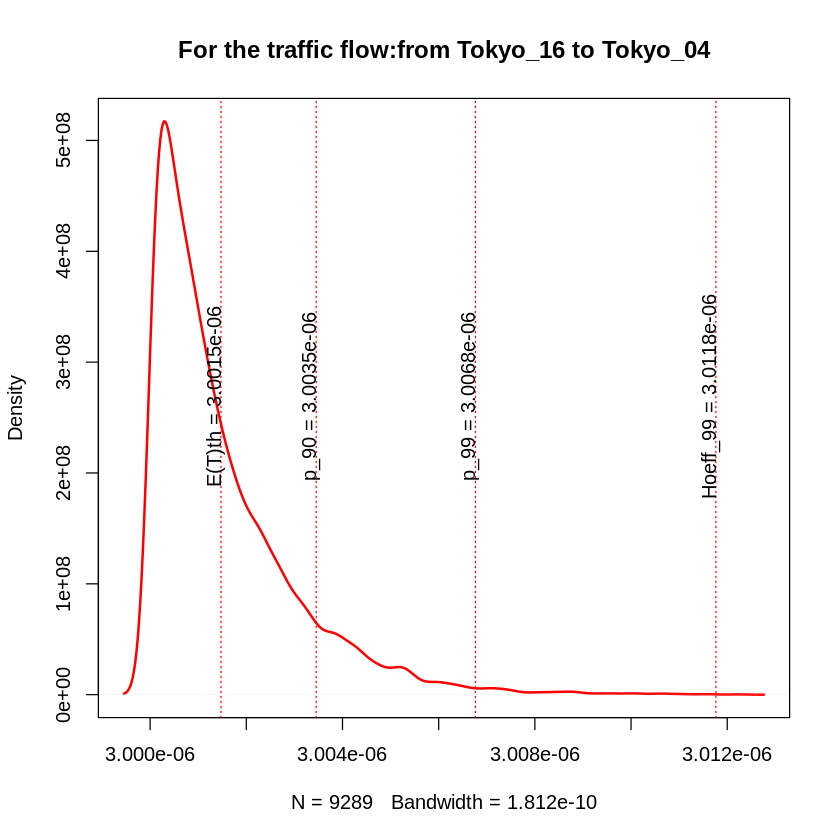

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_17->Tokyo_16
[1] 16
[1] "Node -  16 :"
[1] "variance= 2.05004055239264e-18"
[1] "sigma2= 1.4317962677674e-09"
[1] "igraph E(T) = 1.472704459217e-09"
[1] "simmer E(T) = 1.46924074813494e-09"


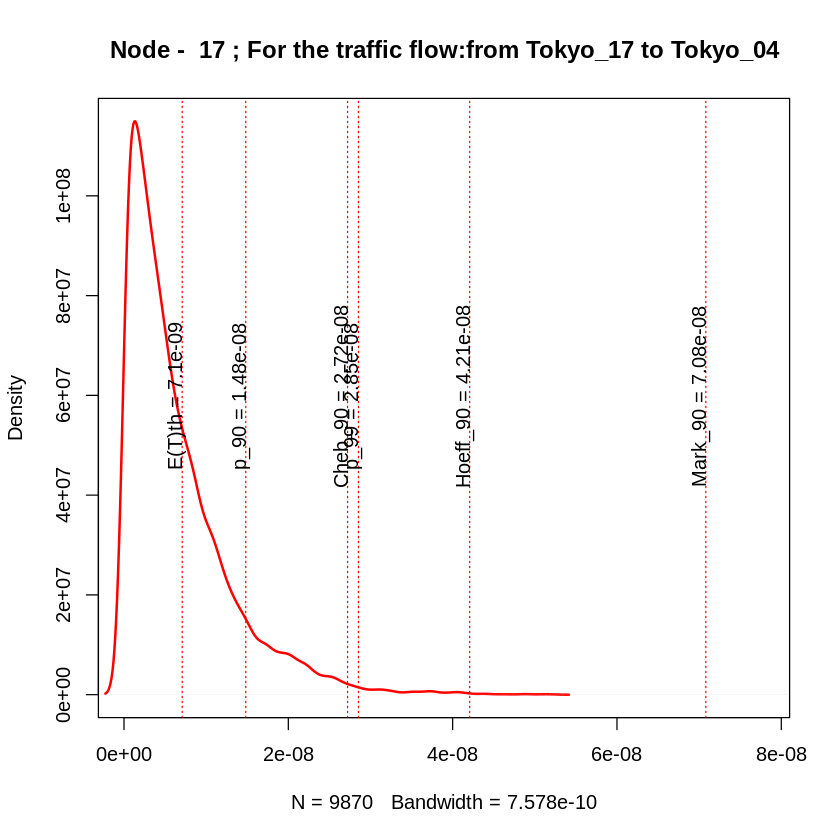

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_16->Tokyo_04
[1] "variance= 4.43753607888175e-17"
[1] "sigma2= 6.66148337750816e-09"
[1] "igraph E(T) = 5.00855409680094e-06"
[1] "simmer E(T) = 5.00809339030585e-06"


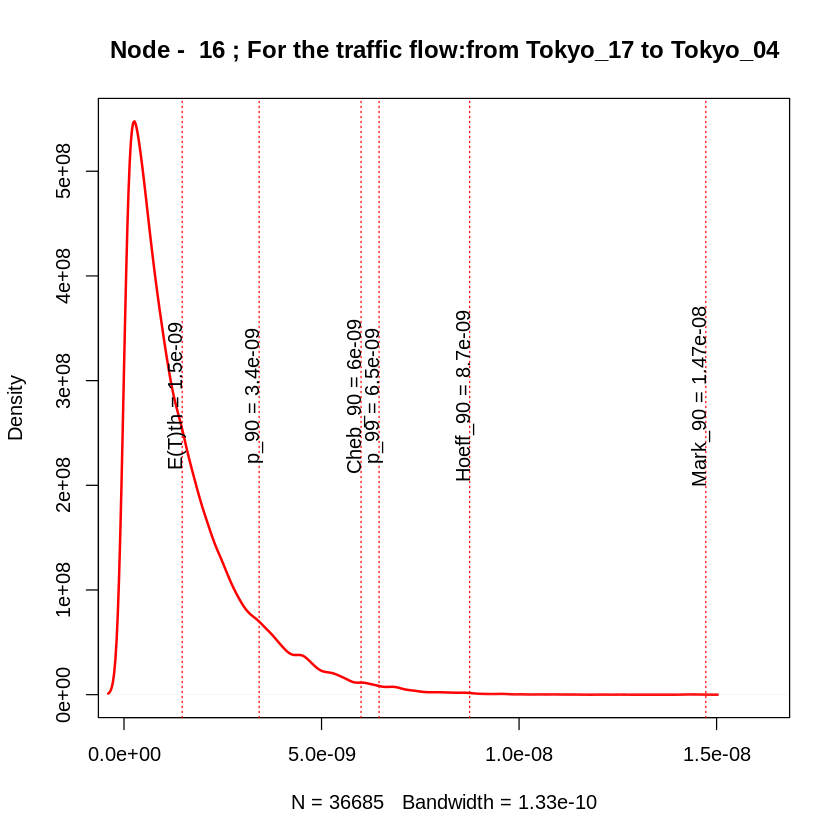

[1] 18
[1] "node_18"
[1] 1113211205
[1] 0.4499837
[1] 104105845
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_18->Tokyo_05
[1] "traffic_Tokyo_18_Tokyo_05_"
[1] 18
[1] "Node -  18 :"
[1] "variance= 2.71189845060569e-18"
[1] "sigma2= 1.64678427567356e-09"
[1] "igraph E(T) = 1.63322809658204e-09"
[1] "simmer E(T) = 1.6568880404829e-09"


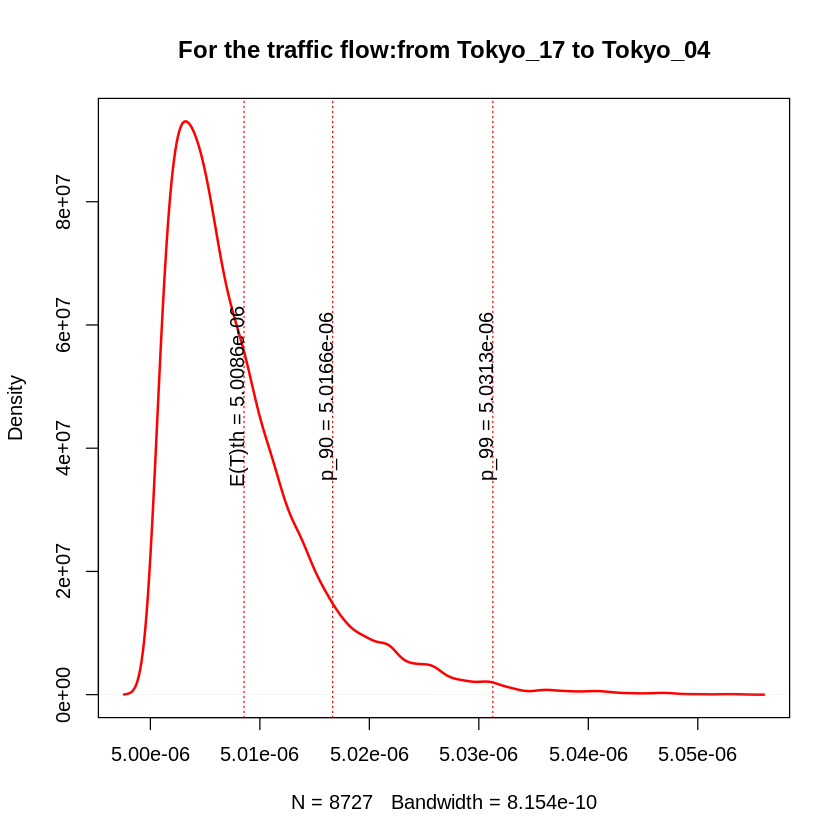

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_18->Tokyo_05
[1] "variance= 2.71782793004681e-18"
[1] "sigma2= 1.64858361330168e-09"
[1] "igraph E(T) = 3.00163322809658e-06"
[1] "simmer E(T) = 3.00166439264152e-06"


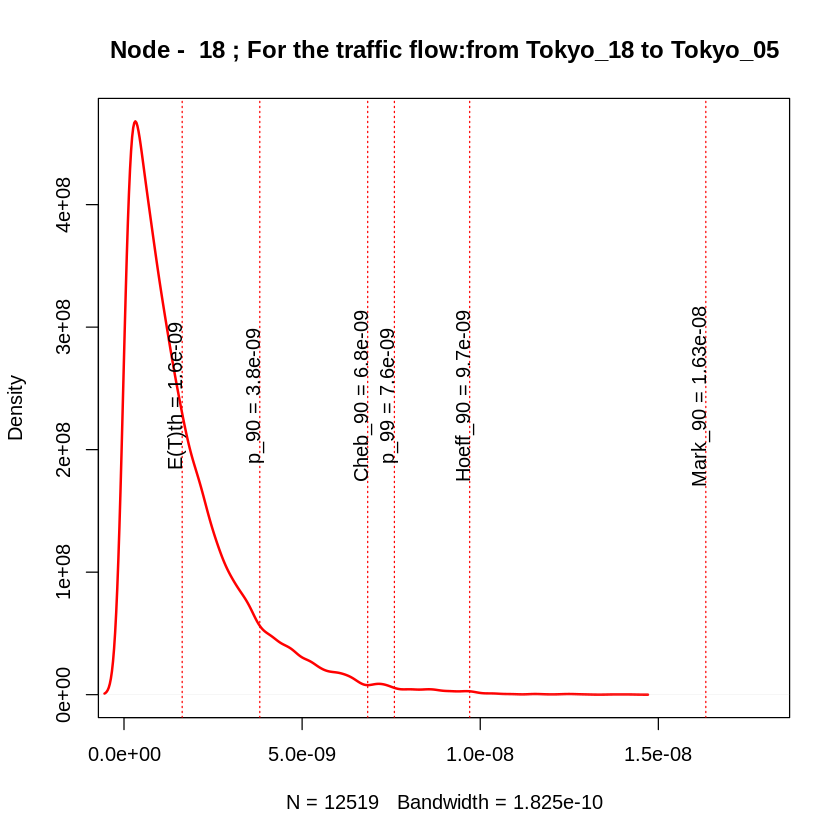

[1] 19
[1] "node_16"
[1] 1543583821
[1] 0.5600998
[1] 466267228
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_19->Tokyo_16
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_16->Tokyo_04
[1] "traffic_Tokyo_19_Tokyo_04_"
[1] 19
[1] "Node -  19 :"
[1] "variance= 1.87253813356334e-17"
[1] "sigma2= 4.32728336669016e-09"
[1] "igraph E(T) = 4.29227227258381e-09"
[1] "simmer E(T) = 4.44427784569077e-09"


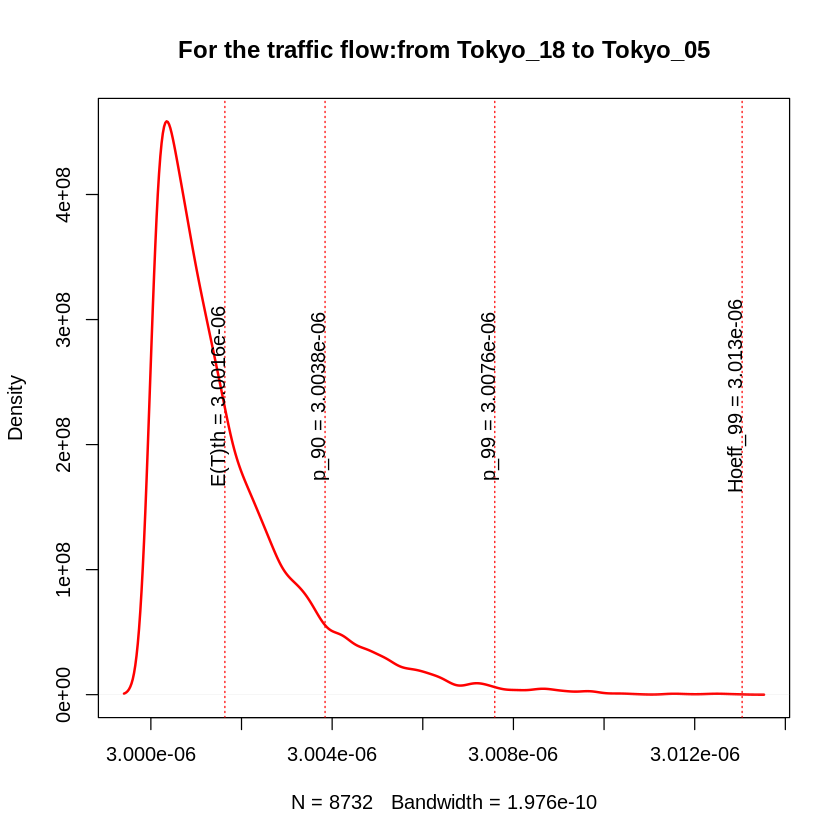

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_19->Tokyo_16
[1] 16
[1] "Node -  16 :"
[1] "variance= 1.76281367364724e-18"
[1] "sigma2= 1.32770993580949e-09"
[1] "igraph E(T) = 1.472704459217e-09"
[1] "simmer E(T) = 1.37677939994278e-09"


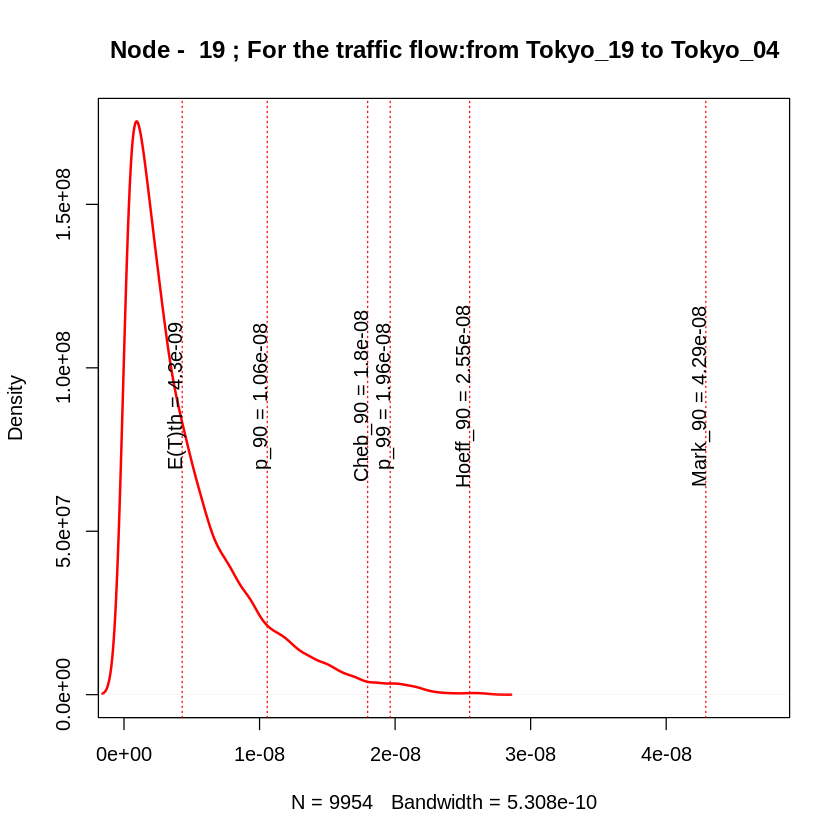

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_16->Tokyo_04
[1] "variance= 2.09071352988673e-17"
[1] "sigma2= 4.57243209887991e-09"
[1] "igraph E(T) = 5.0057649767318e-06"
[1] "simmer E(T) = 5.00593717342036e-06"


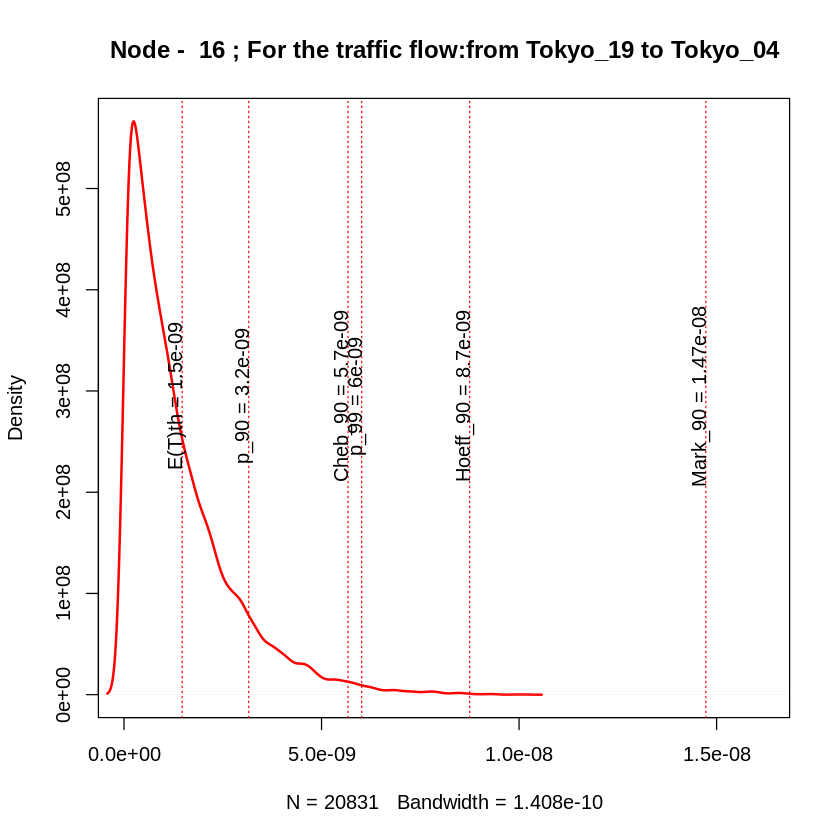

[1] 20
[1] "node_14"
[1] 1702777664
[1] 0.4760329
[1] 468933354
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_20->Tokyo_14
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_14->Tokyo_04
[1] "traffic_Tokyo_20_Tokyo_04_"
[1] 20
[1] "Node -  20 :"
[1] "variance= 2.1038658721066e-17"
[1] "sigma2= 4.58679176778998e-09"
[1] "igraph E(T) = 4.77561344179696e-09"
[1] "simmer E(T) = 4.55819866244199e-09"


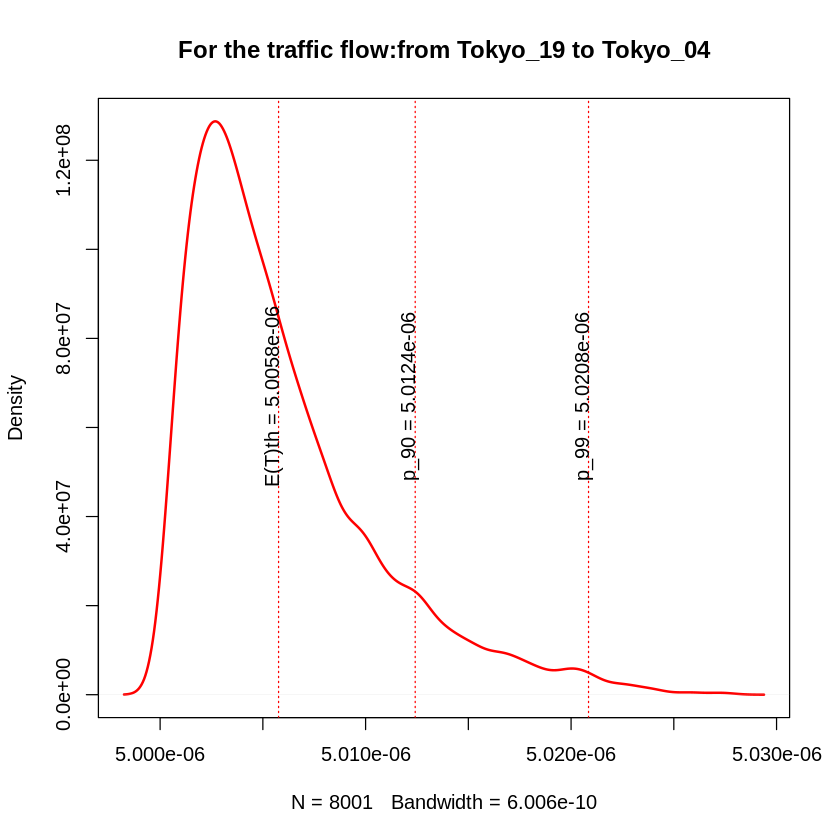

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_20->Tokyo_14
[1] 14
[1] "Node -  14 :"
[1] "variance= 1.16940444044653e-18"
[1] "sigma2= 1.08139005009596e-09"
[1] "igraph E(T) = 1.12082568595555e-09"
[1] "simmer E(T) = 1.08268202488142e-09"


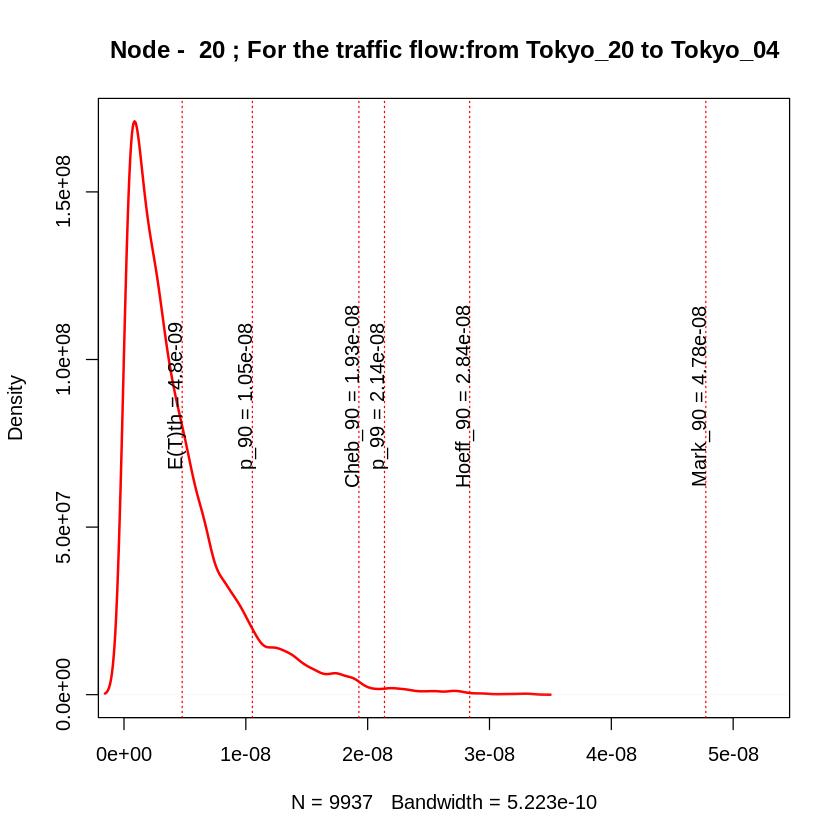

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_14->Tokyo_04
[1] "variance= 2.26688944006028e-17"
[1] "sigma2= 4.76118623880676e-09"
[1] "igraph E(T) = 6.00589643912775e-06"
[1] "simmer E(T) = 6.00568018542024e-06"


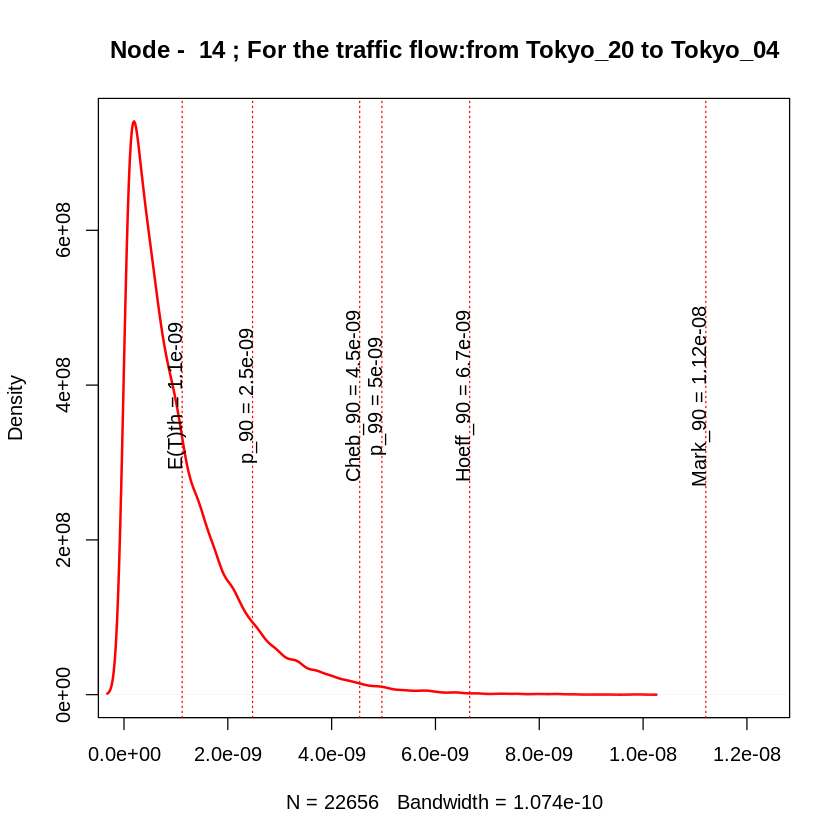

[1] 21
[1] "node_18"
[1] 1113211205
[1] 0.4499837
[1] 396821012
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_21->Tokyo_18
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_18->Tokyo_05
[1] "traffic_Tokyo_21_Tokyo_05_"
[1] 21
[1] "Node -  21 :"
[1] "variance= 6.71153737287151e-17"
[1] "sigma2= 8.19239731267442e-09"
[1] "igraph E(T) = 8.25707496713516e-09"
[1] "simmer E(T) = 8.12982745091088e-09"


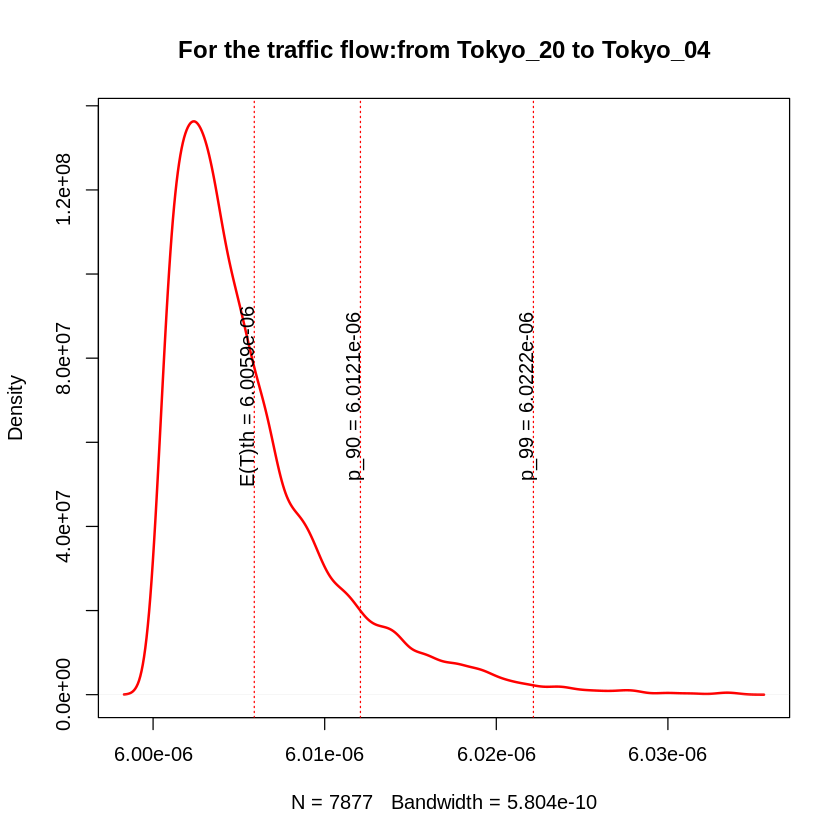

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_21->Tokyo_18
[1] 18
[1] "Node -  18 :"
[1] "variance= 2.69153489642438e-18"
[1] "sigma2= 1.64058980138985e-09"
[1] "igraph E(T) = 1.63322809658204e-09"
[1] "simmer E(T) = 1.63524565512728e-09"


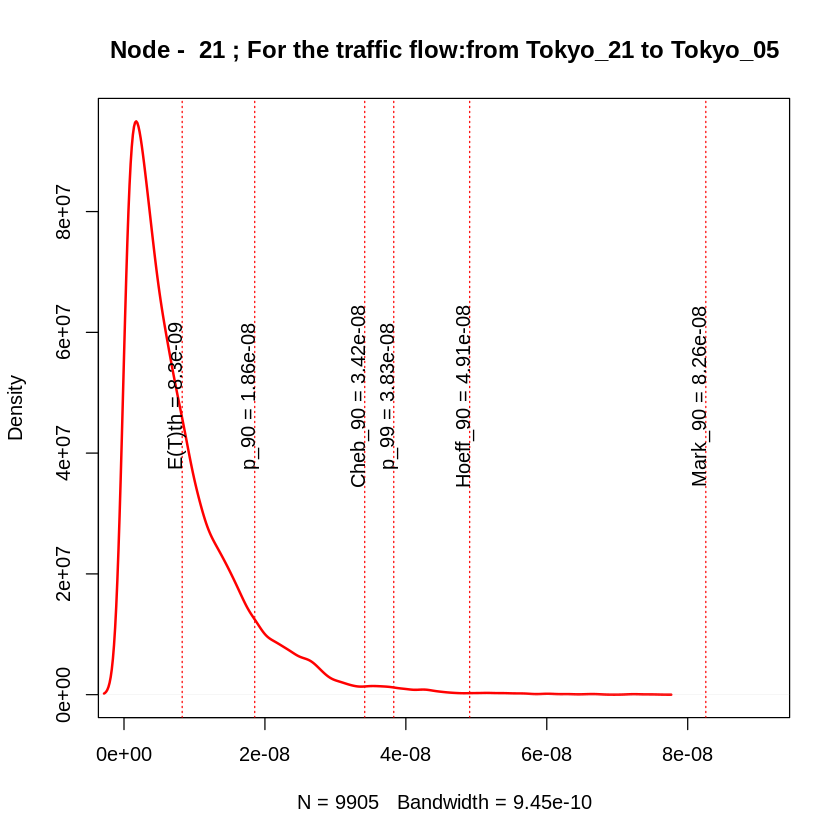

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_18->Tokyo_05
[1] "variance= 6.86772427911135e-17"
[1] "sigma2= 8.28717338970976e-09"
[1] "igraph E(T) = 6.00989030306372e-06"
[1] "simmer E(T) = 6.00970744135136e-06"


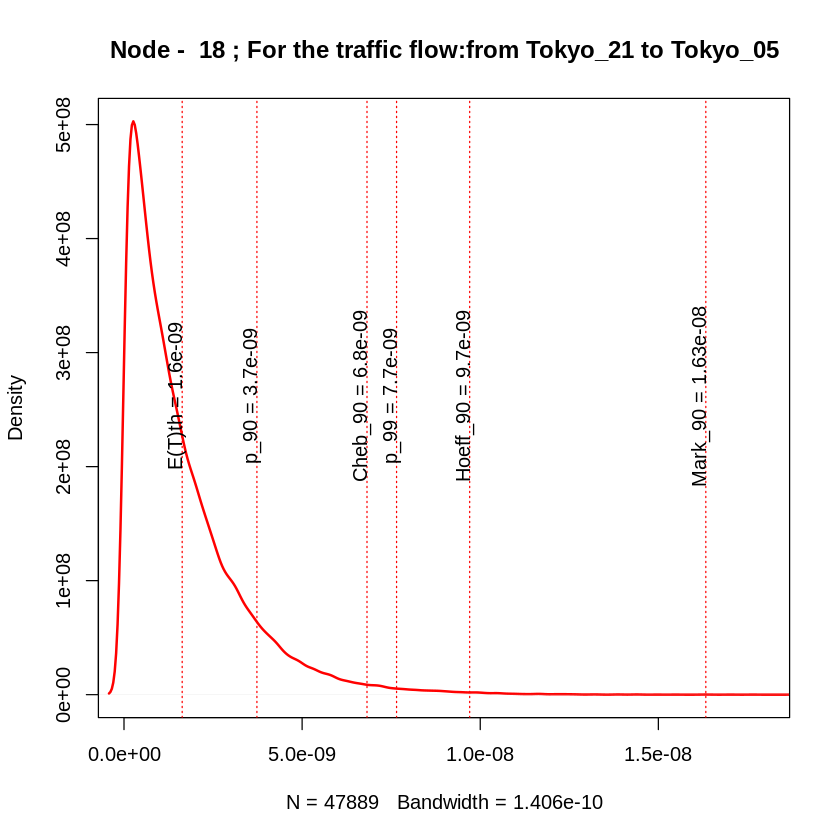

[1] 22
[1] "node_7"
[1] 1667311091
[1] 0.4251512
[1] 312012836
[1] "node_6"
[1] 2525132270
[1] 0.4221433
[1] 669121277
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_22->Tokyo_07
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_07->Tokyo_06
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_06->Tokyo_01
[1] "traffic_Tokyo_22_Tokyo_01_"
[1] 22
[1] "Node -  22 :"
[1] "variance= 8.25172345000759e-18"
[1] "sigma2= 2.87258132173966e-09"
[1] "igraph E(T) = 3.01291852118708e-09"
[1] "simmer E(T) = 2.8990358228181e-09"


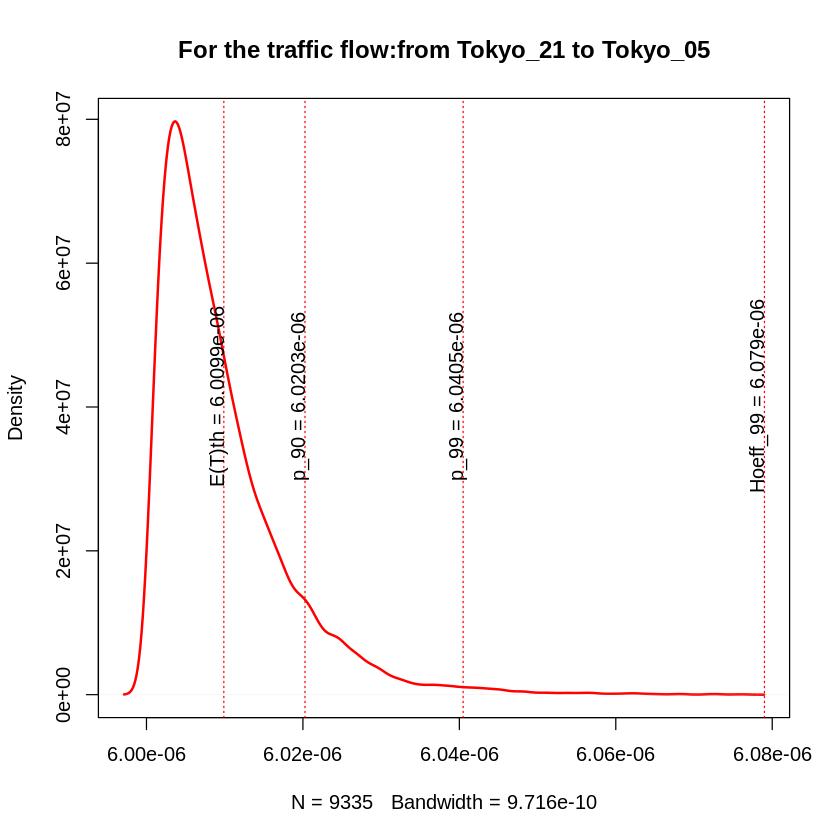

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_22->Tokyo_07
[1] 7
[1] "Node -  7 :"
[1] "variance= 1.08227907826305e-18"
[1] "sigma2= 1.04032642870546e-09"
[1] "igraph E(T) = 1.04334922898788e-09"
[1] "simmer E(T) = 1.03281613780264e-09"


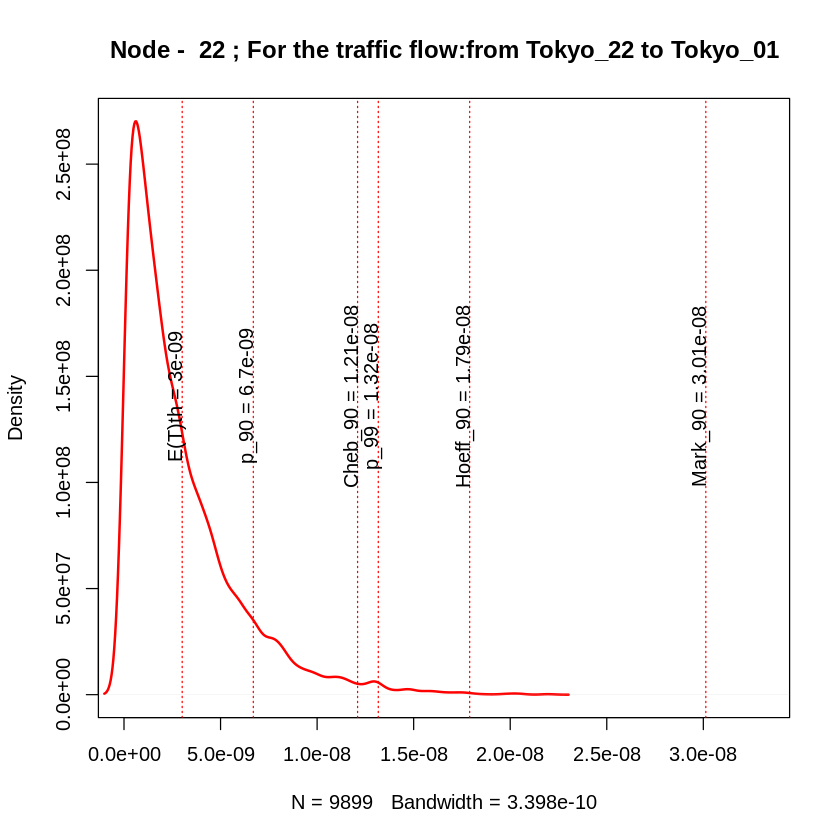

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_07->Tokyo_06
[1] 6
[1] "Node -  6 :"
[1] "variance= 4.16148098740934e-19"
[1] "sigma2= 6.45095418322696e-10"
[1] "igraph E(T) = 6.85323648411598e-10"
[1] "simmer E(T) = 6.41762023117526e-10"


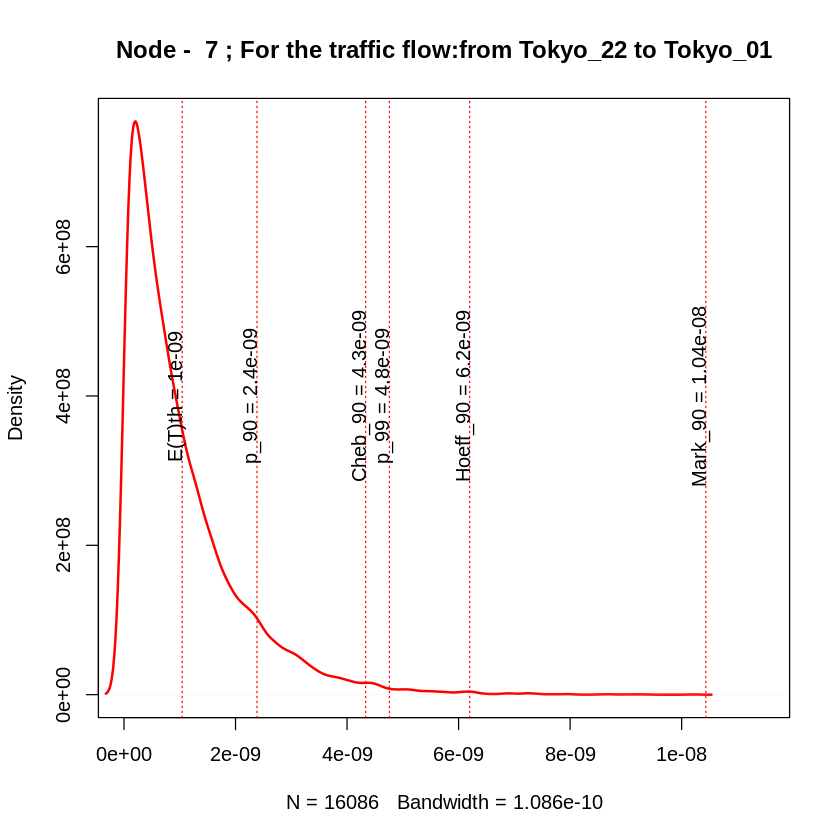

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_06->Tokyo_01
[1] "variance= 8.96096438900146e-18"
[1] "sigma2= 2.99348699496114e-09"
[1] "igraph E(T) = 1.20047415913986e-05"
[1] "simmer E(T) = 1.20045084965741e-05"


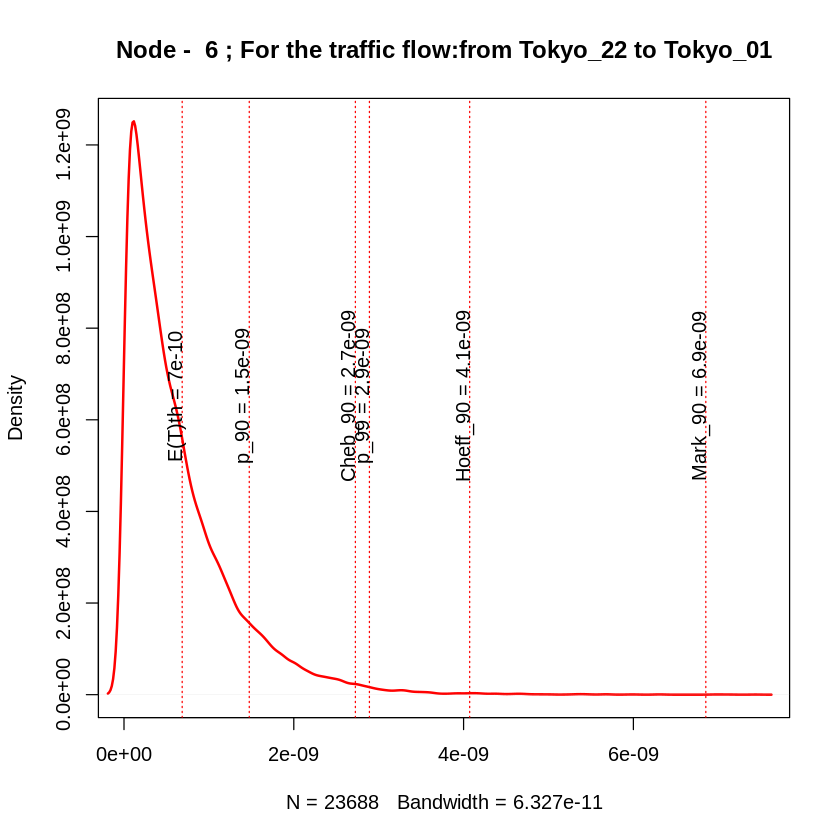

[1] 23
[1] "node_7"
[1] 1667311091
[1] 0.4251512
[1] 594596726
[1] "node_6"
[1] 2525132270
[1] 0.4221433
[1] 951705167
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_23->Tokyo_07
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_07->Tokyo_06
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_06->Tokyo_01
[1] "traffic_Tokyo_23_Tokyo_01_"
[1] 23
[1] "Node -  23 :"
[1] "variance= 1.25830597449577e-16"
[1] "sigma2= 1.12174238330188e-08"
[1] "igraph E(T) = 1.05878478732633e-08"
[1] "simmer E(T) = 1.06330996277448e-08"


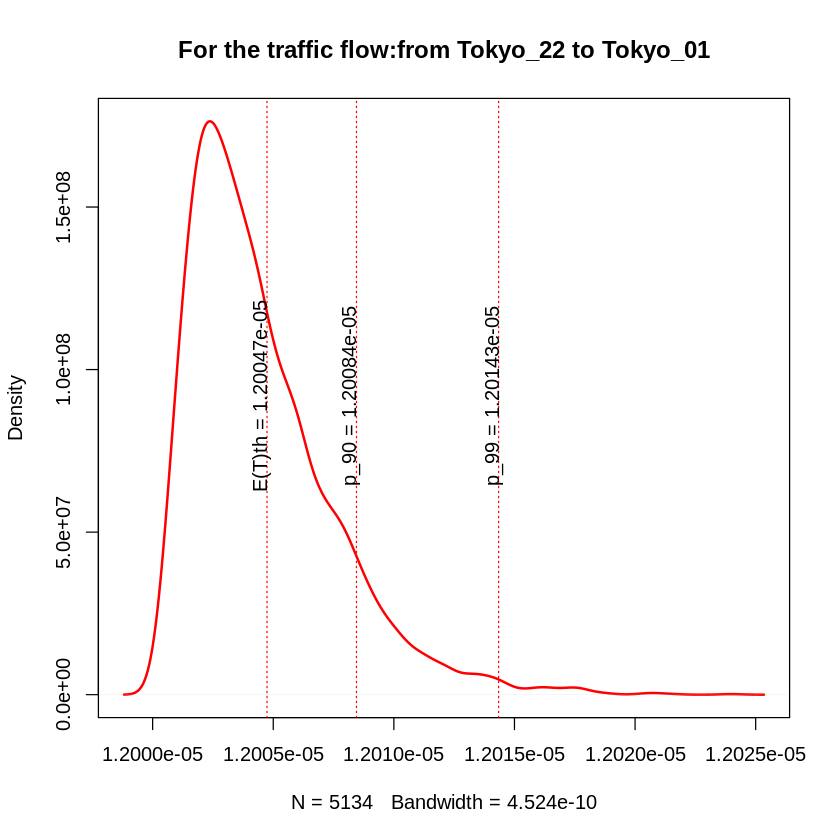

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_23->Tokyo_07
[1] 7
[1] "Node -  7 :"
[1] "variance= 1.02449529392396e-18"
[1] "sigma2= 1.01217354931057e-09"
[1] "igraph E(T) = 1.04334922898788e-09"
[1] "simmer E(T) = 1.03022071843214e-09"


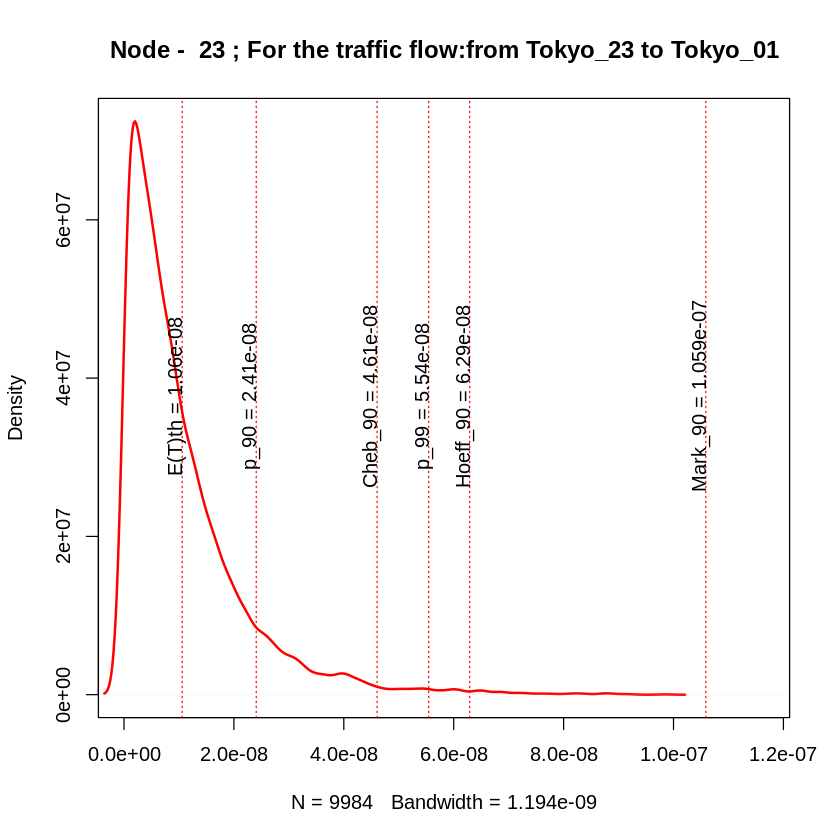

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_07->Tokyo_06
[1] 6
[1] "Node -  6 :"
[1] "variance= 4.75082671767691e-19"
[1] "sigma2= 6.89262411399092e-10"
[1] "igraph E(T) = 6.85323648411598e-10"
[1] "simmer E(T) = 6.85197368351867e-10"


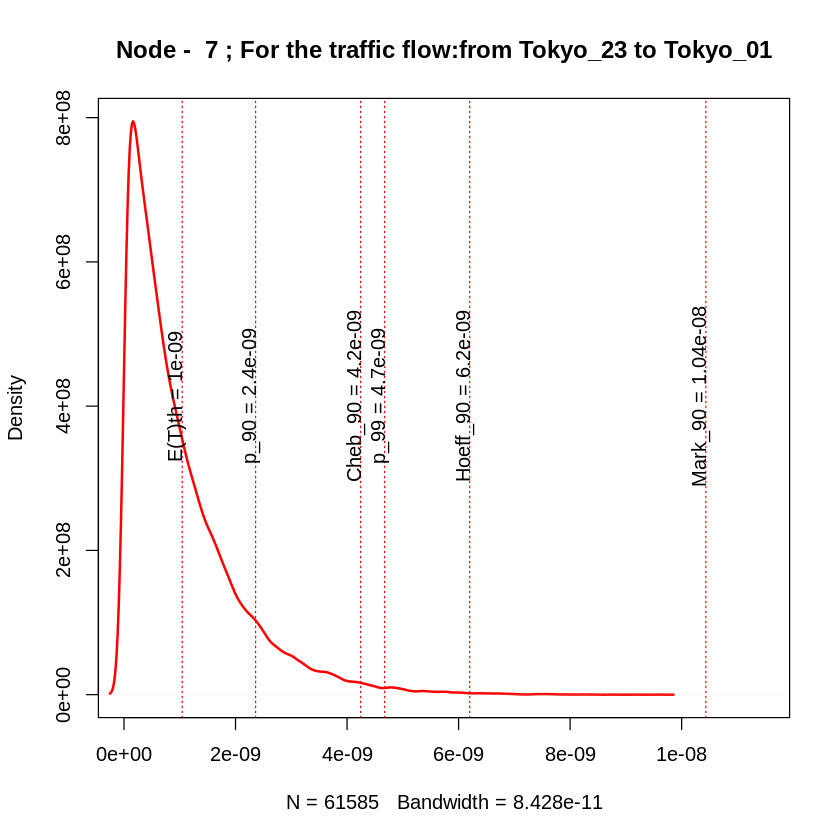

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_06->Tokyo_01
[1] "variance= 1.23268158721103e-16"
[1] "sigma2= 1.11026194531337e-08"
[1] "igraph E(T) = 1.30123165207507e-05"
[1] "simmer E(T) = 1.30121041001695e-05"


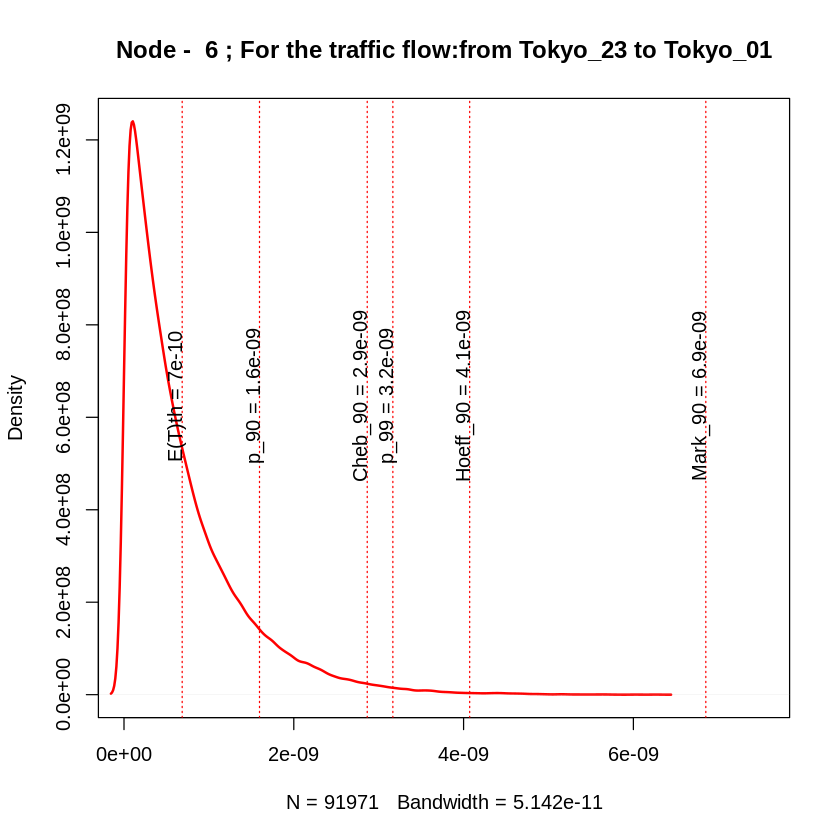

[1] 24
[1] "no info of traffic"
 [1] 0.000000e+00 5.002185e-06 5.002505e-06 0.000000e+00 0.000000e+00
 [6] 4.000697e-06 8.001719e-06 1.000471e-05 1.000478e-05 8.005857e-06
[11] 1.500745e-05 8.011728e-06 4.001328e-06 3.001166e-06 6.011350e-06
[16] 3.001494e-06 5.008093e-06 3.001664e-06 5.005937e-06 6.005680e-06
[21] 6.009707e-06 1.200451e-05 1.301210e-05 0.000000e+00
[1] 25
[1] "node_1"
[1] 165147444
[1] 0.4834118
[1] 48980531
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_02
[1] "traffic_Tokyo_01_Tokyo_02_"
[1] 1
[1] "Node -  1 :"
[1] "variance= 1.45253191645543e-16"
[1] "sigma2= 1.20521032042355e-08"
[1] "igraph E(T) = 1.1721513636851e-08"
[1] "simmer E(T) = 1.20089436435158e-08"


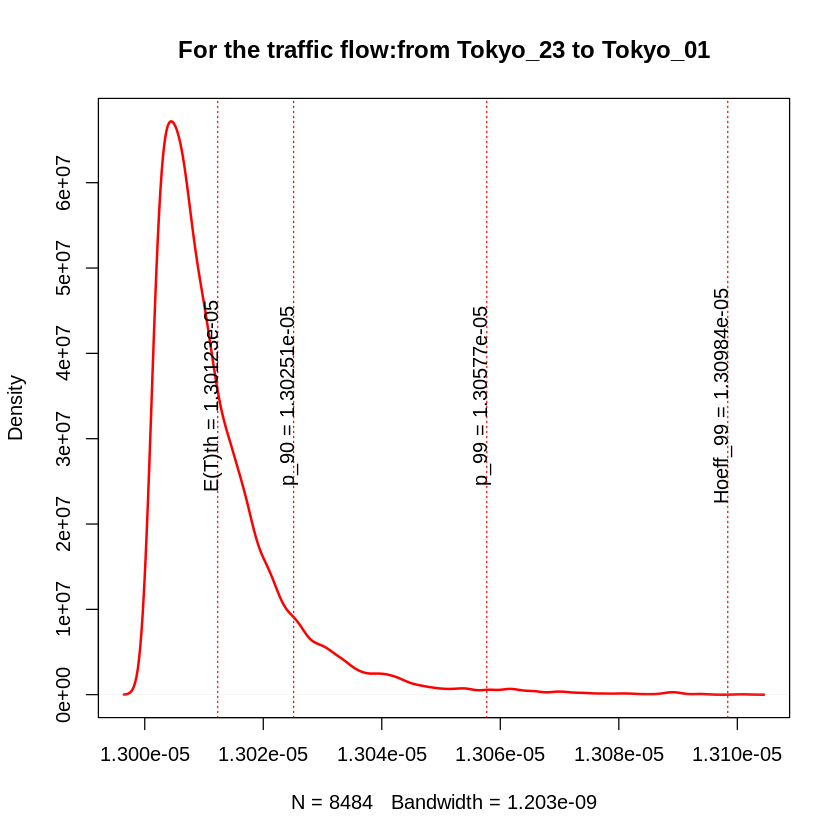

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_02
[1] "variance= 1.48980764144283e-16"
[1] "sigma2= 1.22057676589505e-08"
[1] "igraph E(T) = 5.01172151363685e-06"
[1] "simmer E(T) = 5.01218899869453e-06"


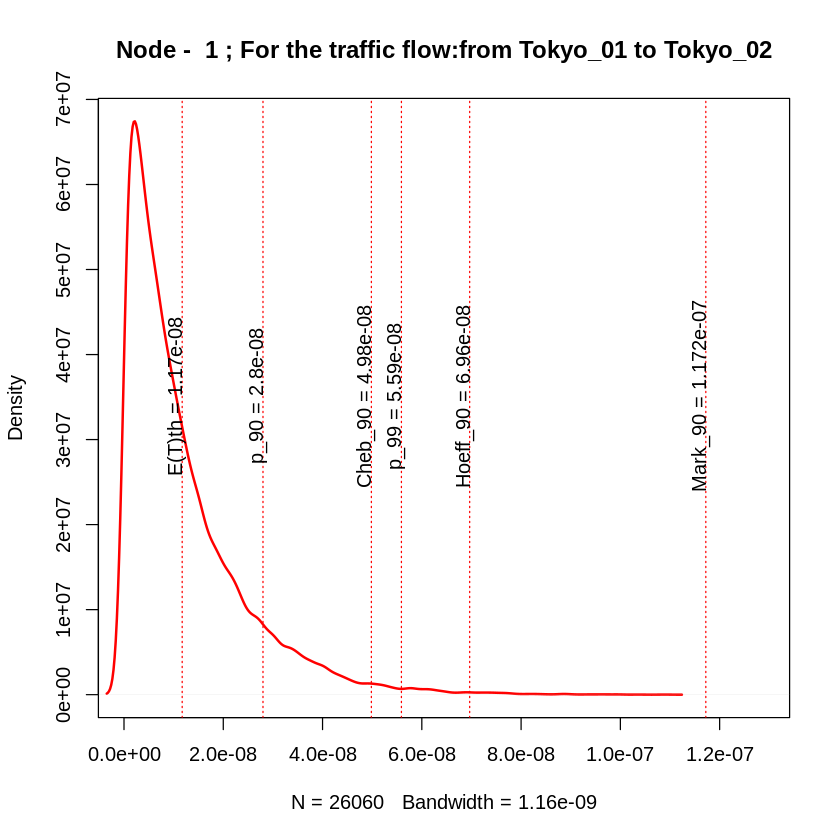

[1] 26
[1] "node_1"
[1] 113880872
[1] 0.4767033
[1] 42720073
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_03
[1] "traffic_Tokyo_01_Tokyo_03_"
[1] 1
[1] "Node -  1 :"
[1] "variance= 2.95784221445761e-16"
[1] "sigma2= 1.71983784539636e-08"
[1] "igraph E(T) = 1.67803585342803e-08"
[1] "simmer E(T) = 1.69901025751887e-08"


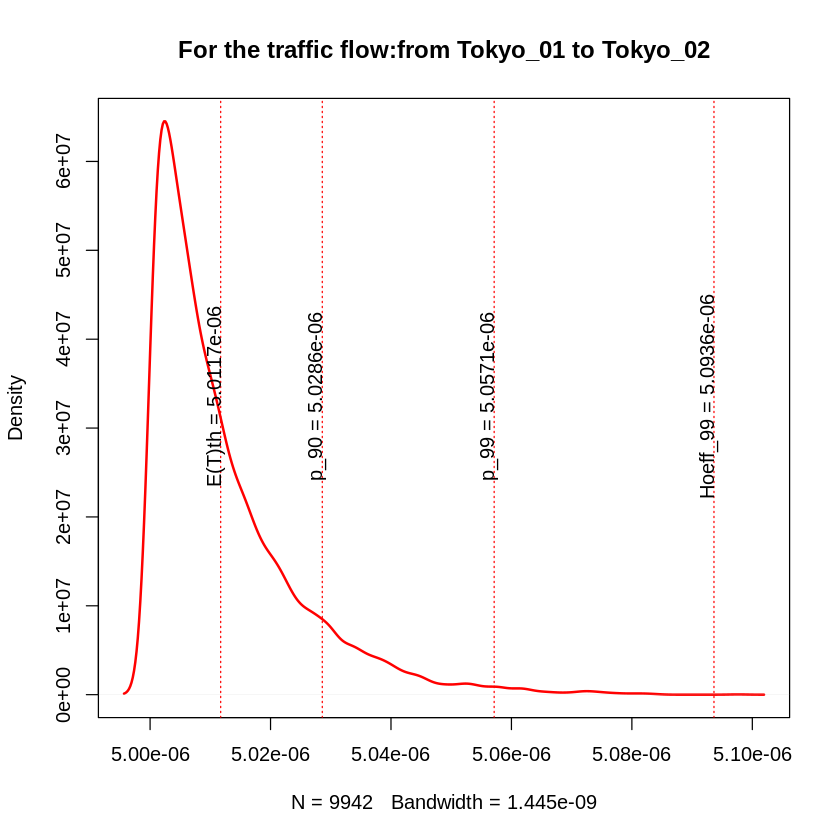

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_03
[1] "variance= 3.06611620960382e-16"
[1] "sigma2= 1.75103289792163e-08"
[1] "igraph E(T) = 5.01678035853428e-06"
[1] "simmer E(T) = 5.01712756257464e-06"


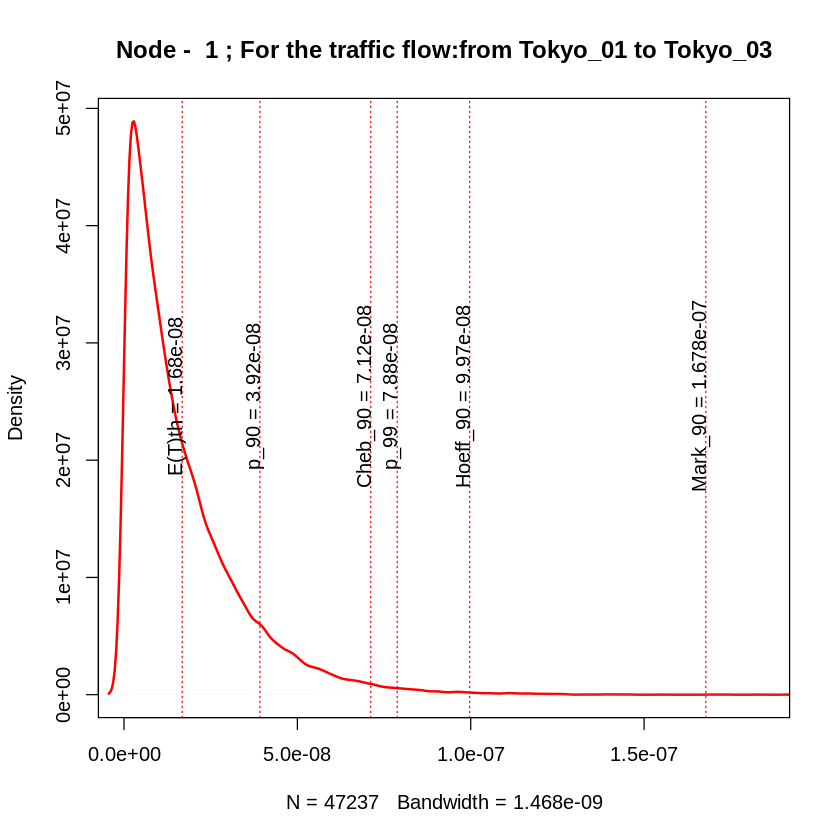

[1] 27
[1] "no info of traffic"
 [1] 0.000000e+00 5.002185e-06 5.002505e-06 0.000000e+00 0.000000e+00
 [6] 4.000697e-06 8.001719e-06 1.000471e-05 1.000478e-05 8.005857e-06
[11] 1.500745e-05 8.011728e-06 4.001328e-06 3.001166e-06 6.011350e-06
[16] 3.001494e-06 5.008093e-06 3.001664e-06 5.005937e-06 6.005680e-06
[21] 6.009707e-06 1.200451e-05 1.301210e-05 0.000000e+00 5.012189e-06
[26] 5.017128e-06 0.000000e+00
[1] 28
[1] "no info of traffic"
 [1] 0.000000e+00 5.002185e-06 5.002505e-06 0.000000e+00 0.000000e+00
 [6] 4.000697e-06 8.001719e-06 1.000471e-05 1.000478e-05 8.005857e-06
[11] 1.500745e-05 8.011728e-06 4.001328e-06 3.001166e-06 6.011350e-06
[16] 3.001494e-06 5.008093e-06 3.001664e-06 5.005937e-06 6.005680e-06
[21] 6.009707e-06 1.200451e-05 1.301210e-05 0.000000e+00 5.012189e-06
[26] 5.017128e-06 0.000000e+00 0.000000e+00
[1] 29
[1] "node_1"
[1] 214710133
[1] 0.4925013
[1] 66066303
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_06
[1] "traffic_Tokyo_01_Tokyo_06_"
[1]

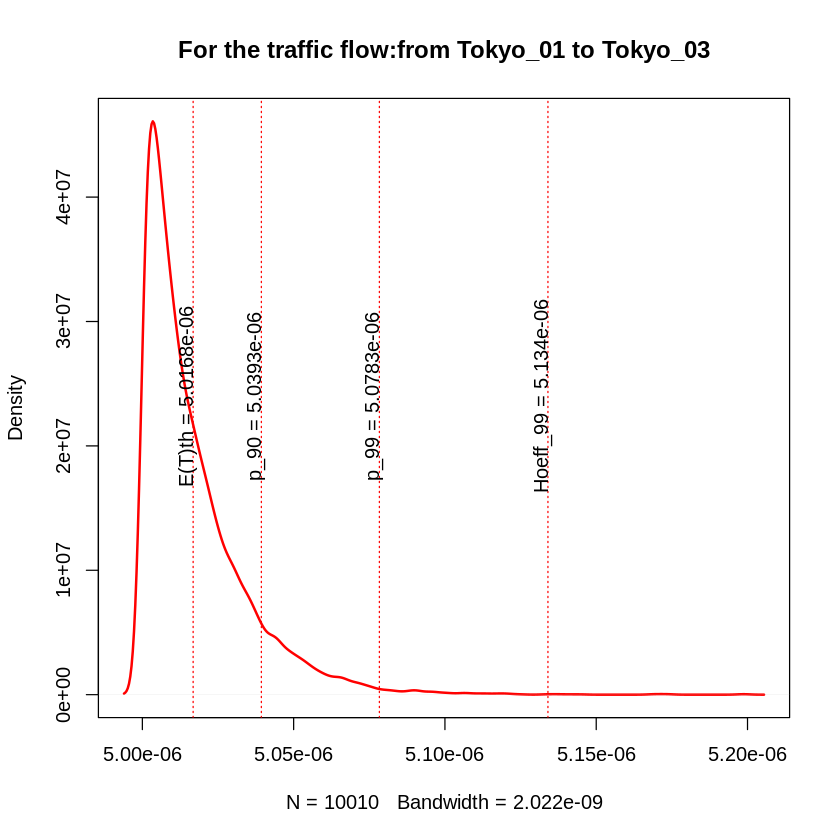

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_06
[1] "variance= 9.54537755808751e-17"
[1] "sigma2= 9.77004480956331e-09"
[1] "igraph E(T) = 4.00917724912672e-06"
[1] "simmer E(T) = 4.00950242017326e-06"


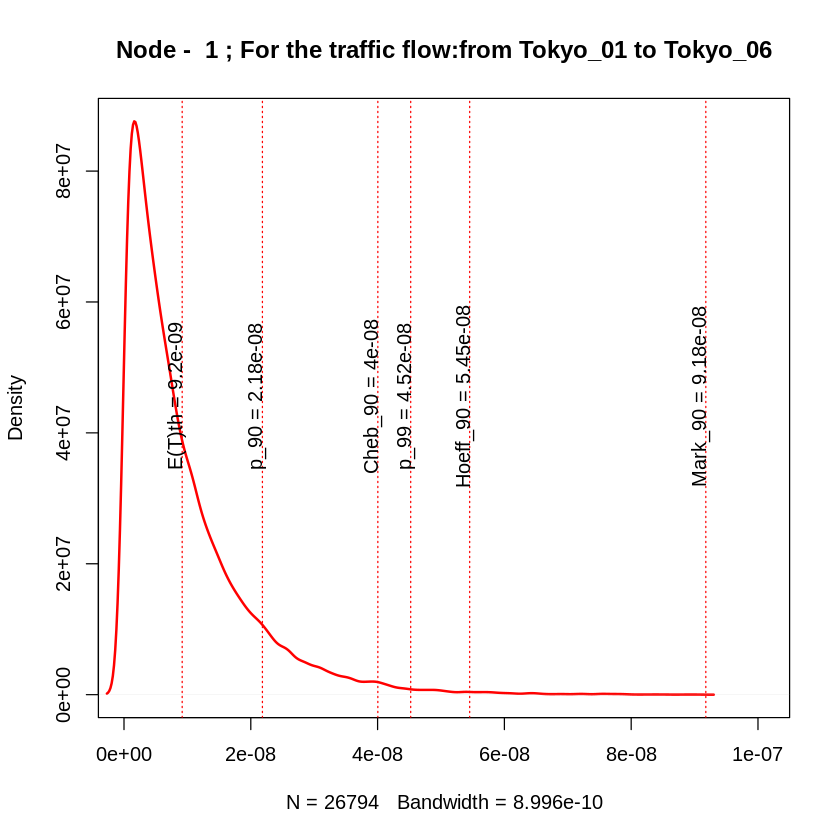

[1] 30
[1] "node_1"
[1] 214710133
[1] 0.4925013
[1] 83772761
[1] "node_6"
[1] 139109649
[1] 0.4749225
[1] 44094045
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_06
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_06->Tokyo_07
[1] "traffic_Tokyo_01_Tokyo_07_"
[1] 1
[1] "Node -  1 :"
[1] "variance= 8.70955314719748e-17"
[1] "sigma2= 9.33249867248717e-09"
[1] "igraph E(T) = 9.17724912671743e-09"
[1] "simmer E(T) = 9.4238290629076e-09"


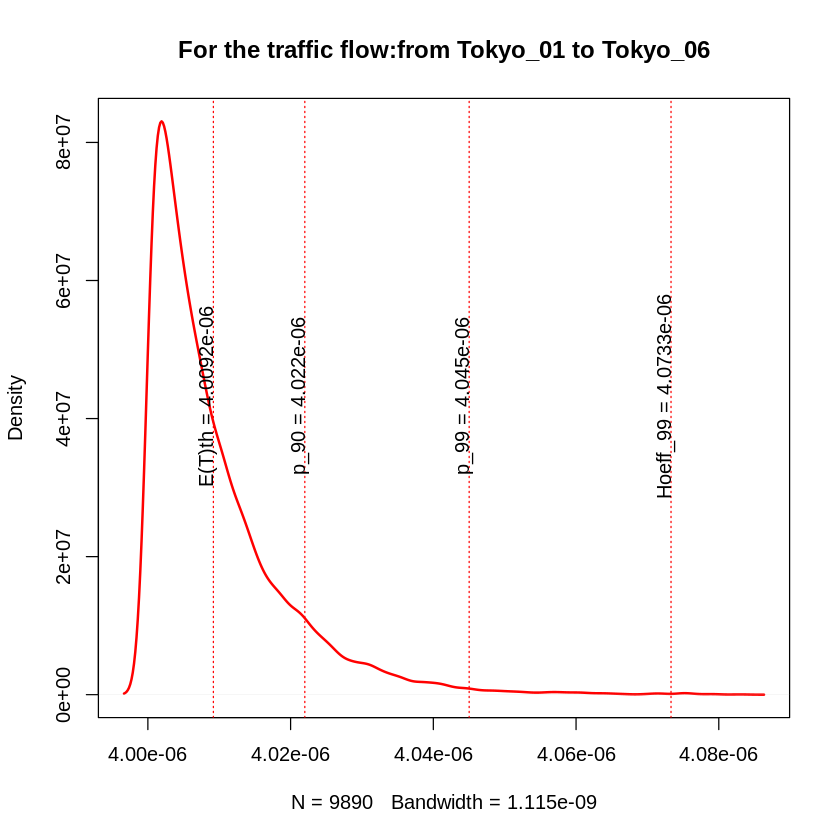

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_06
[1] 6
[1] "Node -  6 :"
[1] "variance= 1.7425529037766e-16"
[1] "sigma2= 1.3200579168266e-08"
[1] "igraph E(T) = 1.36905009844813e-08"
[1] "simmer E(T) = 1.33582202736425e-08"


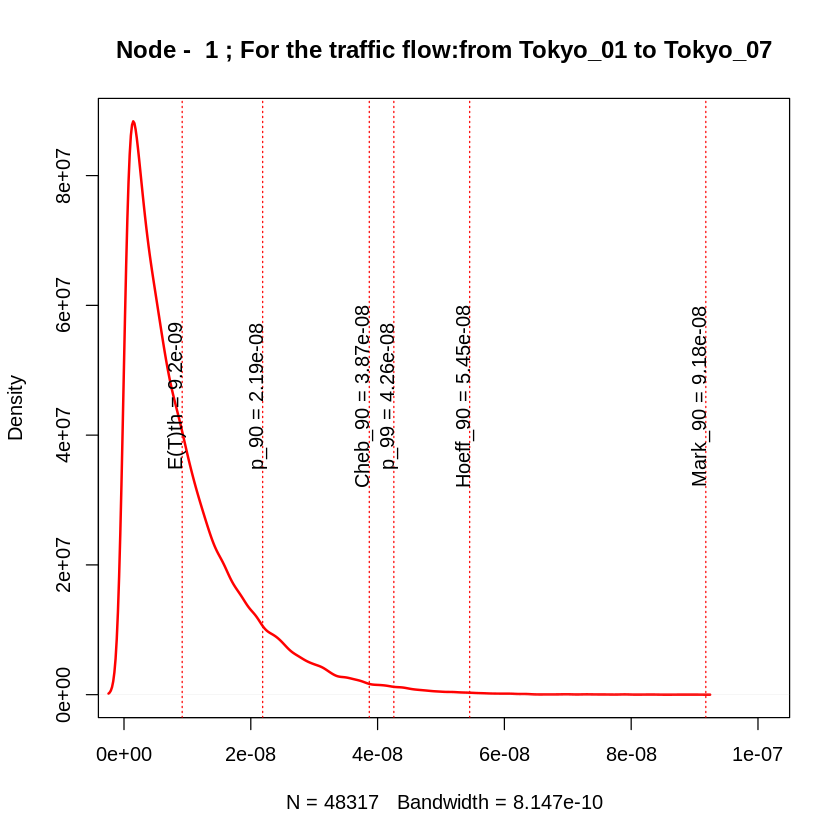

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_06->Tokyo_07
[1] "variance= 2.63358204726347e-16"
[1] "sigma2= 1.62283149071722e-08"
[1] "igraph E(T) = 8.0228677501112e-06"
[1] "simmer E(T) = 8.02240208410097e-06"


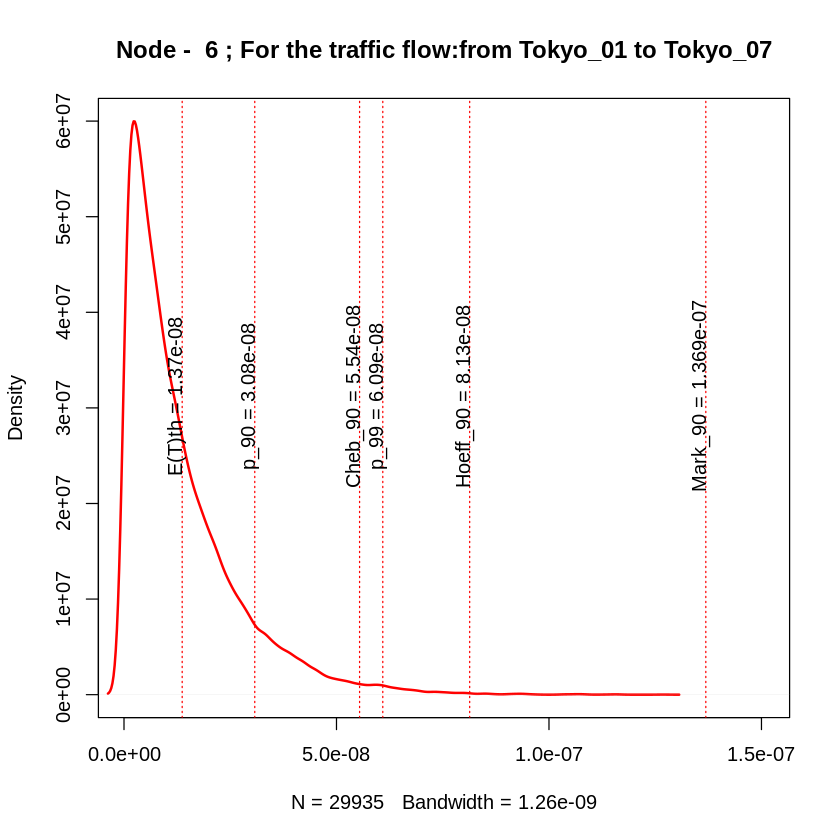

[1] 31
[1] "node_1"
[1] 165147444
[1] 0.4834118
[1] 43549535
[1] "node_2"
[1] 112529308
[1] 0.4352691
[1] 12695835
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_02
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_02->Tokyo_08
[1] "traffic_Tokyo_01_Tokyo_08_"
[1] 1
[1] "Node -  1 :"
[1] "variance= 1.47636912208023e-16"
[1] "sigma2= 1.21505930805053e-08"
[1] "igraph E(T) = 1.1721513636851e-08"
[1] "simmer E(T) = 1.18240251754904e-08"


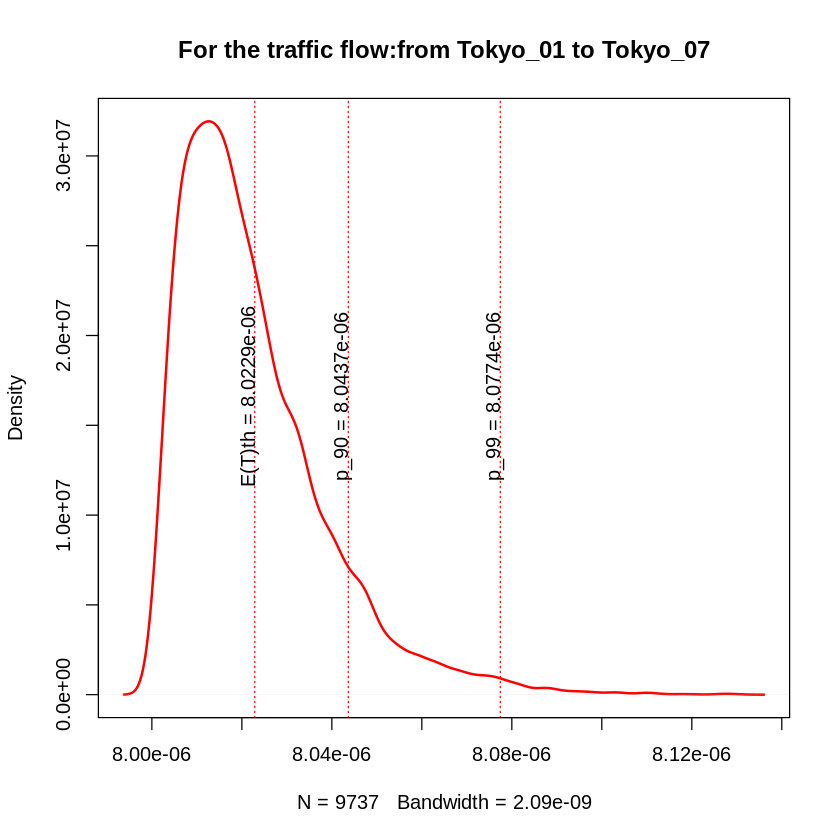

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_02
[1] 2
[1] "Node -  2 :"
[1] "variance= 2.95361639767051e-16"
[1] "sigma2= 1.71860885534507e-08"
[1] "igraph E(T) = 1.57359439796034e-08"
[1] "simmer E(T) = 1.62032720236504e-08"


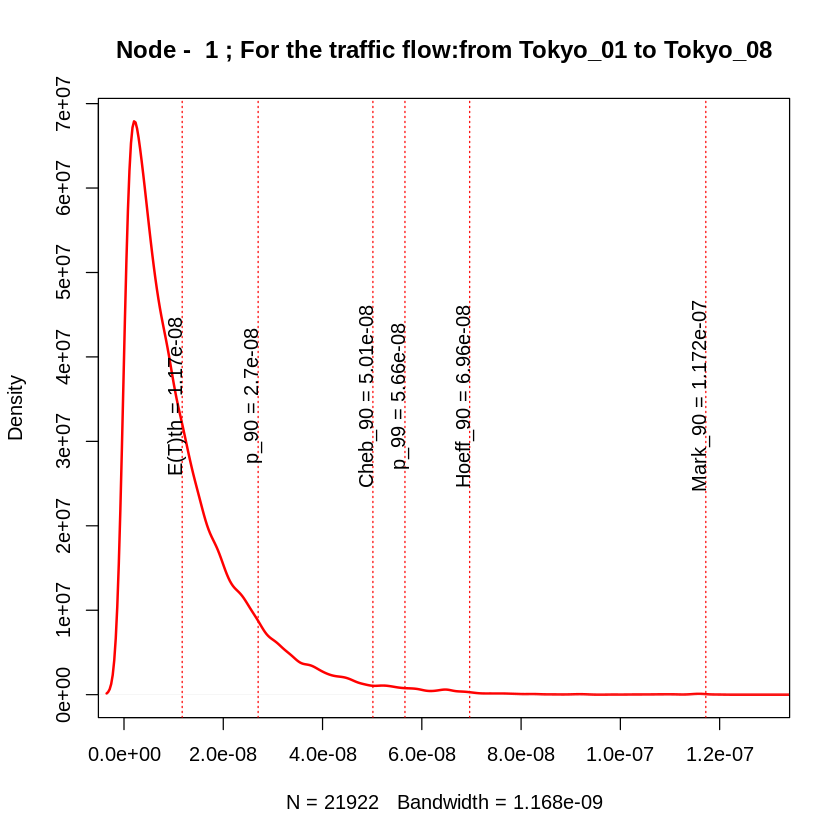

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_02->Tokyo_08
[1] "variance= 4.53659884386397e-16"
[1] "sigma2= 2.12992930489816e-08"
[1] "igraph E(T) = 1.00274574576165e-05"
[1] "simmer E(T) = 1.00281712282156e-05"


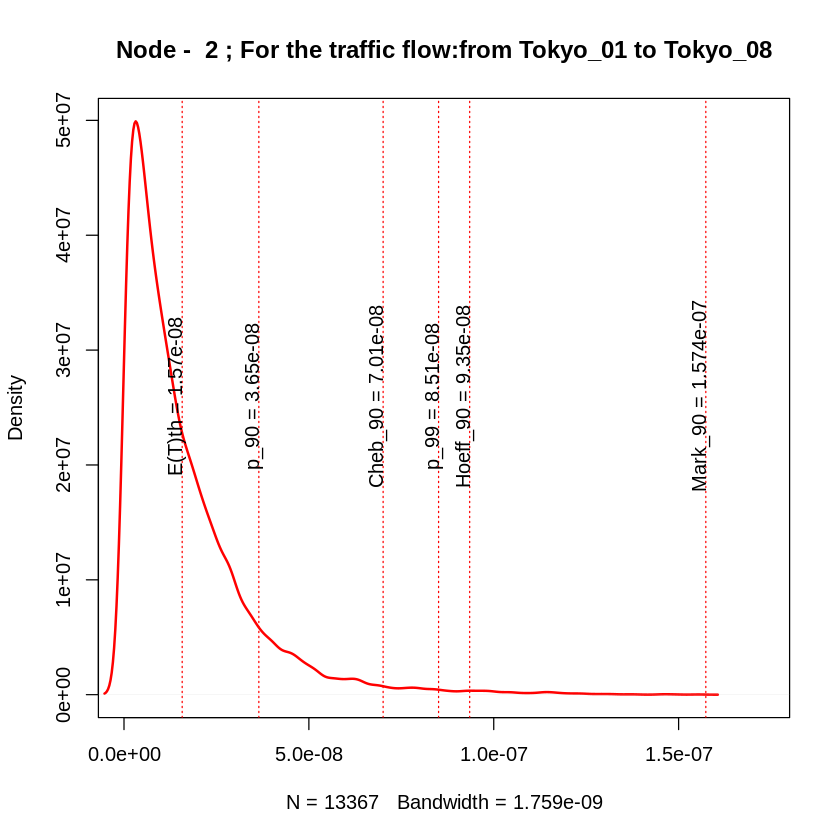

[1] 32
[1] "node_1"
[1] 113880872
[1] 0.4767033
[1] 48244172
[1] "node_3"
[1] 87430957
[1] 0.488615
[1] 36676856
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_03
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_03->Tokyo_09
[1] "traffic_Tokyo_01_Tokyo_09_"
[1] 1
[1] "Node -  1 :"
[1] "variance= 2.9017607655293e-16"
[1] "sigma2= 1.70345553670452e-08"
[1] "igraph E(T) = 1.67803585342803e-08"
[1] "simmer E(T) = 1.67230678177098e-08"


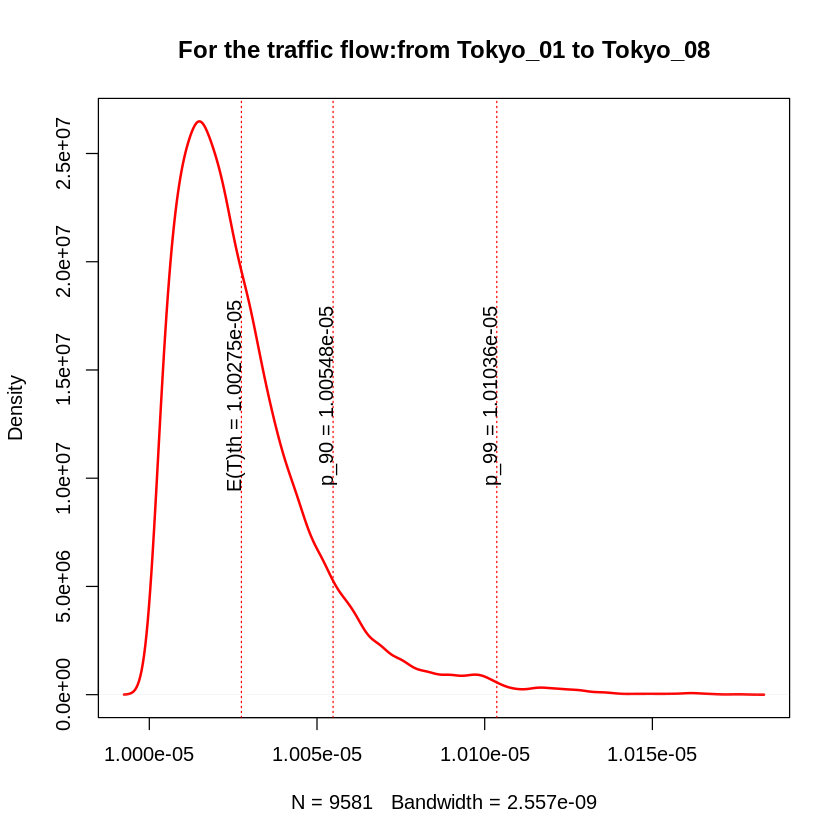

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_03
[1] 3
[1] "Node -  3 :"
[1] "variance= 4.92896634441866e-16"
[1] "sigma2= 2.22012755138498e-08"
[1] "igraph E(T) = 2.23659190076199e-08"
[1] "simmer E(T) = 2.23088676895662e-08"


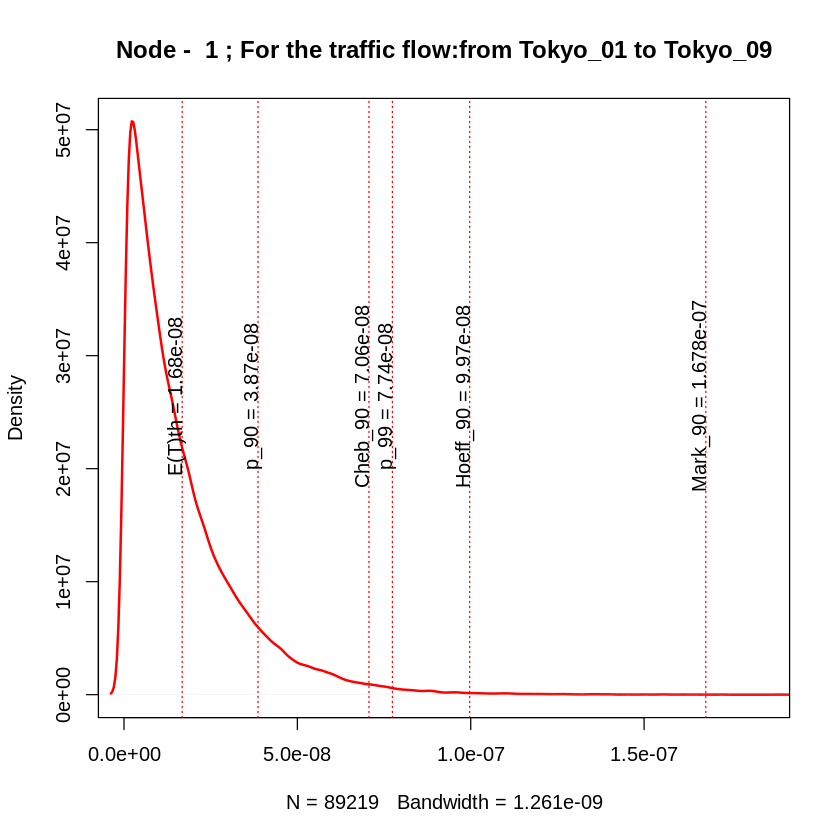

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_03->Tokyo_09
[1] "variance= 7.73888390395783e-16"
[1] "sigma2= 2.78188495519815e-08"
[1] "igraph E(T) = 1.00391462775419e-05"
[1] "simmer E(T) = 1.00389674353415e-05"


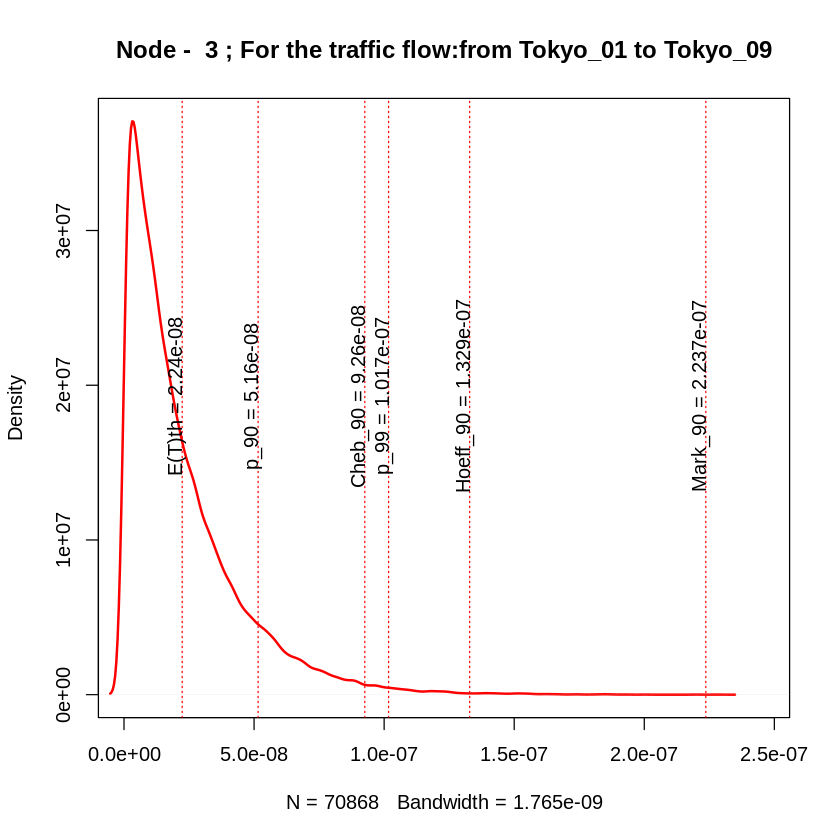

[1] 33
[1] "node_4"
[1] 159611404
[1] 0.5073199
[1] 42223525
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_13
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_13->Tokyo_10
[1] "traffic_Tokyo_04_Tokyo_10_"
[1] 4
[1] "Node -  4 :"
[1] "variance= 1.71692671491766e-16"
[1] "sigma2= 1.31031550205195e-08"
[1] "igraph E(T) = 1.27166003287417e-08"
[1] "simmer E(T) = 1.30640263760283e-08"


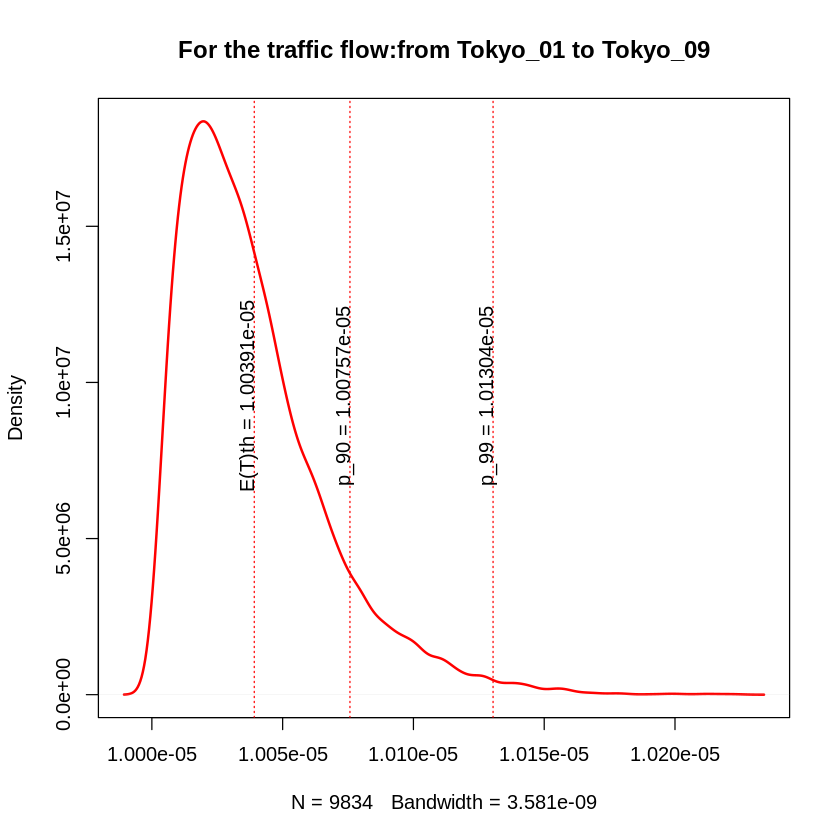

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_13
[1] 13
[1] "Node -  13 :"
[1] "variance= 3.90075647411381e-16"
[1] "sigma2= 1.97503328430531e-08"
[1] "igraph E(T) = 2.0278889329559e-08"
[1] "simmer E(T) = 1.97237433888691e-08"


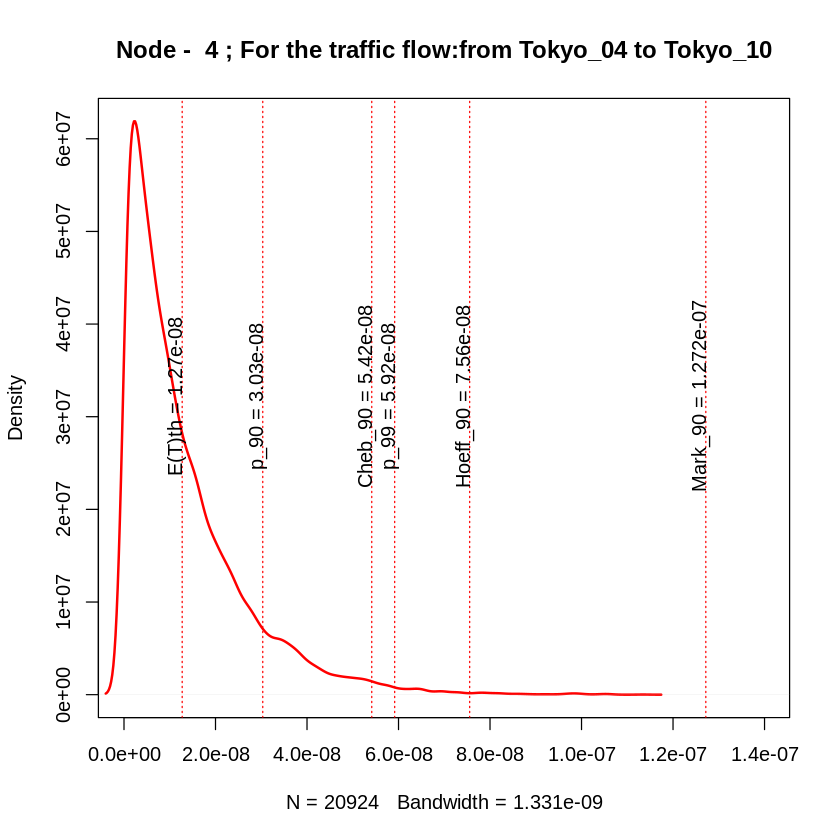

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_13->Tokyo_10
[1] "variance= 5.77704441835366e-16"
[1] "sigma2= 2.40354829748721e-08"
[1] "igraph E(T) = 8.0329954896583e-06"
[1] "simmer E(T) = 8.03289975211751e-06"


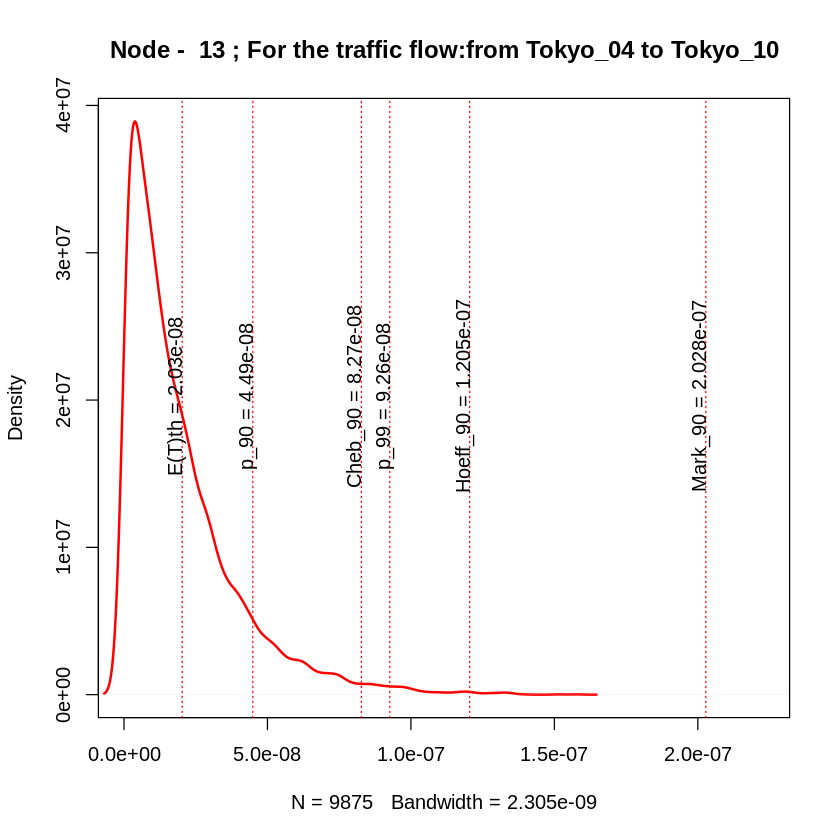

[1] 34
[1] "node_1"
[1] 113880872
[1] 0.4767033
[1] 17610533
[1] "node_3"
[1] 87430957
[1] 0.488615
[1] 6043217
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_03
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_03->Tokyo_09
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_09->Tokyo_11
[1] "traffic_Tokyo_01_Tokyo_11_"
[1] 1
[1] "Node -  1 :"
[1] "variance= 2.76810082493377e-16"
[1] "sigma2= 1.66376104802756e-08"
[1] "igraph E(T) = 1.67803585342803e-08"
[1] "simmer E(T) = 1.68516153367445e-08"


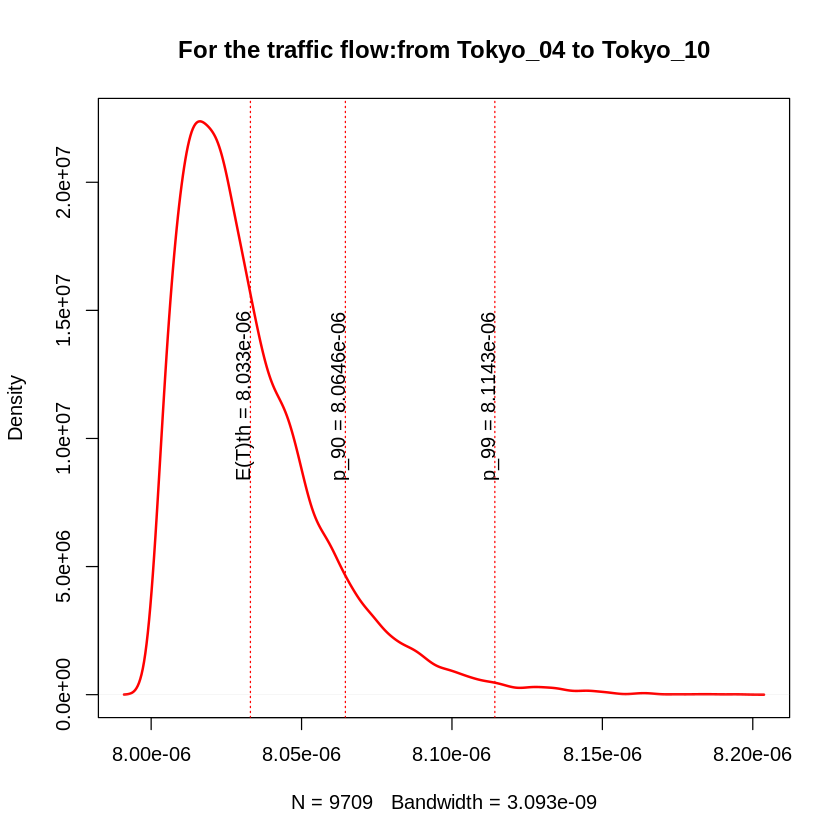

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_03
[1] 3
[1] "Node -  3 :"
[1] "variance= 5.17748842787669e-16"
[1] "sigma2= 2.27540950773189e-08"
[1] "igraph E(T) = 2.23659190076199e-08"
[1] "simmer E(T) = 2.30149796020499e-08"


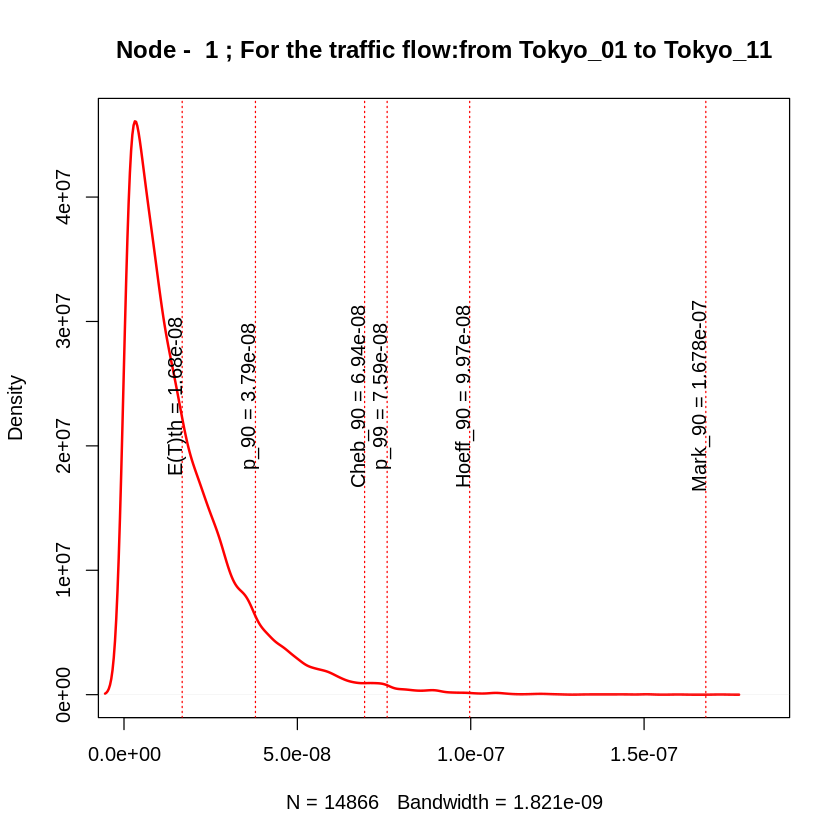

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_03->Tokyo_09
[1] 9
[1] "Node -  9 :"
[1] "variance= 6.11268709456765e-16"
[1] "sigma2= 2.47238490016576e-08"
[1] "igraph E(T) = 2.55151543376646e-08"
[1] "simmer E(T) = 2.52456740478529e-08"


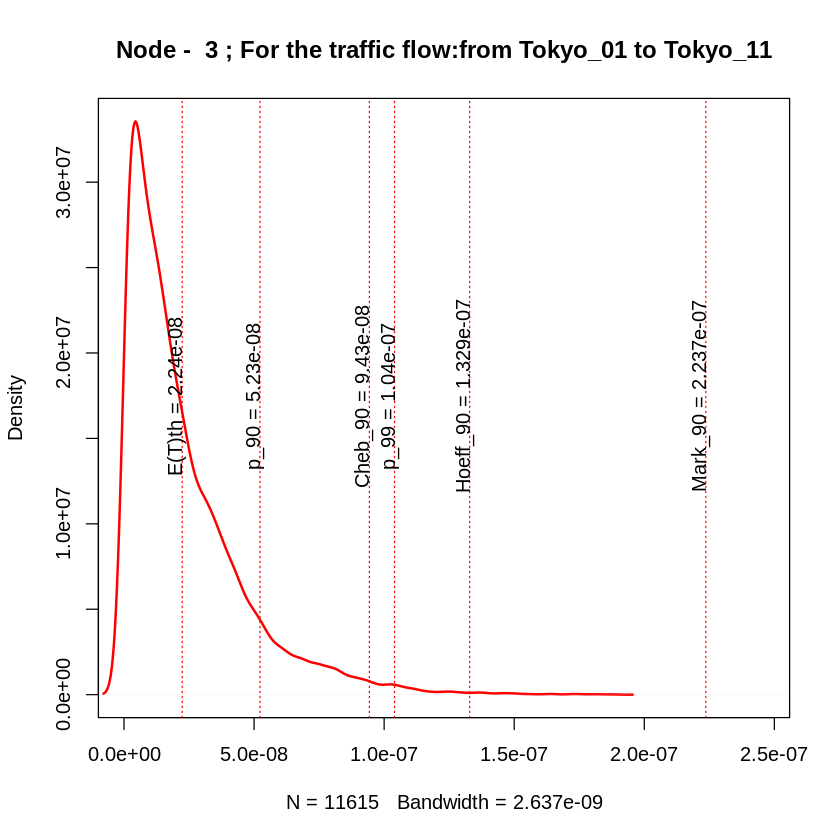

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_09->Tokyo_11
[1] "variance= 1.38557095081686e-15"
[1] "sigma2= 3.72232581972193e-08"
[1] "igraph E(T) = 1.50646614318796e-05"
[1] "simmer E(T) = 1.50648315977987e-05"


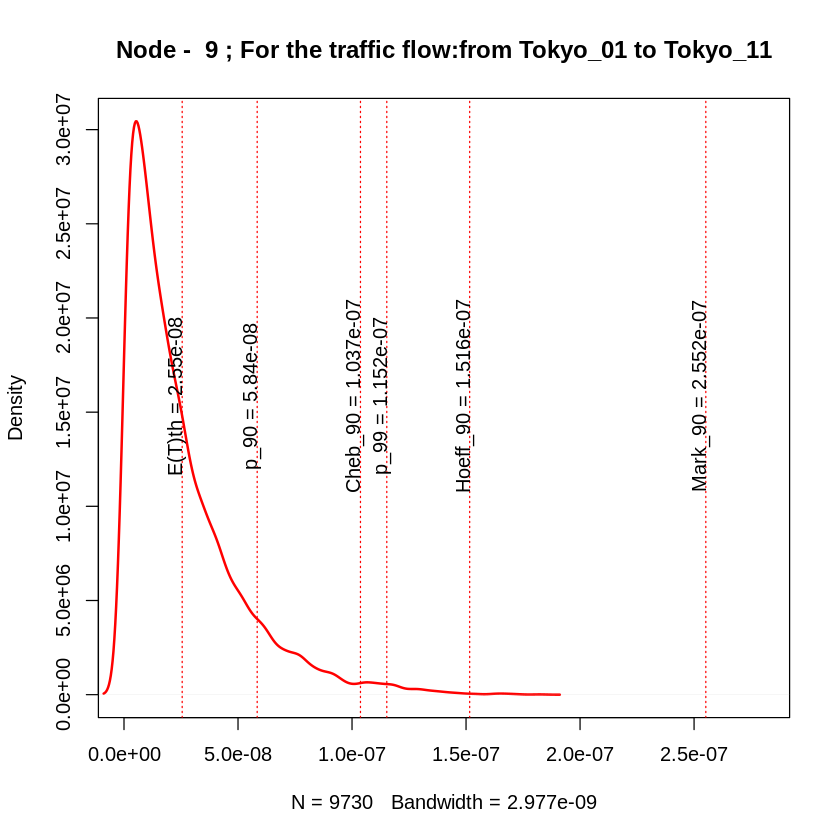

[1] 35
[1] "node_4"
[1] 159611404
[1] 0.5073199
[1] 73348069
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_13
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_13->Tokyo_12
[1] "traffic_Tokyo_04_Tokyo_12_"
[1] 4
[1] "Node -  4 :"
[1] "variance= 1.67549056688529e-16"
[1] "sigma2= 1.29440741920204e-08"
[1] "igraph E(T) = 1.27166003287417e-08"
[1] "simmer E(T) = 1.28731584981303e-08"


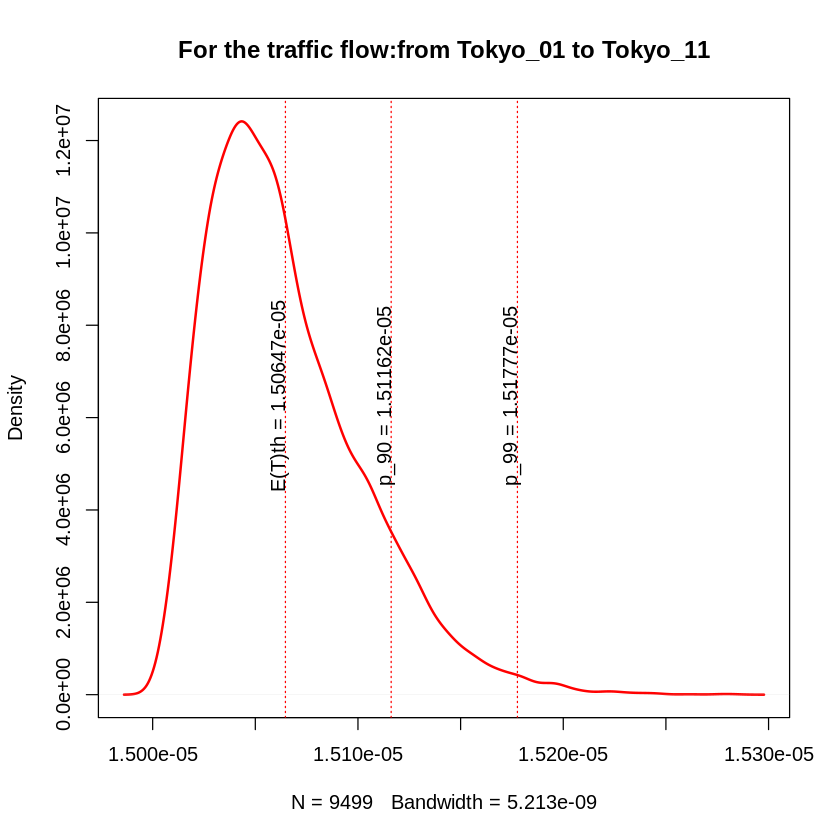

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_13
[1] 13
[1] "Node -  13 :"
[1] "variance= 3.87299757240658e-14"
[1] "sigma2= 1.96799328566095e-07"
[1] "igraph E(T) = 2.06677737512584e-07"
[1] "simmer E(T) = 1.9771137732092e-07"


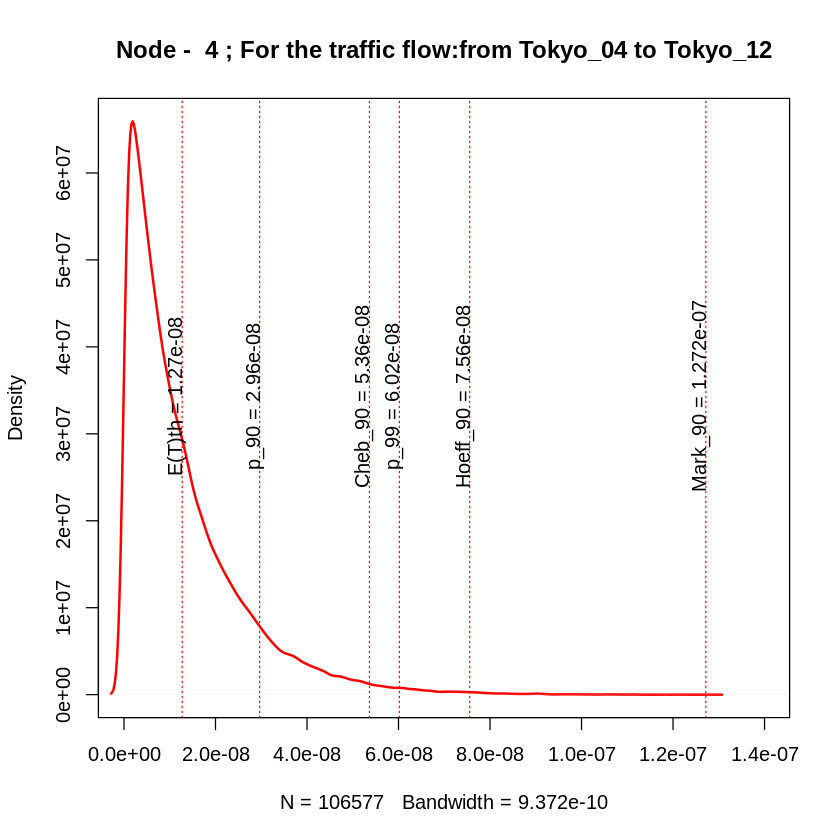

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_13->Tokyo_12
[1] "variance= 3.89299508670831e-14"
[1] "sigma2= 1.97306743085692e-07"
[1] "igraph E(T) = 8.21939433784133e-06"
[1] "simmer E(T) = 8.21076345108167e-06"


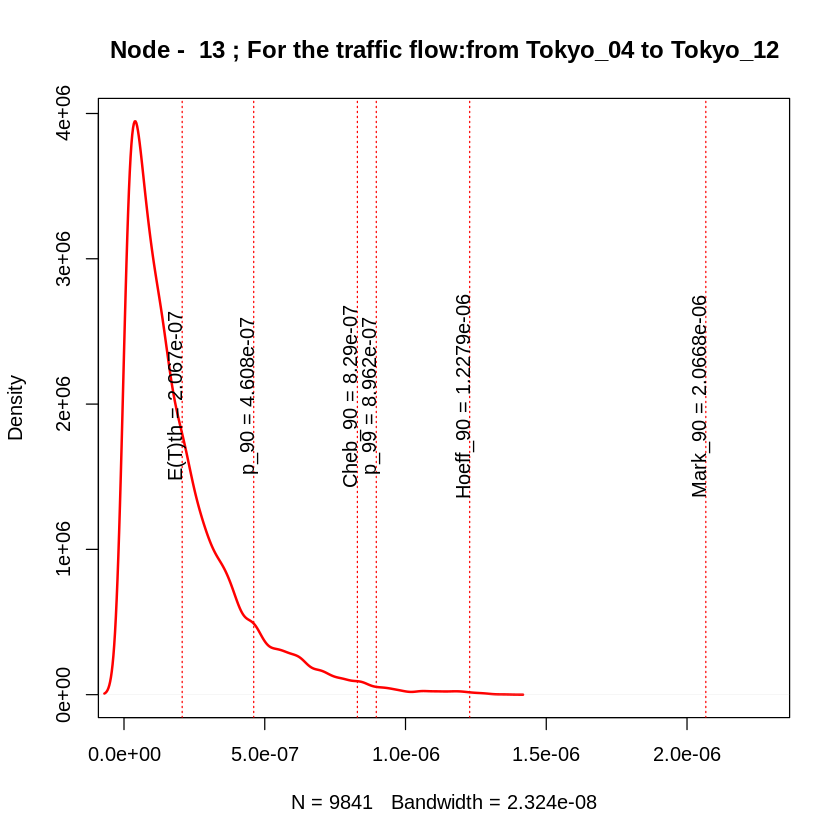

[1] 36
[1] "node_4"
[1] 159611404
[1] 0.5073199
[1] 46376474
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_13
[1] "traffic_Tokyo_04_Tokyo_13_"
[1] 4
[1] "Node -  4 :"
[1] "variance= 1.58538987439948e-16"
[1] "sigma2= 1.25912266058533e-08"
[1] "igraph E(T) = 1.27166003287417e-08"
[1] "simmer E(T) = 1.26644117812693e-08"


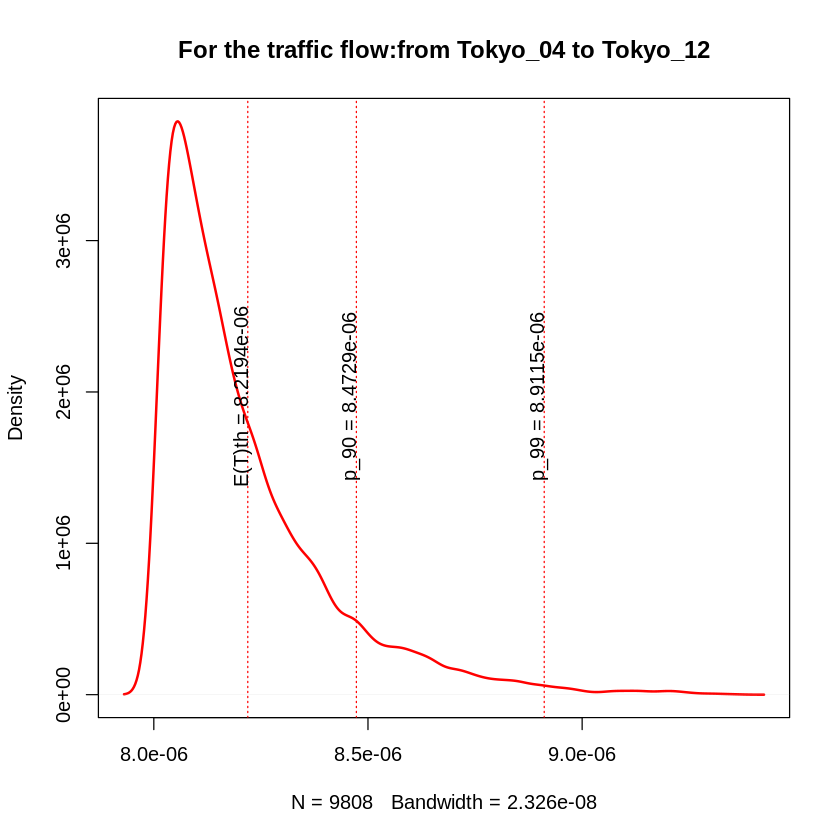

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_13
[1] "variance= 1.56087753853335e-16"
[1] "sigma2= 1.24935084685342e-08"
[1] "igraph E(T) = 4.01271660032874e-06"
[1] "simmer E(T) = 4.01266113602961e-06"


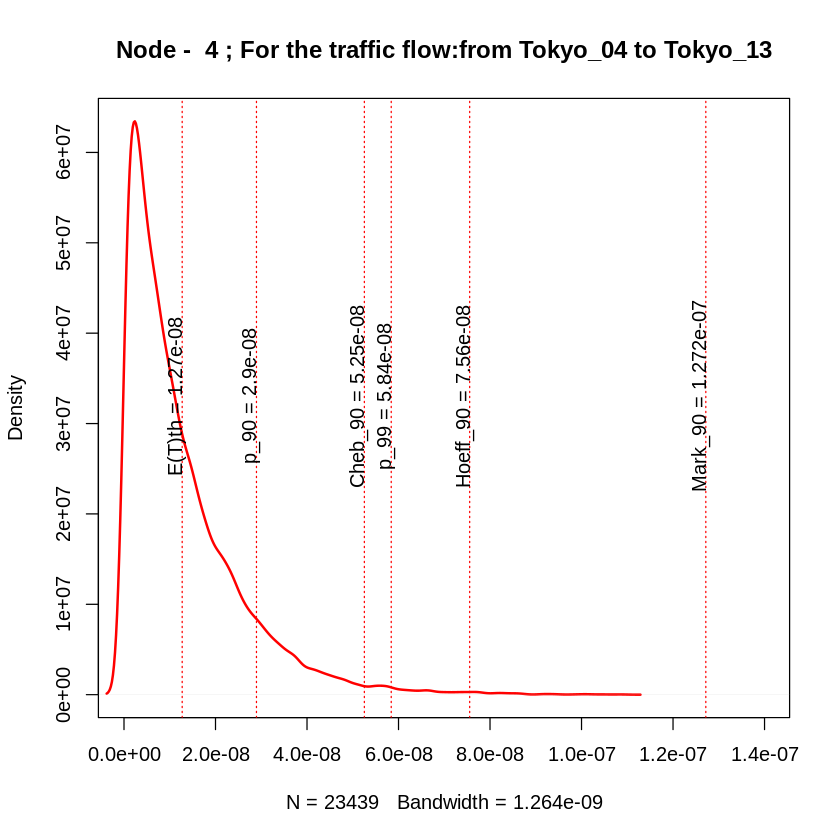

[1] 37
[1] "node_4"
[1] 197599713
[1] 0.4557914
[1] 50656381
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_14
[1] "traffic_Tokyo_04_Tokyo_14_"
[1] 4
[1] "Node -  4 :"
[1] "variance= 9.11122534110497e-17"
[1] "sigma2= 9.54527387826299e-09"
[1] "igraph E(T) = 9.29925801179127e-09"
[1] "simmer E(T) = 9.49720560506362e-09"


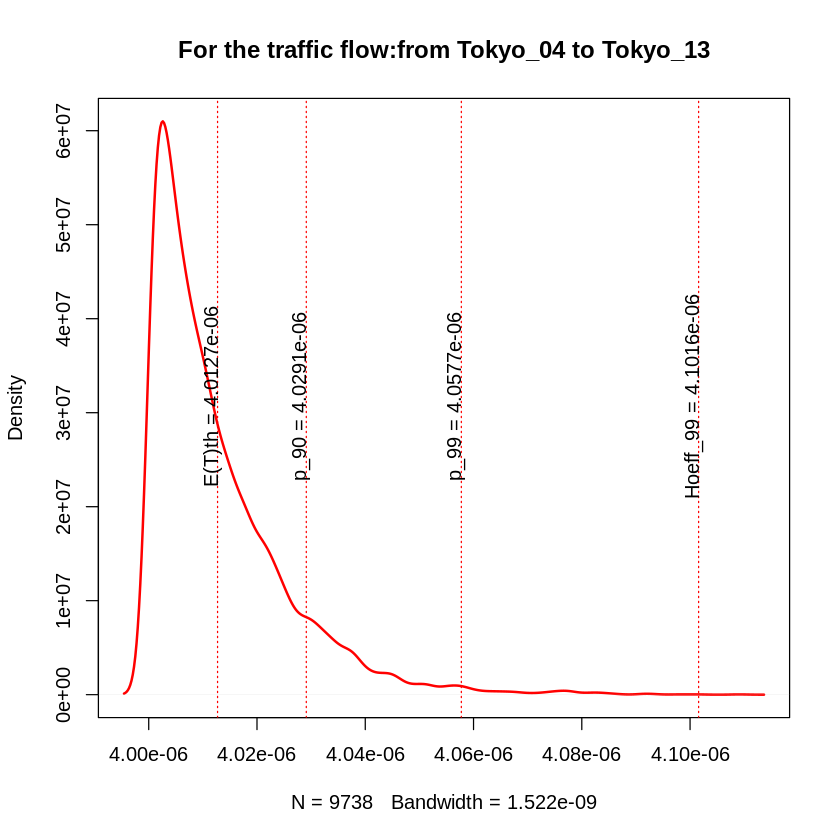

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_14
[1] "variance= 9.39840736023259e-17"
[1] "sigma2= 9.69453833879293e-09"
[1] "igraph E(T) = 3.00929925801179e-06"
[1] "simmer E(T) = 3.00963723819196e-06"


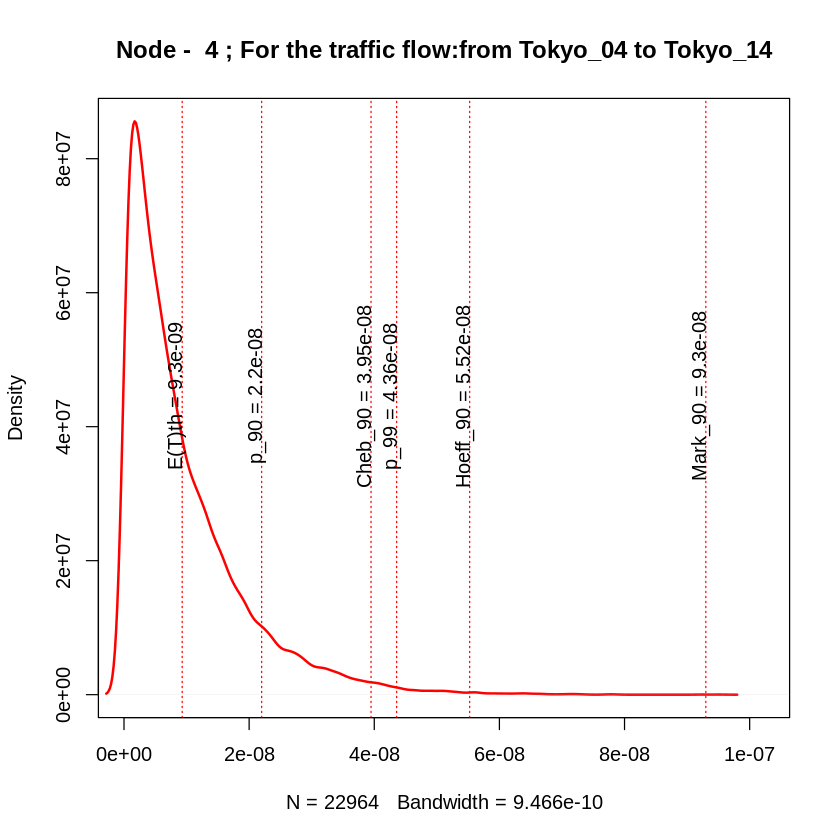

[1] 38
[1] "node_4"
[1] 197599713
[1] 0.4557914
[1] 77368417
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_14
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_14->Tokyo_15
[1] "traffic_Tokyo_04_Tokyo_15_"
[1] 4
[1] "Node -  4 :"
[1] "variance= 9.25287024407551e-17"
[1] "sigma2= 9.61918408394158e-09"
[1] "igraph E(T) = 9.29925801179127e-09"
[1] "simmer E(T) = 9.47938641344418e-09"


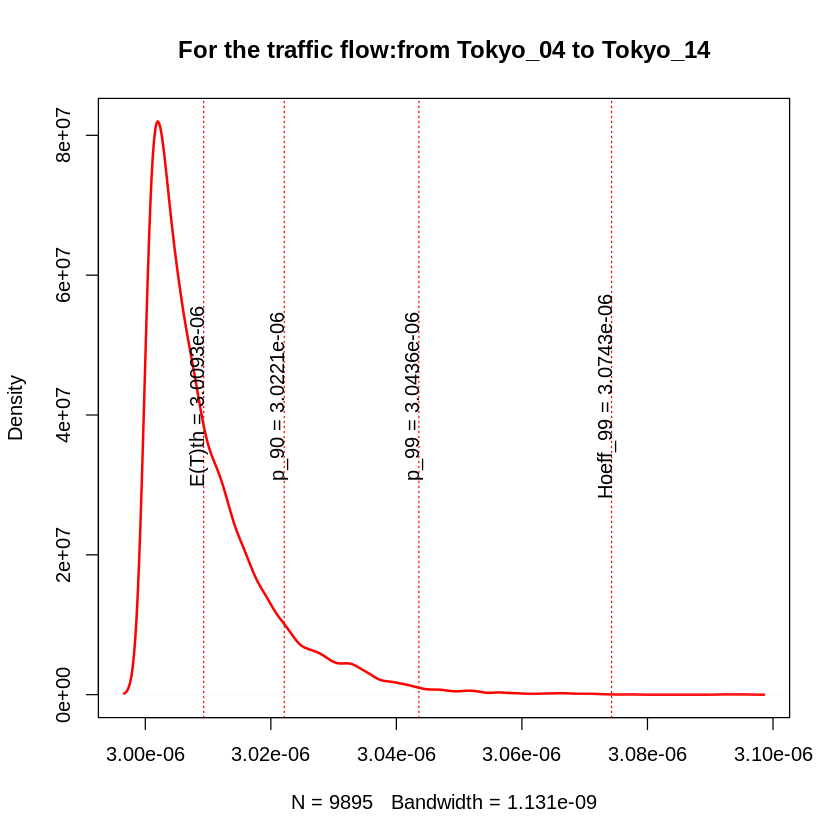

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_14
[1] 14
[1] "Node -  14 :"
[1] "variance= 4.9069077311216e-15"
[1] "sigma2= 7.00493235593436e-08"
[1] "igraph E(T) = 7.52086870351888e-08"
[1] "simmer E(T) = 7.24386216166441e-08"


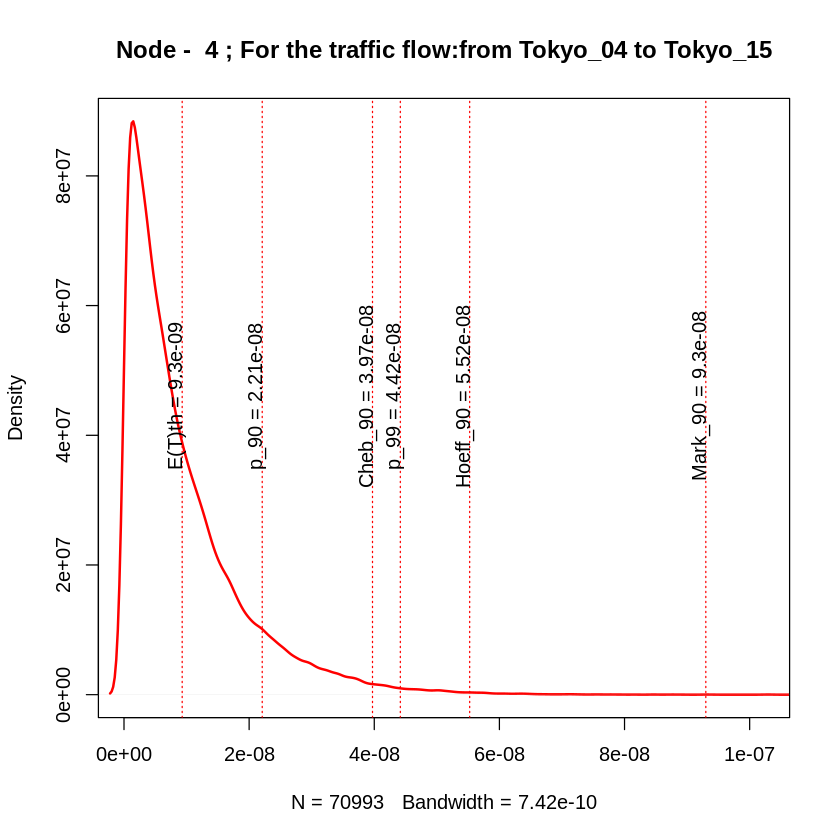

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_14->Tokyo_15
[1] "variance= 4.99255276728533e-15"
[1] "sigma2= 7.06579986079802e-08"
[1] "igraph E(T) = 6.08450794504698e-06"
[1] "simmer E(T) = 6.08218768487572e-06"


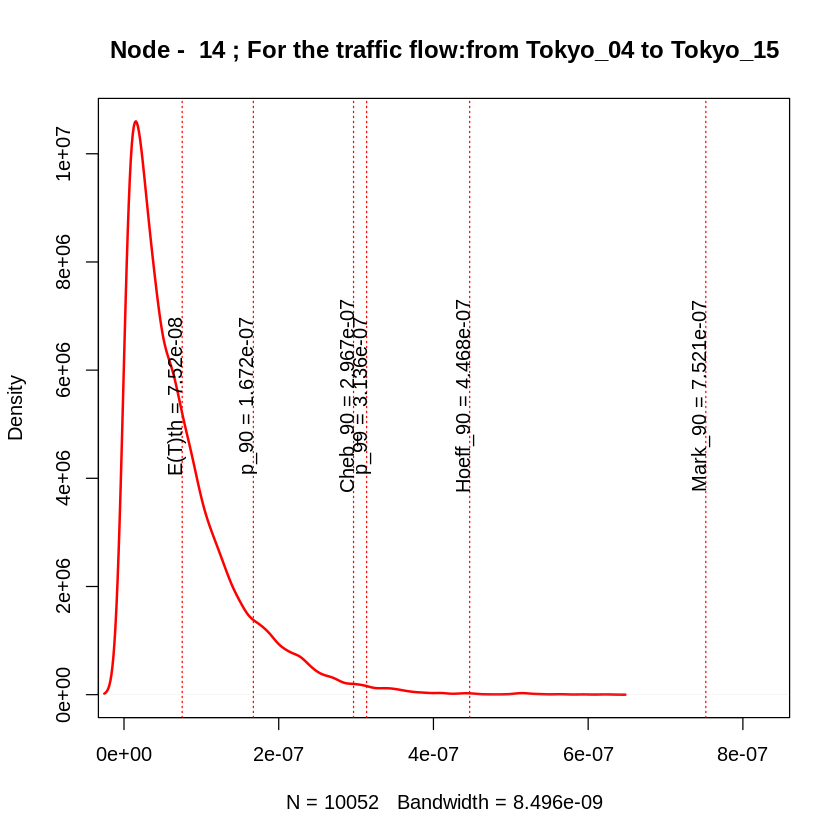

[1] 39
[1] "node_4"
[1] 214044149
[1] 0.4487968
[1] 70210788
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_16
[1] "traffic_Tokyo_04_Tokyo_16_"
[1] 4
[1] "Node -  4 :"
[1] "variance= 7.82602425261138e-17"
[1] "sigma2= 8.84648192933856e-09"
[1] "igraph E(T) = 8.47588206861613e-09"
[1] "simmer E(T) = 8.51384903647756e-09"


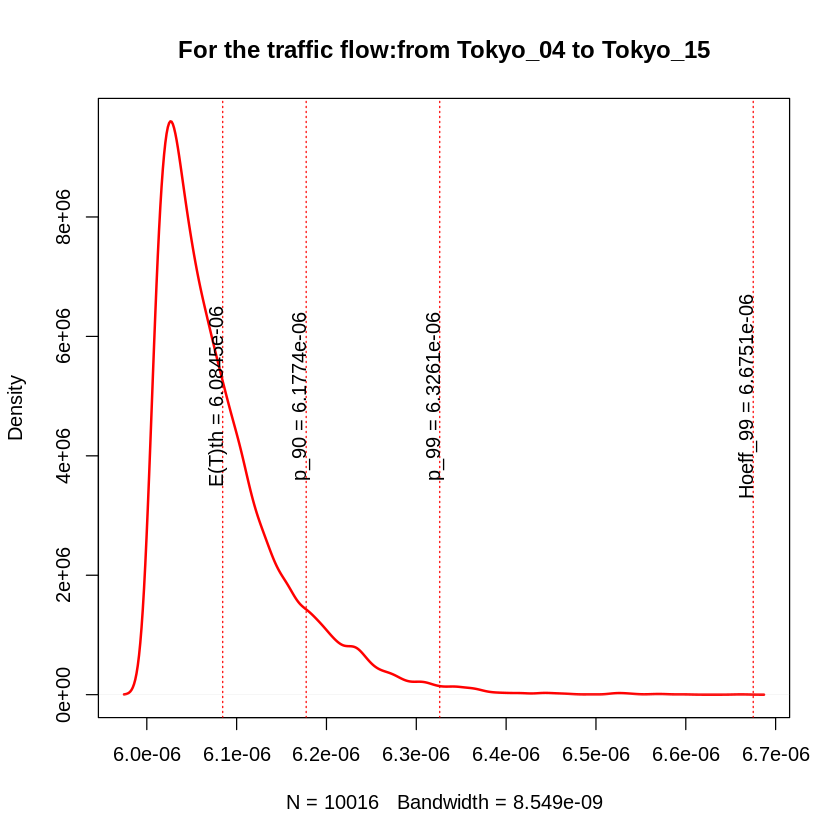

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_16
[1] "variance= 7.84178679734727e-17"
[1] "sigma2= 8.85538638194137e-09"
[1] "igraph E(T) = 3.00847588206862e-06"
[1] "simmer E(T) = 3.00858595704947e-06"


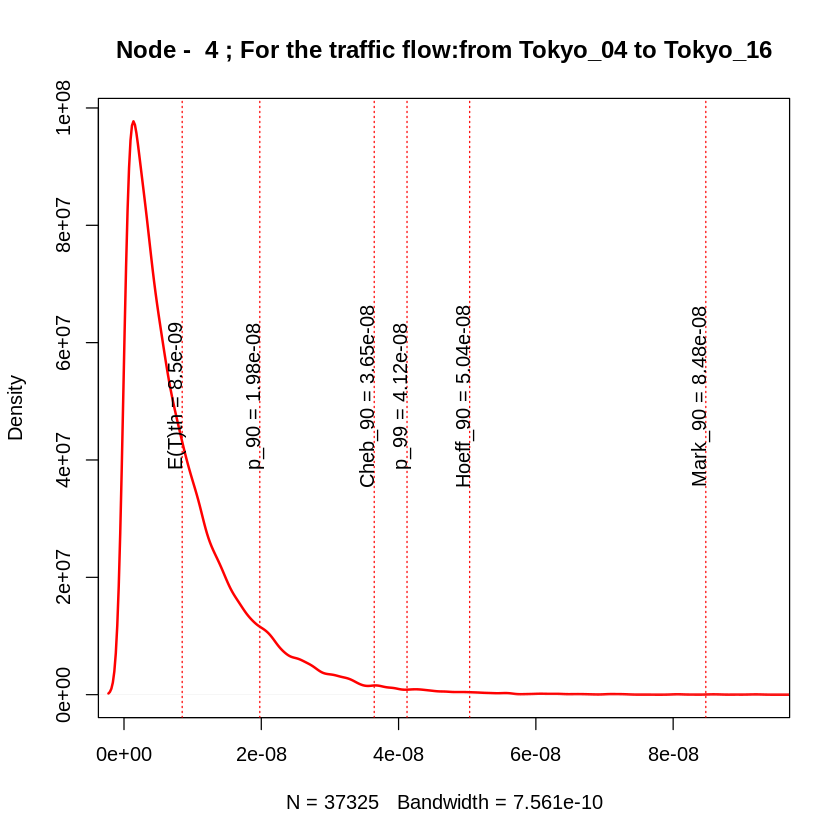

[1] 40
[1] "node_4"
[1] 214044149
[1] 0.4487968
[1] 70106400
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_16
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_16->Tokyo_17
[1] "traffic_Tokyo_04_Tokyo_17_"
[1] 4
[1] "Node -  4 :"
[1] "variance= 7.0560272792456e-17"
[1] "sigma2= 8.40001623763049e-09"
[1] "igraph E(T) = 8.47588206861613e-09"
[1] "simmer E(T) = 8.43399924309031e-09"


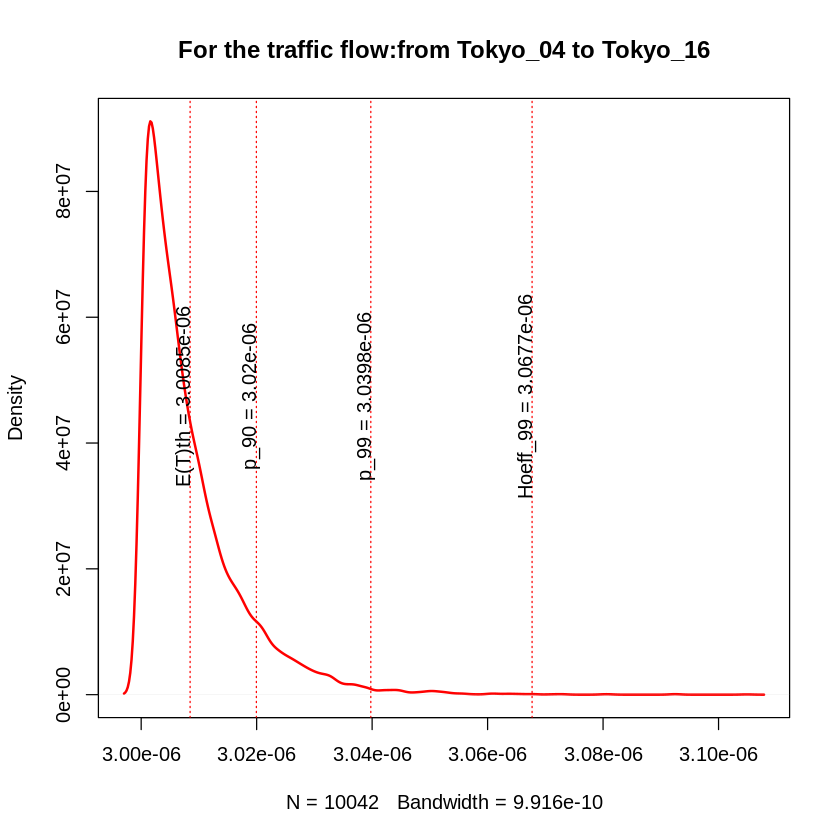

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_16
[1] 16
[1] "Node -  16 :"
[1] "variance= 6.6092169813712e-15"
[1] "sigma2= 8.12970908542932e-08"
[1] "igraph E(T) = 7.39639043821475e-08"
[1] "simmer E(T) = 7.94726253297963e-08"


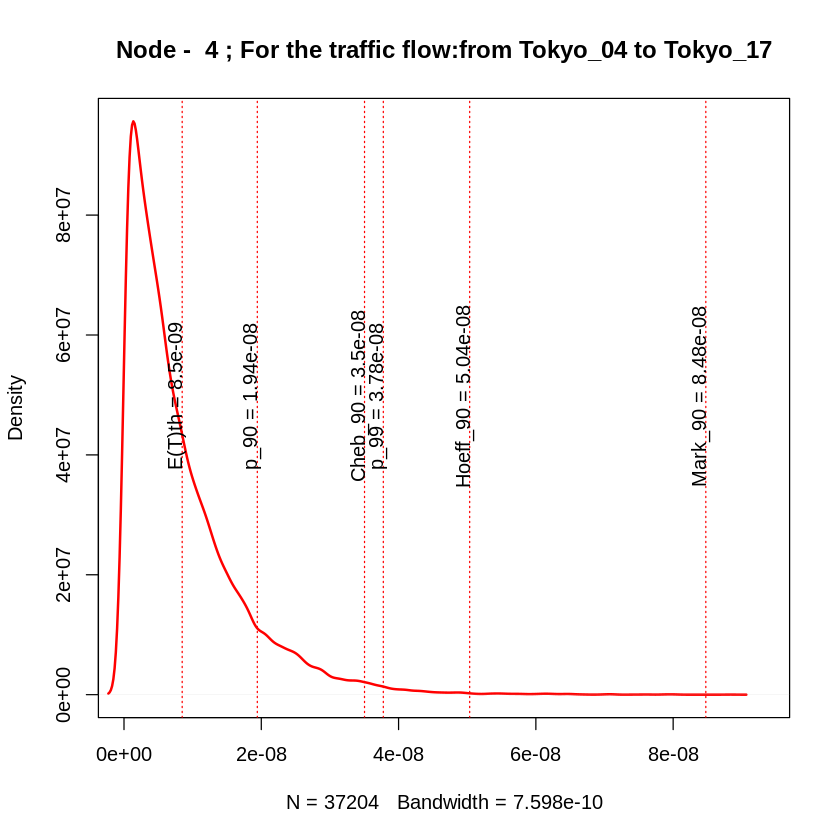

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_16->Tokyo_17
[1] "variance= 6.73969816953914e-15"
[1] "sigma2= 8.20956647426594e-08"
[1] "igraph E(T) = 5.08243978645076e-06"
[1] "simmer E(T) = 5.08815715518712e-06"


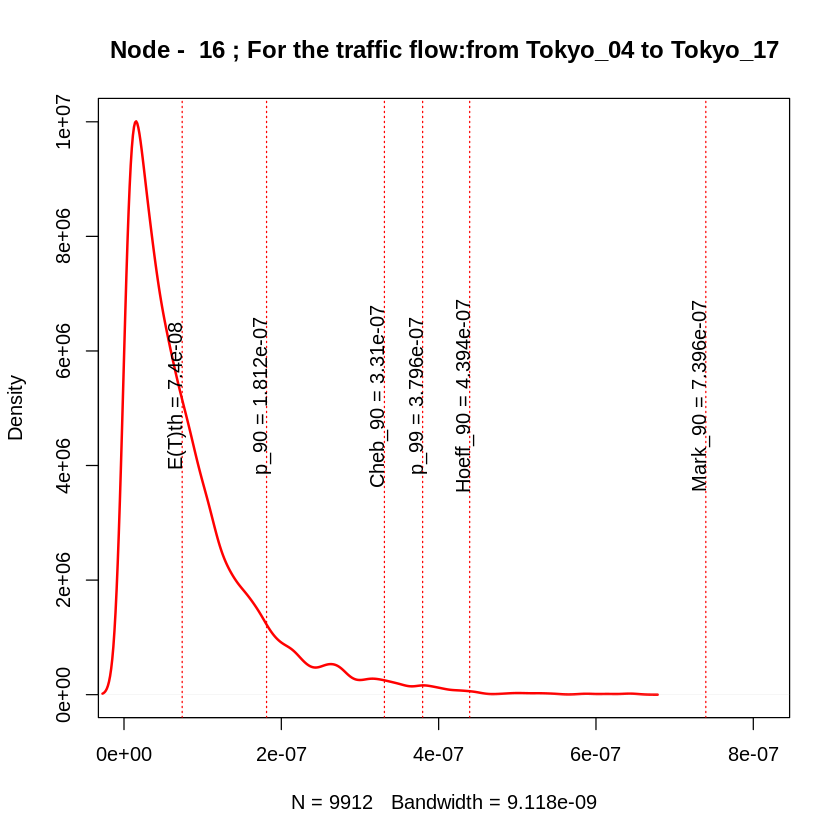

[1] 41
[1] "node_5"
[1] 136337502
[1] 0.4082409
[1] 11567316
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_05->Tokyo_18
[1] "traffic_Tokyo_05_Tokyo_18_"
[1] 5
[1] "Node -  5 :"
[1] "variance= 1.53260507329815e-16"
[1] "sigma2= 1.237984278292e-08"
[1] "igraph E(T) = 1.23948049757248e-08"
[1] "simmer E(T) = 1.24569252864605e-08"


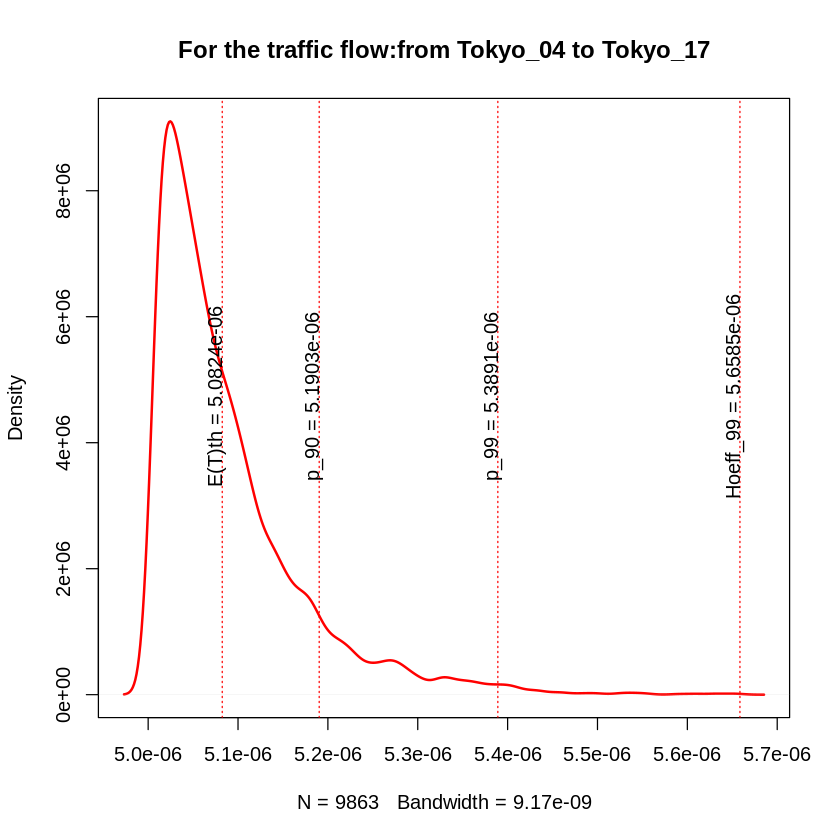

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_05->Tokyo_18
[1] "variance= 1.5523355602028e-16"
[1] "sigma2= 1.24592759027272e-08"
[1] "igraph E(T) = 3.01239480497572e-06"
[1] "simmer E(T) = 3.0125857278384e-06"


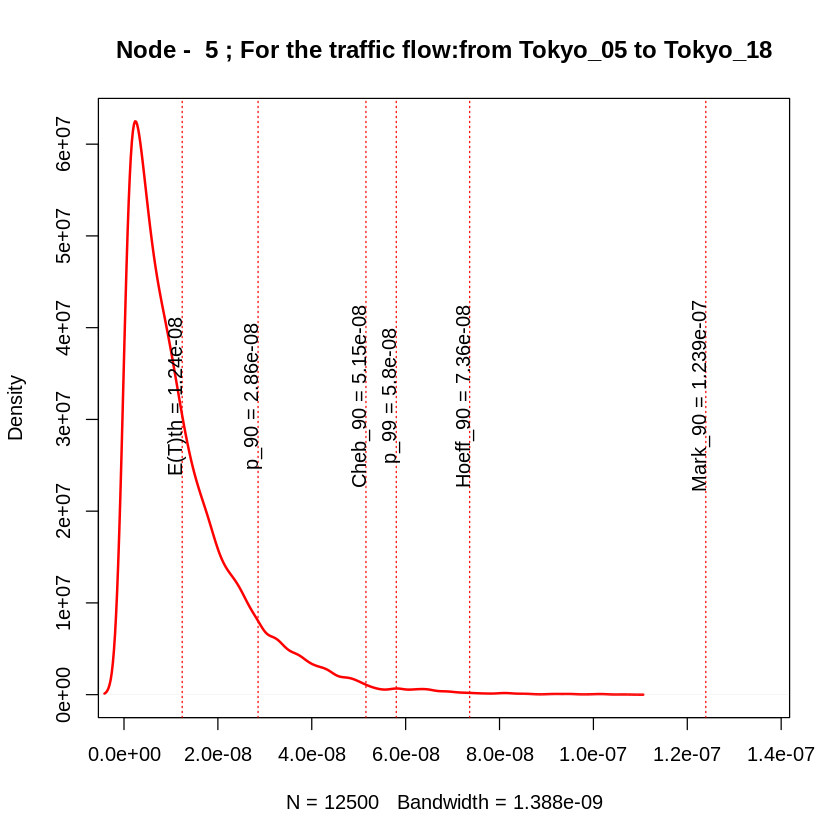

[1] 42
[1] "node_4"
[1] 214044149
[1] 0.4487968
[1] 51807470
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_16
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_16->Tokyo_19
[1] "traffic_Tokyo_04_Tokyo_19_"
[1] 4
[1] "Node -  4 :"
[1] "variance= 7.65575066684489e-17"
[1] "sigma2= 8.74971466211607e-09"
[1] "igraph E(T) = 8.47588206861613e-09"
[1] "simmer E(T) = 8.66425354827522e-09"


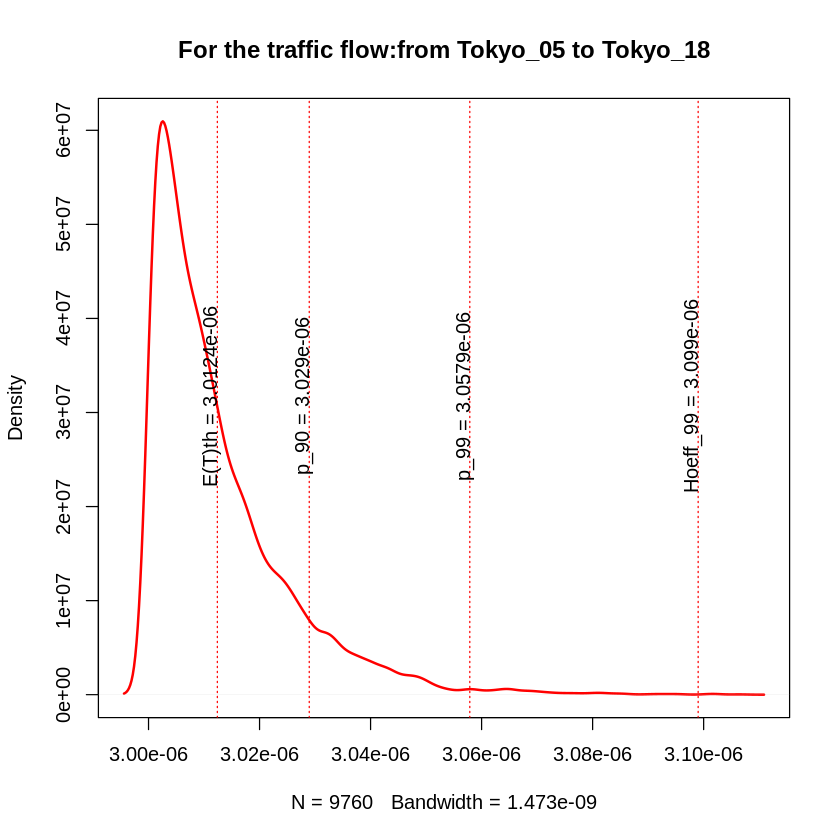

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_16
[1] 16
[1] "Node -  16 :"
[1] "variance= 5.40648258954945e-16"
[1] "sigma2= 2.32518442054592e-08"
[1] "igraph E(T) = 2.24451195463521e-08"
[1] "simmer E(T) = 2.32589712129887e-08"


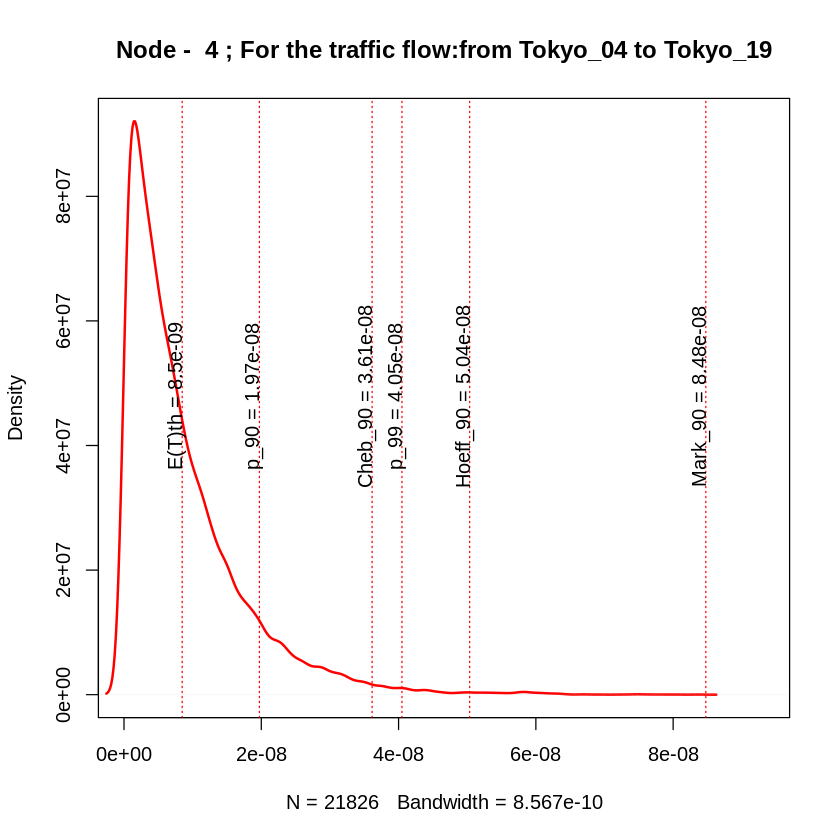

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_16->Tokyo_19
[1] "variance= 6.15064387153238e-16"
[1] "sigma2= 2.48004916716028e-08"
[1] "igraph E(T) = 5.03092100161497e-06"
[1] "simmer E(T) = 5.03181894243122e-06"


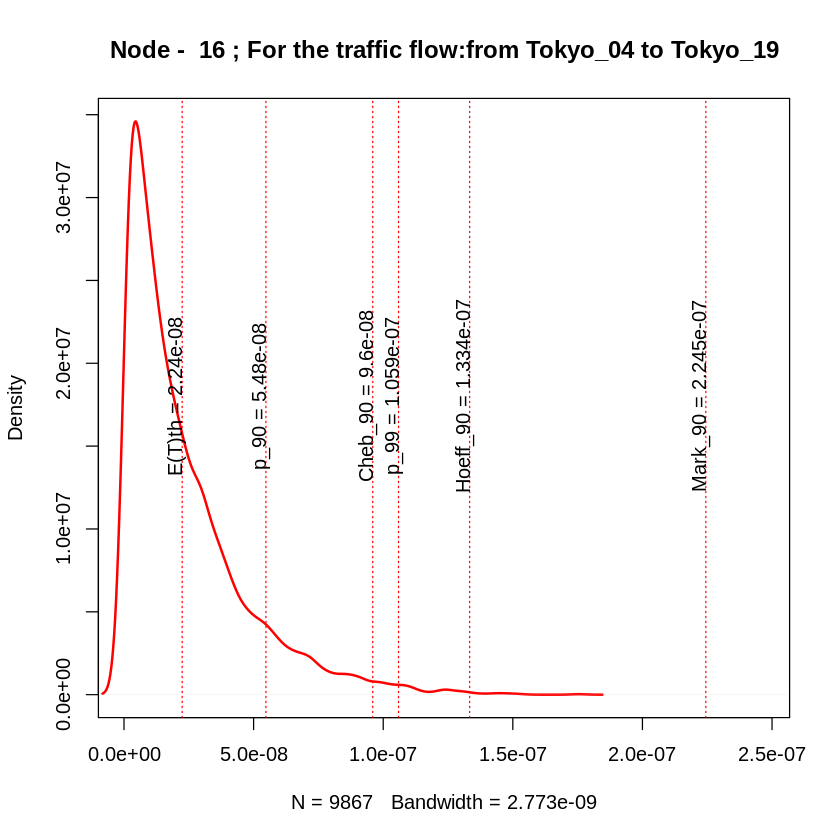

[1] 43
[1] "node_4"
[1] 197599713
[1] 0.4557914
[1] 52103706
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_14
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_14->Tokyo_20
[1] "traffic_Tokyo_04_Tokyo_20_"
[1] 4
[1] "Node -  4 :"
[1] "variance= 9.205915429033e-17"
[1] "sigma2= 9.59474618165223e-09"
[1] "igraph E(T) = 9.29925801179127e-09"
[1] "simmer E(T) = 9.37549760322882e-09"


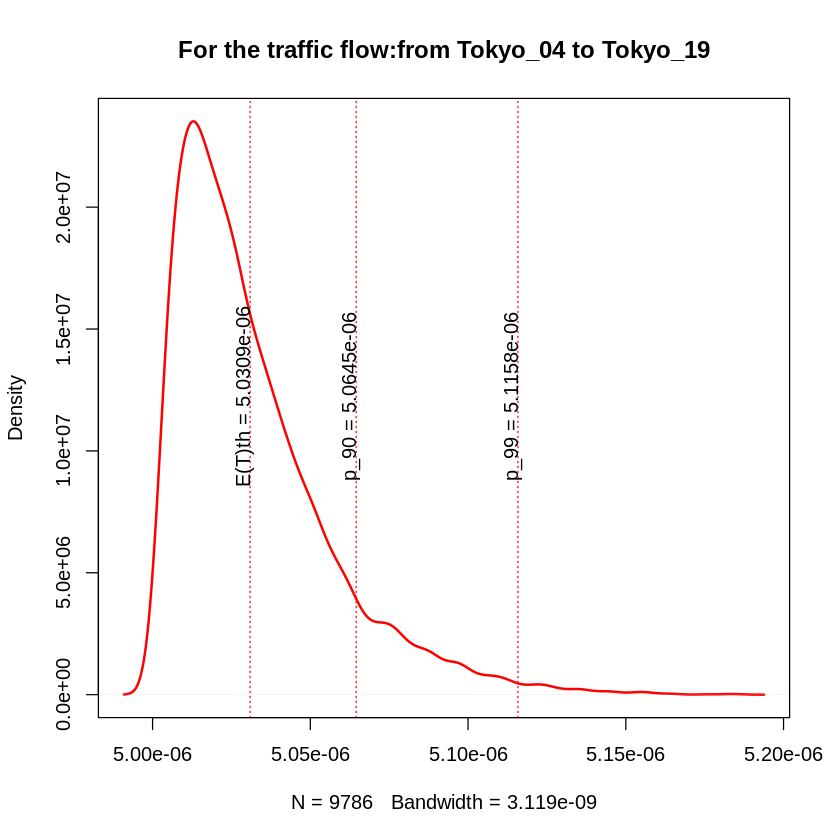

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_04->Tokyo_14
[1] 14
[1] "Node -  14 :"
[1] "variance= 4.34338881029698e-16"
[1] "sigma2= 2.08407984738997e-08"
[1] "igraph E(T) = 2.25455025717079e-08"
[1] "simmer E(T) = 2.19061689293607e-08"


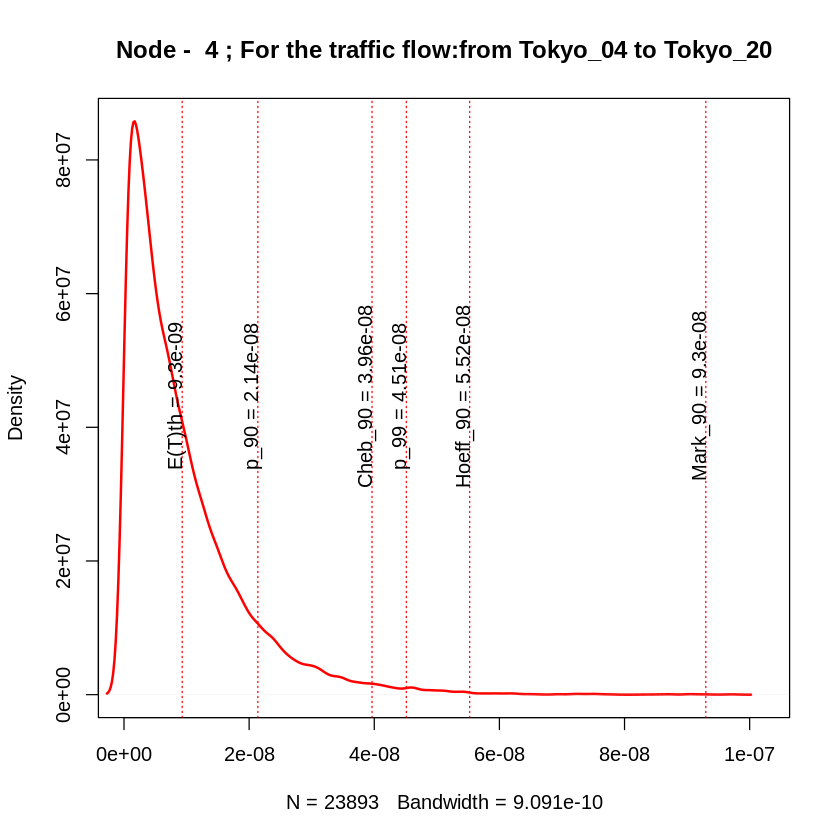

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_14->Tokyo_20
[1] "variance= 5.38615483108667e-16"
[1] "sigma2= 2.32080908975441e-08"
[1] "igraph E(T) = 6.0318447605835e-06"
[1] "simmer E(T) = 6.03139797760443e-06"


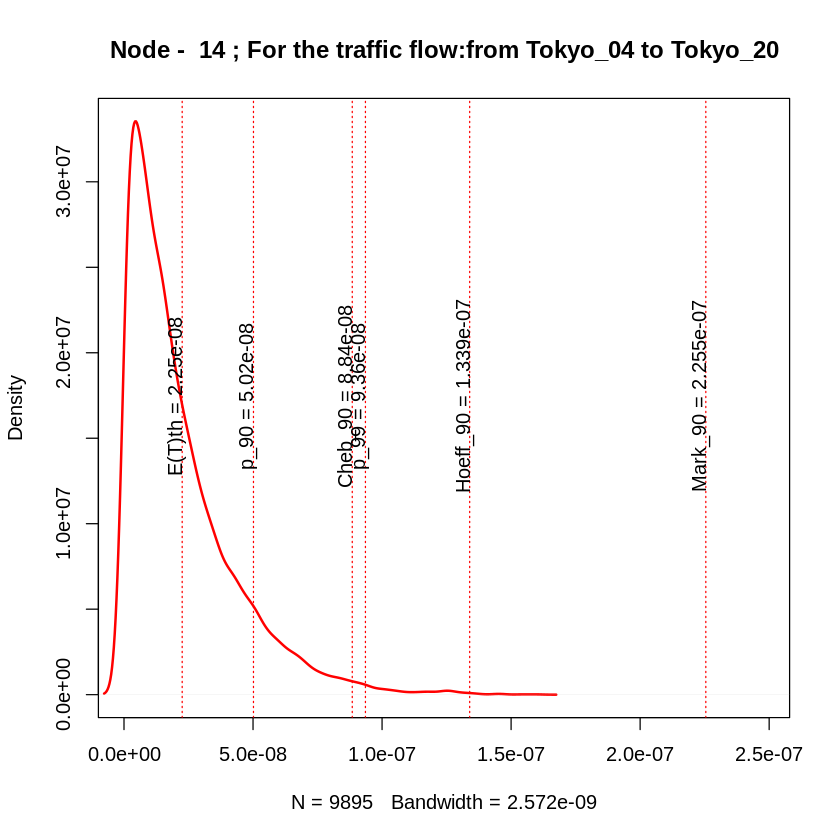

[1] 44
[1] "node_5"
[1] 136337502
[1] 0.4082409
[1] 44091224
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_05->Tokyo_18
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_18->Tokyo_21
[1] "traffic_Tokyo_05_Tokyo_21_"
[1] 5
[1] "Node -  5 :"
[1] "variance= 1.66466352968928e-16"
[1] "sigma2= 1.29021840387172e-08"
[1] "igraph E(T) = 1.23948049757248e-08"
[1] "simmer E(T) = 1.26614569066385e-08"


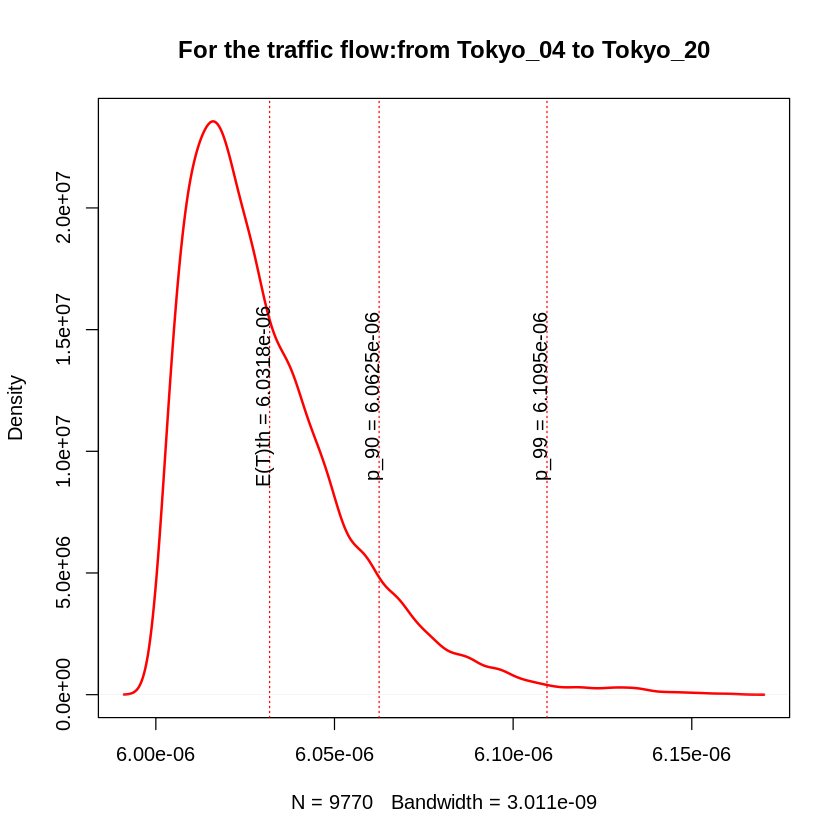

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_05->Tokyo_18
[1] 18
[1] "Node -  18 :"
[1] "variance= 3.48325731770529e-15"
[1] "sigma2= 5.90191267107985e-08"
[1] "igraph E(T) = 5.86491123889505e-08"
[1] "simmer E(T) = 5.81750633287884e-08"


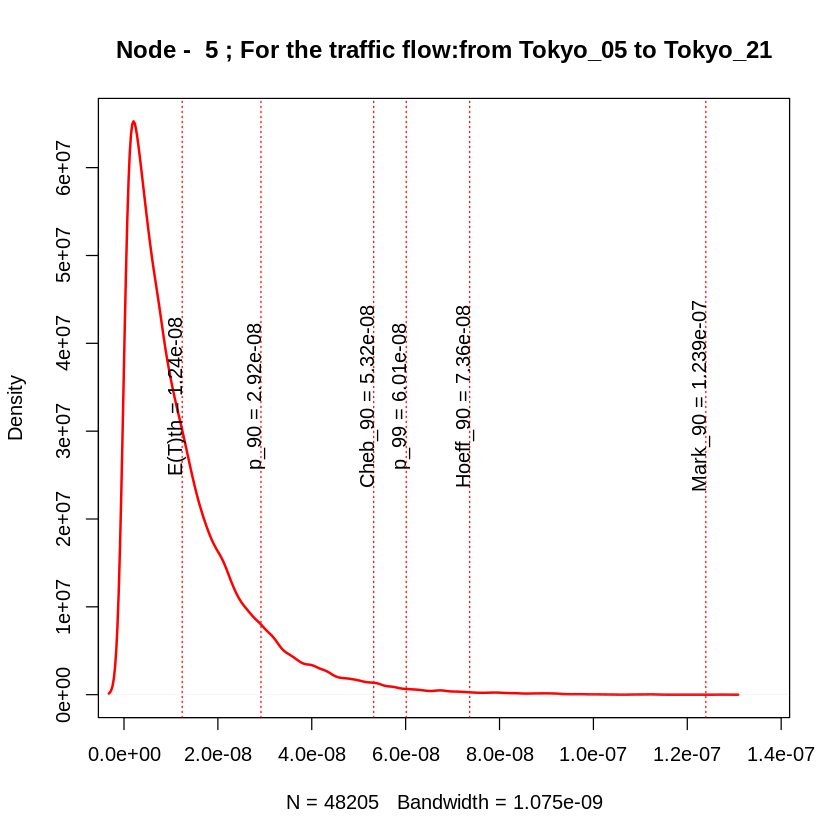

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_18->Tokyo_21
[1] "variance= 3.64805344849524e-15"
[1] "sigma2= 6.03991179446789e-08"
[1] "igraph E(T) = 6.07104391736467e-06"
[1] "simmer E(T) = 6.07091599399254e-06"


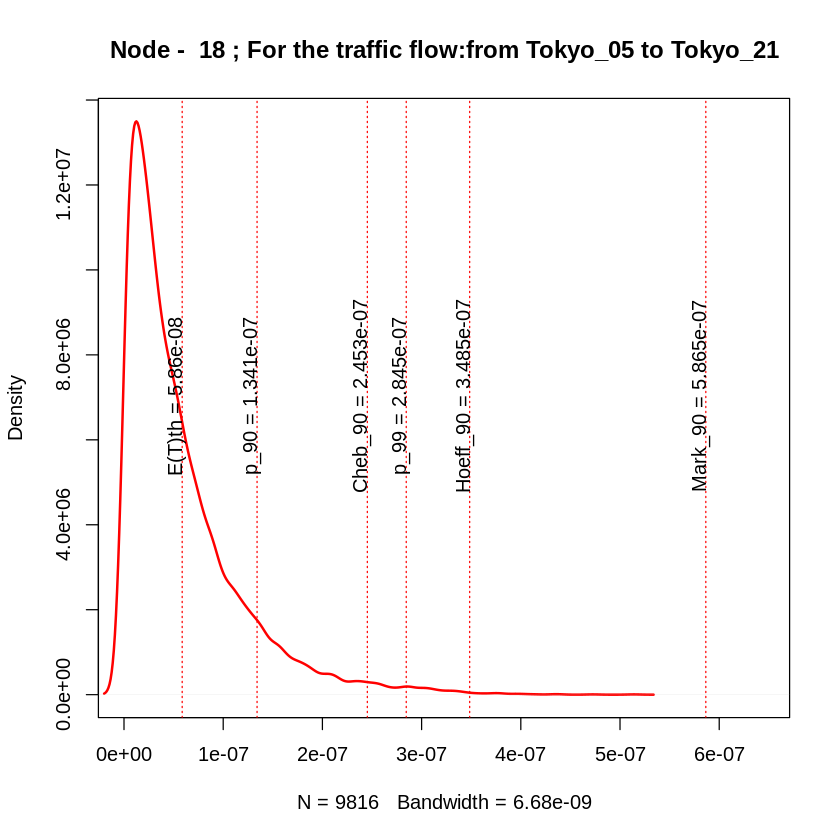

[1] 45
[1] "node_1"
[1] 214710133
[1] 0.4925013
[1] 61650974
[1] "node_6"
[1] 139109649
[1] 0.4749225
[1] 21972258
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_06
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_06->Tokyo_07
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_07->Tokyo_22
[1] "traffic_Tokyo_01_Tokyo_22_"
[1] 1
[1] "Node -  1 :"
[1] "variance= 8.08233354224573e-17"
[1] "sigma2= 8.99017994383078e-09"
[1] "igraph E(T) = 9.17724912671743e-09"
[1] "simmer E(T) = 9.07152034103382e-09"


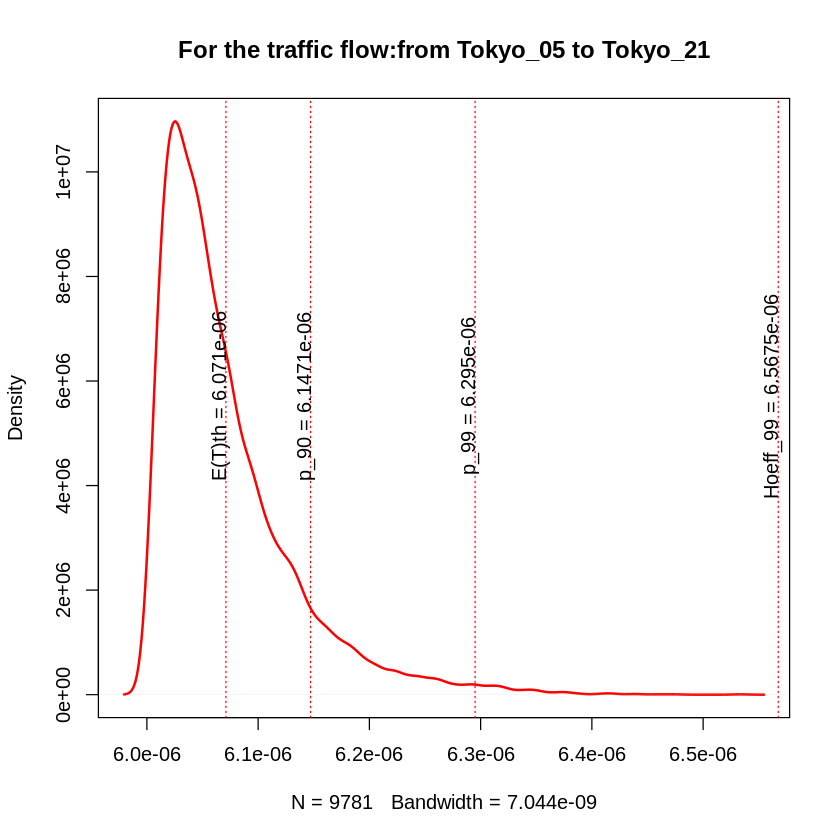

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_06
[1] 6
[1] "Node -  6 :"
[1] "variance= 2.09776070193607e-16"
[1] "sigma2= 1.44836483730311e-08"
[1] "igraph E(T) = 1.36905009844813e-08"
[1] "simmer E(T) = 1.40086503902658e-08"


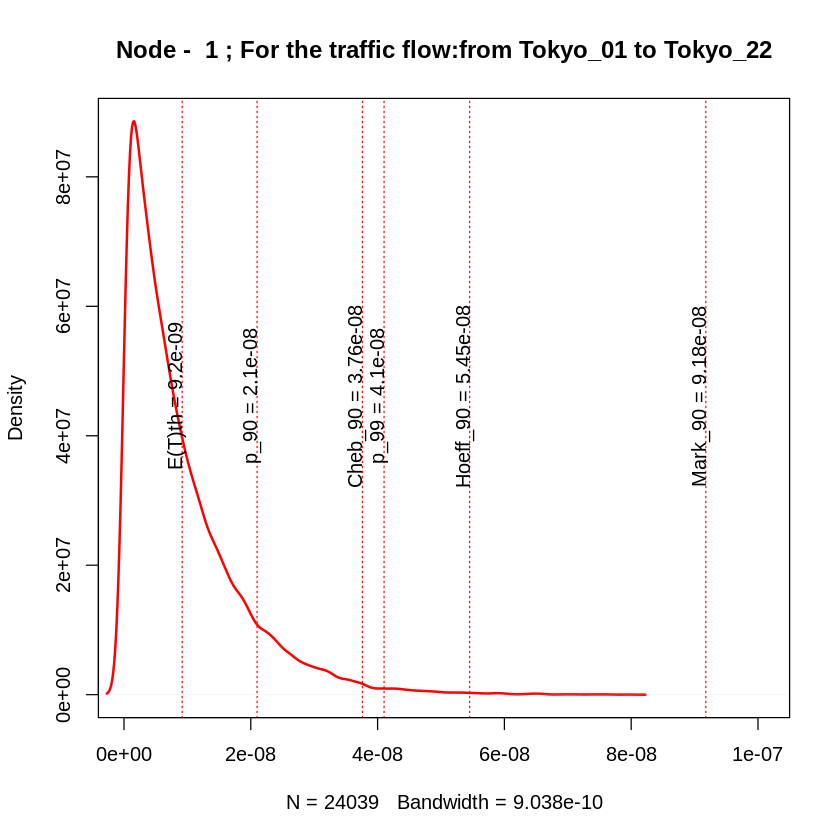

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_06->Tokyo_07
[1] 7
[1] "Node -  7 :"
[1] "variance= 4.52671276061714e-16"
[1] "sigma2= 2.12760728533654e-08"
[1] "igraph E(T) = 2.17126878424888e-08"
[1] "simmer E(T) = 2.07954399701558e-08"


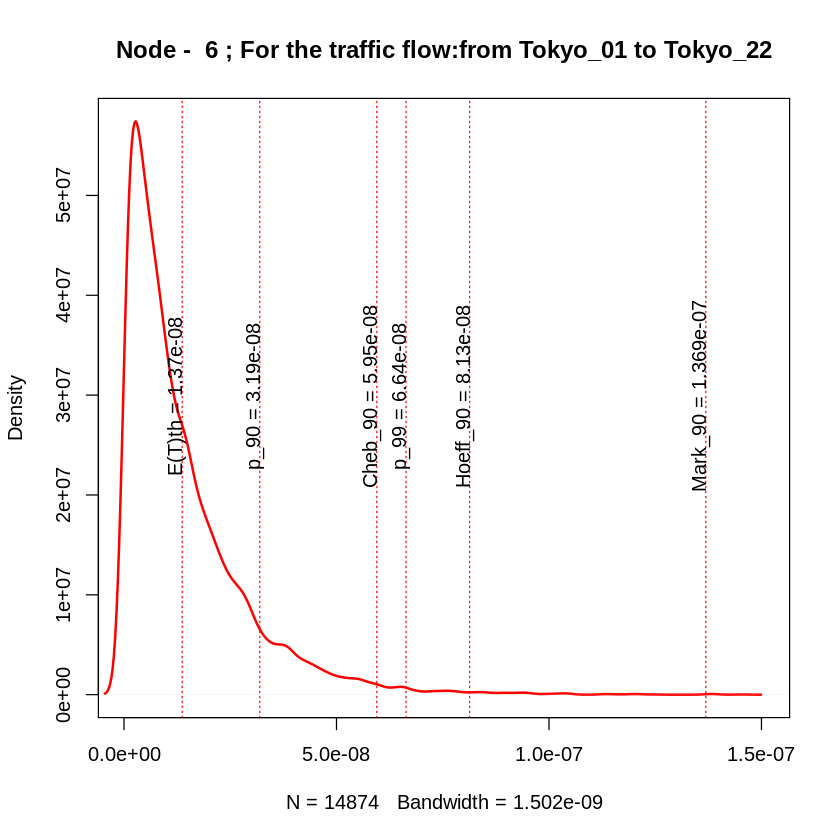

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_07->Tokyo_22
[1] "variance= 7.9705590132396e-16"
[1] "sigma2= 2.82321784728696e-08"
[1] "igraph E(T) = 1.20445804379537e-05"
[1] "simmer E(T) = 1.20438417893728e-05"


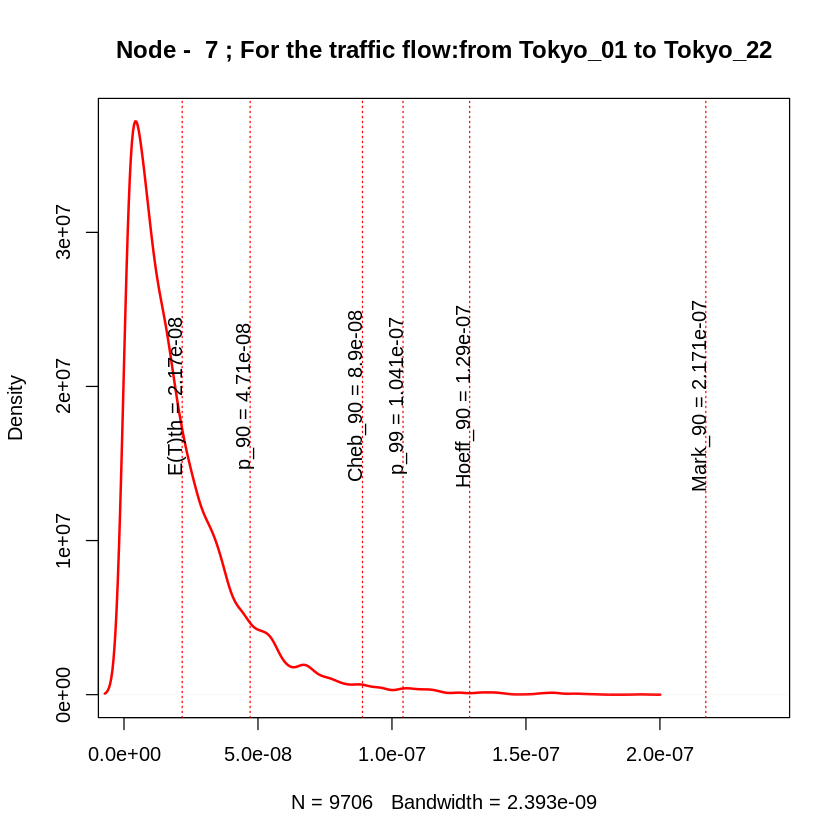

[1] 46
[1] "node_1"
[1] 165147444
[1] 0.4834118
[1] 67138396
[1] "node_2"
[1] 112529308
[1] 0.4352691
[1] 36284696
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_02
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_02->Tokyo_08
+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_08->Tokyo_23
[1] "traffic_Tokyo_01_Tokyo_23_"
[1] 1
[1] "Node -  1 :"
[1] "variance= 1.29667065010214e-16"
[1] "sigma2= 1.13871447259712e-08"
[1] "igraph E(T) = 1.1721513636851e-08"
[1] "simmer E(T) = 1.1490982234273e-08"


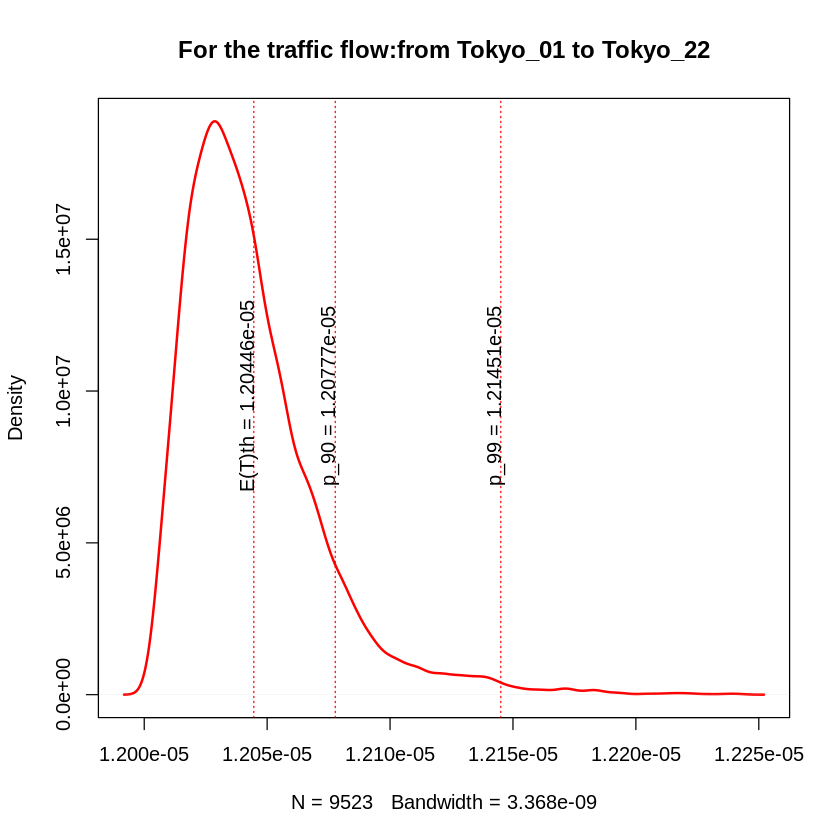

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_01->Tokyo_02
[1] 2
[1] "Node -  2 :"
[1] "variance= 2.47315525546969e-16"
[1] "sigma2= 1.57262686466615e-08"
[1] "igraph E(T) = 1.57359439796034e-08"
[1] "simmer E(T) = 1.56992059029783e-08"


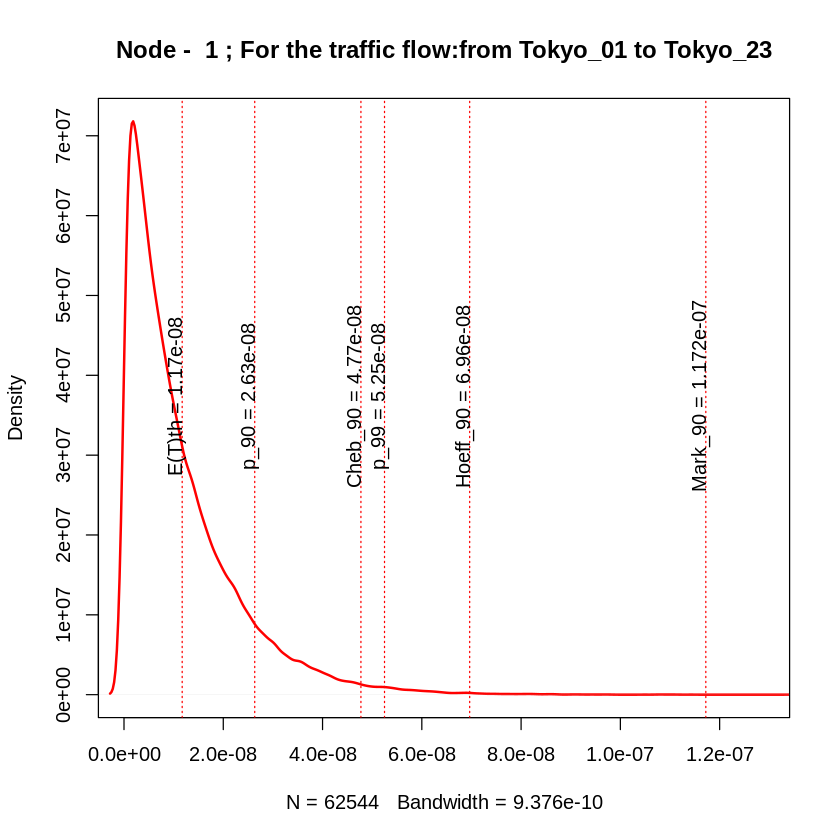

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_02->Tokyo_08
[1] 8
[1] "Node -  8 :"
[1] "variance= 1.74385745676733e-14"
[1] "sigma2= 1.3205519515594e-07"
[1] "igraph E(T) = 1.3951116094309e-07"
[1] "simmer E(T) = 1.39509529305142e-07"


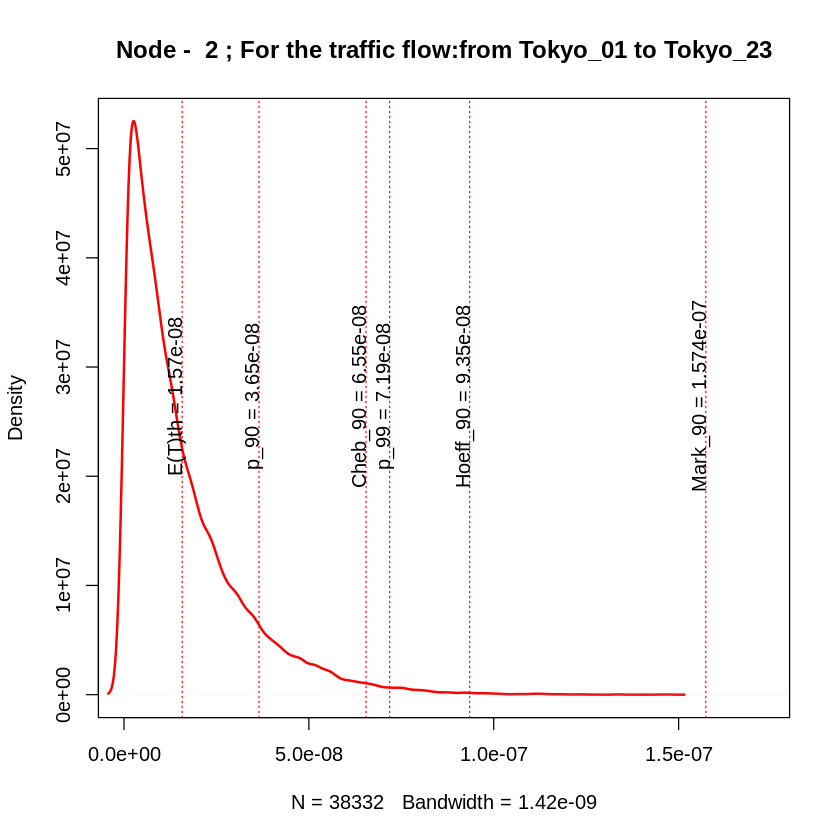

+ 1/86 edge from ba39c56 (vertex names):
[1] Tokyo_08->Tokyo_23
[1] "variance= 1.78510973820523e-14"
[1] "sigma2= 1.3360799894487e-07"
[1] "igraph E(T) = 1.51669686185595e-05"
[1] "simmer E(T) = 1.51671984292114e-05"


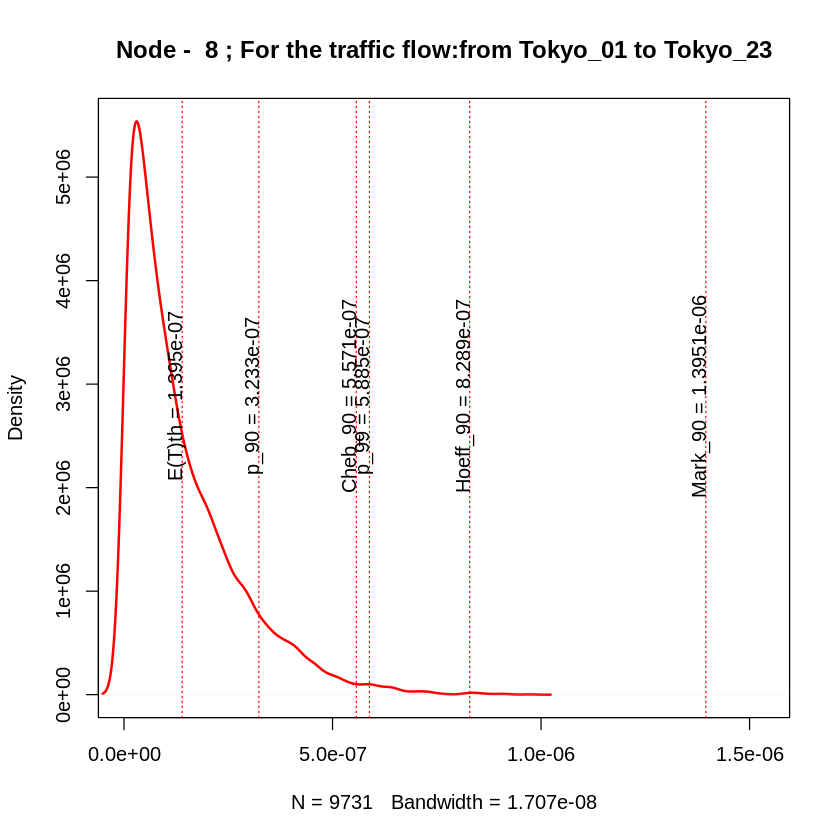

[1] "igraph E(T) = 1.0240292263755e-08"
[1] "simmer E(T) = 1.01487867318613e-08"


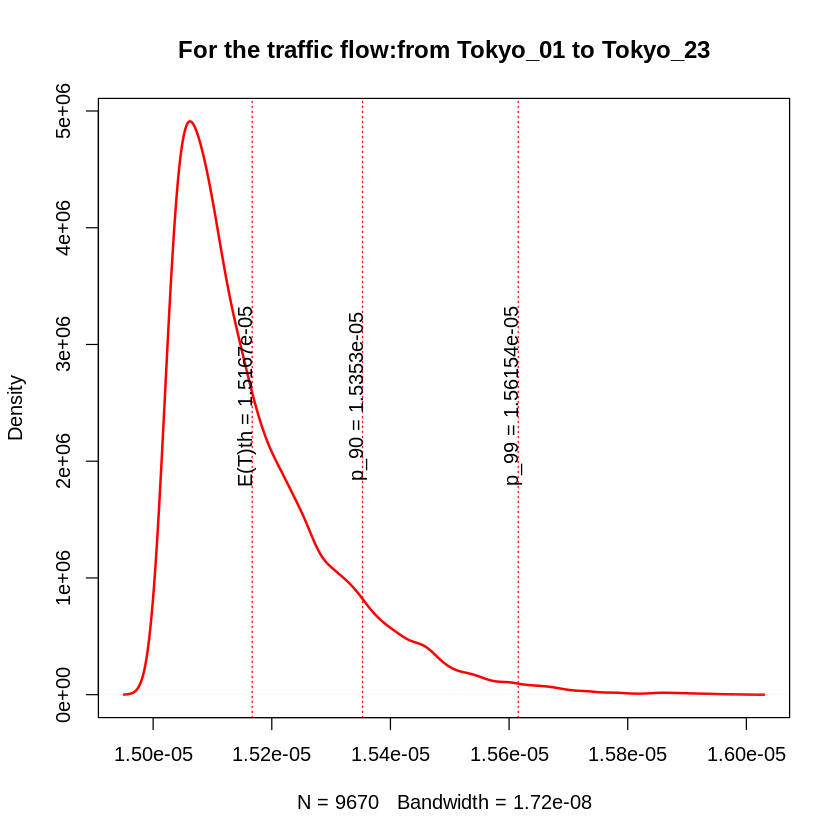

In [ ]:
c(traffic_file$Delay_sim_s, traffic_file$Delay_th_s, traffic_file$D99_sim_s, traffic_file$Hoeff_99th_s, g) := simulation_simmer(g, traffic_file)

print(paste("igraph E(T) =", mean(E(g)$Queue_Delay)))
print(paste("simmer E(T) =", mean(E(g)$Queue_Delay_sim)))

#Output table of traffic flows with delays: theoretic, simulated average packet delay and D.99

In [ ]:
traffic_file

sourceID destinationID trafficGbps service traffic_ps Delay_sim_s 
1  Tokyo_01 Tokyo_01         0.000    CWB             0  0.000000e+00
2  Tokyo_02 Tokyo_01      2263.752    CWB     277683298  5.002185e-06
3  Tokyo_03 Tokyo_01       848.700    CWB     104105845  5.002505e-06
4  Tokyo_04 Tokyo_04      5375.376    CWB     659370875  0.000000e+00
5  Tokyo_05 Tokyo_05      1371.375    CWB     168219811  0.000000e+00
6  Tokyo_06 Tokyo_01      2911.248    CWB     357108441  4.000697e-06
7  Tokyo_07 Tokyo_01      1612.116    CWB     197750323  8.001719e-06
8  Tokyo_08 Tokyo_01      2662.227    CWB     326562262  1.000471e-05
9  Tokyo_09 Tokyo_01       443.394    CWB      54388956  1.000478e-05
10 Tokyo_10 Tokyo_04      2843.145    CWB     348754582  8.005857e-06
11 Tokyo_11 Tokyo_01      2691.000    CWB     330091704  1.500745e-05
12 Tokyo_12 Tokyo_04       559.521    CWB      68633683  8.011728e-06
13 Tokyo_13 Tokyo_04      2538.441    CWB     311378044  4.001328e-06
14 Tokyo_14 Tokyo_04      2891.376    CWB     354670841  3.001166e-06
15 Tokyo_15 Tokyo_04       931.500    CWB     114262513  6.011350e-06
16 Tokyo_16 Tokyo_04      1896.741    CWB     232663868  3.001494e-06
17 Tokyo_17 Tokyo_04      1904.400    CWB     233603360  5.008093e-06
18 Tokyo_18 Tokyo_05      3234.996    CWB     396821012  3.001664e-06
19 Tokyo_19 Tokyo_04      3247.002    CWB     398293729  5.005937e-06
20 Tokyo_20 Tokyo_04      2785.185    CWB     341644914  6.005680e-06
21 Tokyo_21 Tokyo_05       848.700    CWB     104105845  6.009707e-06
22 Tokyo_22 Tokyo_01      3235.203    CWB     396846404  1.200451e-05
23 Tokyo_23 Tokyo_01       931.500    CWB     114262513  1.301210e-05
24 Tokyo_01 Tokyo_01         0.000    CWB             0  0.000000e+00
25 Tokyo_01 Tokyo_02       251.528    CWB      30853700  5.012189e-06
26 Tokyo_01 Tokyo_03        94.300    CWB      11567316  5.017128e-06
27 Tokyo_04 Tokyo_04       597.264    CWB      73263431  0.000000e+00
28 Tokyo_05 Tokyo_05       152.375    CWB      18691090  0.000000e+00
29 Tokyo_01 Tokyo_06       323.472    CWB      39678716  4.009502e-06
30 Tokyo_01 Tokyo_07       179.124    CWB      21972258  8.022402e-06
31 Tokyo_01 Tokyo_08       295.803    CWB      36284696  1.002817e-05
32 Tokyo_01 Tokyo_09        49.266    CWB       6043217  1.003897e-05
33 Tokyo_04 Tokyo_10       315.905    CWB      38750509  8.032900e-06
34 Tokyo_01 Tokyo_11       299.000    CWB      36676856  1.506483e-05
35 Tokyo_04 Tokyo_12        62.169    CWB       7625965  8.210763e-06
36 Tokyo_04 Tokyo_13       282.049    CWB      34597560  4.012661e-06
37 Tokyo_04 Tokyo_14       321.264    CWB      39407871  3.009637e-06
38 Tokyo_04 Tokyo_15       103.500    CWB      12695835  6.082188e-06
39 Tokyo_04 Tokyo_16       210.749    CWB      25851541  3.008586e-06
40 Tokyo_04 Tokyo_17       211.600    CWB      25955929  5.088157e-06
41 Tokyo_05 Tokyo_18       359.444    CWB      44091224  3.012586e-06
42 Tokyo_04 Tokyo_19       360.778    CWB      44254859  5.031819e-06
43 Tokyo_04 Tokyo_20       309.465    CWB      37960546  6.031398e-06
44 Tokyo_05 Tokyo_21        94.300    CWB      11567316  6.070916e-06
45 Tokyo_01 Tokyo_22       359.467    CWB      44094045  1.204384e-05
46 Tokyo_01 Tokyo_23       103.500    CWB      12695835  1.516720e-05
   Delay_th_s   D99_sim_s    Hoeff_99th_s
1  0.000000e+00 0.000000e+00 0.000000e+00
2  5.002074e-06 5.010707e-06 5.016569e-06
3  5.002485e-06 5.011701e-06 5.019851e-06
4  0.000000e+00 0.000000e+00 0.000000e+00
5  0.000000e+00 0.000000e+00 0.000000e+00
6  4.000685e-06 4.003315e-06 4.005474e-06
7  8.001729e-06 8.005575e-06 8.010452e-06
8  1.000470e-05 1.001537e-05 1.002809e-05
9  1.000471e-05 1.001604e-05 1.002802e-05
10 8.005507e-06 8.021747e-06 8.036142e-06
11 1.500748e-05 1.502074e-05 1.503777e-05
12 8.011448e-06 8.051669e-06 8.082760e-06
13 4.001330e-06 4.006200e-06 4.010622e-06
14 3.001121e-06 3.005843e-06 3.008953e-06
15 6.011152e-06 6.050280e-06 6.081688e-06
16 3.001473e-06 3.006764e-06 3.011764e-06

#Calculation of delays for different capacities

In [ ]:
c(g_c10_dg_l05, data_av_c10_dg_l05, data_99_c10_dg_l05) :=simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 10, calc_dist = 0, distance = 5, Load_local = 0.5, Load_regional = 0.6, Load_national = 0.5, prefix_base, national_nodes, regional_nodes, N)


In [ ]:
c(g_c10_dg_l05, data_av_c10_dg_l05, data_99_c10_dg_l05) :=simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 10, calc_dist = 0, distance = 5, Load_local = 0.5, Load_regional = 0.6, Load_national = 0.5, prefix_base, national_nodes, regional_nodes, N)
c(g_c40_dg_l05, data_av_c40_dg_l05, data_99_c40_dg_l05) :=simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 40, calc_dist = 0,  distance = 5, Load_local = 0.5, Load_regional = 0.6, Load_national = 0.5, prefix_base, national_nodes, regional_nodes, N)
c(g_c100_dg_l05, data_av_c100_dg_l05, data_99_c100_dg_l05) :=simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 100, calc_dist = 0,  distance = 5, Load_local = 0.5, Load_regional = 0.6, Load_national = 0.5, prefix_base, national_nodes, regional_nodes, N)
c(g_c400_dg_l05, data_av_c400_dg_l05, data_99_c400_dg_l05) :=simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 400, calc_dist = 0,  distance = 5, Load_local = 0.5, Load_regional = 0.6, Load_national = 0.5, prefix_base, national_nodes, regional_nodes, N)


#Calculation of delays for different distances

In [ ]:
c(g_c100_d05g_l05, data_av_c100_d05g_l05, data_99_c100_d05g_l05) :=simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 100, calc_dist = 1, distance = 0.5, Load_local = 0.5, Load_regional = 0.6, Load_national = 0.5, prefix_base, national_nodes, regional_nodes, N)
c(g_c100_d2g_l05, data_av_c100_d2g_l05, data_99_c100_d2g_l05) :=simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 100, calc_dist = 1, distance = 2, Load_local = 0.5, Load_regional = 0.6, Load_national = 0.5, prefix_base, national_nodes, regional_nodes, N)
c(g_c100_d4g_l05, data_av_c100_d4g_l05, data_99_c100_d4g_l05) :=simulation_igraph(nodes_info, links_info, traffic_file, Capacity = 100, calc_dist = 1, distance = 4, Load_local = 0.5, Load_regional = 0.6, Load_national = 0.5, prefix_base, national_nodes, regional_nodes, N)


#Boxplots

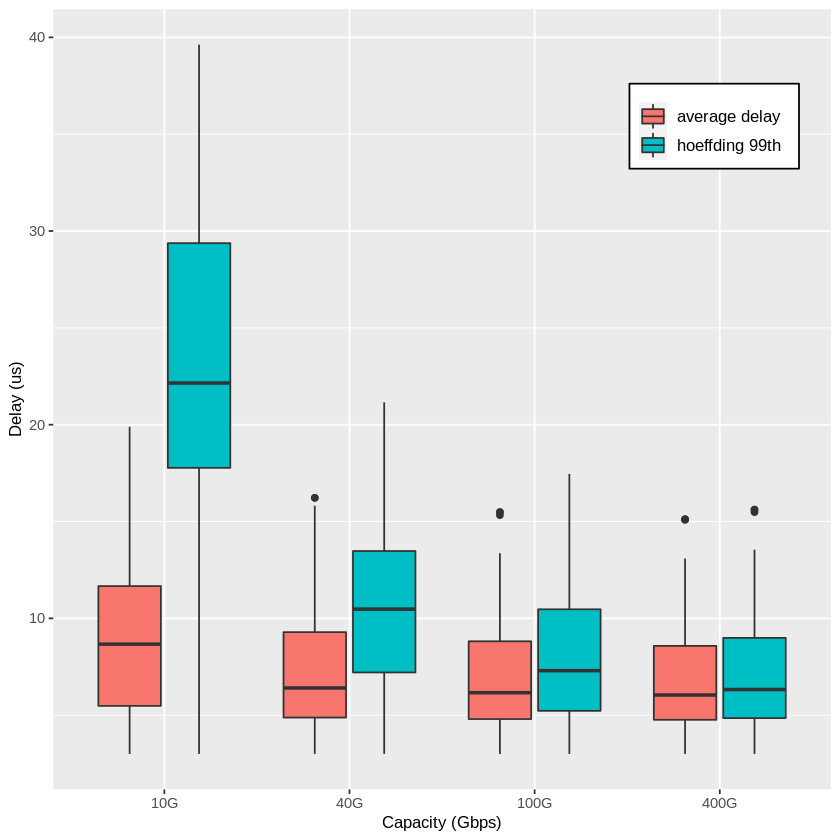

In [ ]:
df_plot_capacity <- data.frame(capacity = c(rep("10G", length(data_99_c10_dg_l05)),
                                            rep("40G", length(data_99_c40_dg_l05)),
                                            rep("100G", length(data_99_c100_dg_l05)),
                                            rep("400G", length(data_99_c400_dg_l05)),
                                            rep("10G", length(data_av_c10_dg_l05)),
                                            rep("40G", length(data_av_c40_dg_l05)),
                                            rep("100G", length(data_av_c100_dg_l05)),
                                            rep("400G", length(data_av_c400_dg_l05))),
                               value = c(data_99_c10_dg_l05,
                                         data_99_c40_dg_l05,
                                         data_99_c100_dg_l05,
                                         data_99_c400_dg_l05,
                                         data_av_c10_dg_l05,
                                         data_av_c40_dg_l05,
                                         data_av_c100_dg_l05,
                                         data_av_c400_dg_l05),
                               type_of_calc = c(rep("hoeffding 99th",length(data_99_c10_dg_l05)*4),
                                                rep("average delay",length(data_99_c10_dg_l05)*4)))



# grouped boxplot
ggplot(df_plot_capacity, aes(x=fct_reorder(capacity,value, .desc = TRUE), y=value*1000000, fill=type_of_calc)) +
geom_boxplot()+
theme(legend.title = element_blank(), legend.position = c(0.85, 0.85), axis.title.y = element_text(size = 10), axis.title.x = element_text(size = 10),
  legend.text = element_text(size = 10), legend.background = element_rect(colour = "black")
  ) +
ylab("Delay (us)") +
xlab("Capacity (Gbps)")


[1] "0.5x diam 2.6 km av link dist 0.388 km"

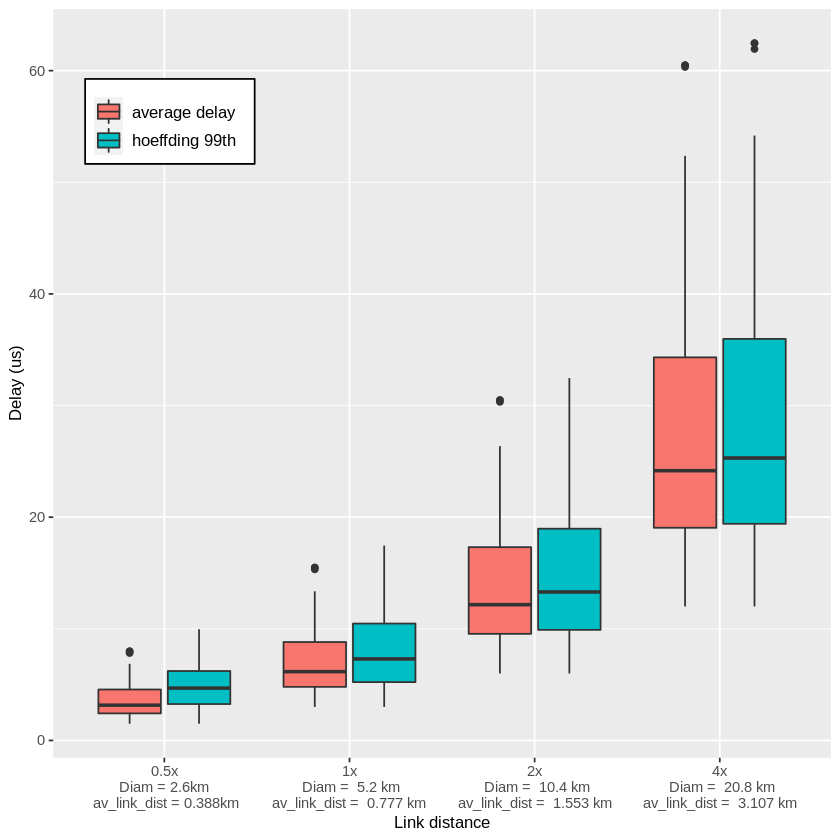

In [ ]:
diam_km <-  round(diameter(g_c100_d05g_l05, directed = TRUE, unconnected = TRUE, weights = E(g_c100_d05g_l05)$Distance), digits = 3)
av_link_km <- round(mean(E(g_c100_d05g_l05)$Distance), digits = 3)
name_05 <- paste0("0.5x\n", "Diam = ", diam_km, "km\n av_link_dist", " = ", av_link_km, "km")
name_1 <- paste("1x\n", "Diam = ", round(diameter(g_c100_dg_l05, directed = TRUE, unconnected = TRUE, weights = E(g_c100_dg_l05)$Distance), digits = 3), "km\nav_link_dist = ", round(mean(E(g_c100_dg_l05)$Distance), digits = 3), "km")
name_2 <- paste("2x\n", "Diam = ", round(diameter(g_c100_d2g_l05, directed = TRUE, unconnected = TRUE, weights = E(g_c100_d2g_l05)$Distance), digits = 3), "km\nav_link_dist = ", round(mean(E(g_c100_d2g_l05)$Distance), digits = 3), "km")
name_4 <- paste("4x\n", "Diam = ", round(diameter(g_c100_d4g_l05, directed = TRUE, unconnected = TRUE, weights = E(g_c100_d4g_l05)$Distance), digits = 3), "km\nav_link_dist = ", round(mean(E(g_c100_d4g_l05)$Distance), digits = 3), "km")

####distanceVSdelay
distance = c(rep(name_05, length(data_99_c100_d05g_l05)),
             rep(name_1, length(data_99_c100_dg_l05)),
             rep(name_2, length(data_99_c100_d2g_l05)),
             rep(name_4, length(data_99_c100_d4g_l05)),
             rep(name_05, length(data_av_c100_d05g_l05)),
             rep(name_1, length(data_av_c100_dg_l05)),
             rep(name_2, length(data_av_c100_d2g_l05)),
             rep(name_4, length(data_av_c100_d4g_l05)))

type_of_calc = c(rep("hoeffding 99th",length(distance)/2),
                 rep("average delay",length(distance)/2))

paste("0.5x", "diam", diam_km, "km av link dist", av_link_km, "km")
value = c(data_99_c100_d05g_l05,
          data_99_c100_dg_l05,
          data_99_c100_d2g_l05,
          data_99_c100_d4g_l05,
          data_av_c100_d05g_l05,
          data_av_c100_dg_l05,
          data_av_c100_d2g_l05,
          data_av_c100_d4g_l05)

df_plot_dist <- data.frame(distance, value, type_of_calc)


# grouped df_plot_dist
ggplot(df_plot_dist, aes(x=distance, y=value*1000000, fill=type_of_calc)) +
  geom_boxplot()+
  theme(
    legend.title = element_blank(), legend.position = c(0.15, 0.85), axis.title.y = element_text(size = 10), axis.title.x = element_text(size = 10),
    legend.text = element_text(size = 10), legend.background = element_rect(colour = "black")
  ) +
  ylab("Delay (us)") +
  xlab("Link distance")


#Creating the report file

In [ ]:
update_file <- function(links_info_df, traffic_file, file_name = "Milano_topology_result.xlsx", file_old_name)
{
    wb <- createWorkbook()
    addWorksheet(wb, sheetName = "Nodes")
    writeData(wb, sheet = 1, read_excel(file_old_name, sheet = 1))
    addWorksheet(wb, sheetName = "Links")
    writeData(wb, sheet = 2, links_info_df)
    addWorksheet(wb, sheetName = "Services")
    writeData(wb, sheet = 3, traffic_file)
    saveWorkbook(wb, file_name, overwrite = TRUE)
}

In [ ]:
update_file(links_info_df,traffic_file, file_name = "Tokyo_topology_result.xlsx", file_old_name = "Metro_topology_full_Tokyo.xlsx")


In [ ]:
p <- drive_get('/content/traffic-latency-simulator/reports/')
drive_upload(file_name, path = as_id(p))